## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


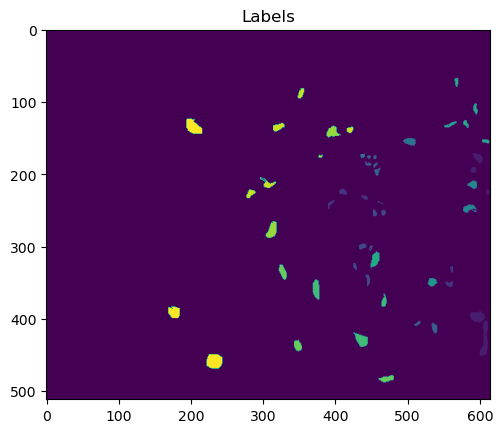

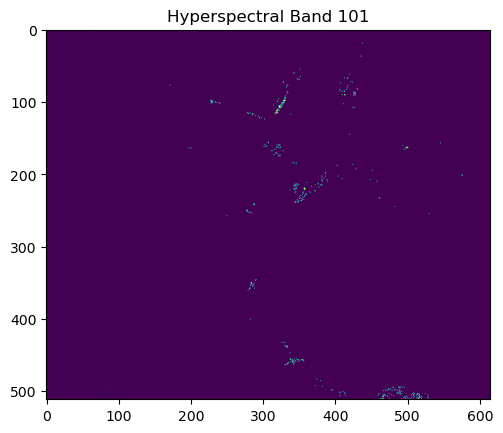

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(130, 5, 5, 176)
(65, 5, 5, 176)
(5016, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 130
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2502, PSNR: 6.0178


Epoch [1/50] Training Loss: 0.2383, PSNR: 5.5439
	[Val]   Batch [1/17] Loss: 0.2230, PSNR: 6.5169
	[Val]   Batch [10/17] Loss: 0.2234, PSNR: 6.5098
Epoch [1/50] Validation Loss: 0.2232, PSNR: 6.5133

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2151, PSNR: 6.6739


Epoch [2/50] Training Loss: 0.2005, PSNR: 6.9845
	[Val]   Batch [1/17] Loss: 0.1766, PSNR: 7.5311
	[Val]   Batch [10/17] Loss: 0.1788, PSNR: 7.4755
Epoch [2/50] Validation Loss: 0.1781, PSNR: 7.4942

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1778, PSNR: 7.5008


Epoch [3/50] Training Loss: 0.1635, PSNR: 7.1887
	[Val]   Batch [1/17] Loss: 0.1398, PSNR: 8.5455
	[Val]   Batch [10/17] Loss: 0.1432, PSNR: 8.4398
Epoch [3/50] Validation Loss: 0.1420, PSNR: 8.4759

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1434, PSNR: 8.4350


Epoch [4/50] Training Loss: 0.1314, PSNR: 8.8205
	[Val]   Batch [1/17] Loss: 0.1141, PSNR: 9.4256
	[Val]   Batch [10/17] Loss: 0.1150, PSNR: 9.3917
Epoch [4/50] Validation Loss: 0.1145, PSNR: 9.4114

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1142, PSNR: 9.4228


Epoch [5/50] Training Loss: 0.1047, PSNR: 9.1274
	[Val]   Batch [1/17] Loss: 0.0919, PSNR: 10.3687
	[Val]   Batch [10/17] Loss: 0.0934, PSNR: 10.2957
Epoch [5/50] Validation Loss: 0.0927, PSNR: 10.3297

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0908, PSNR: 10.4174


Epoch [6/50] Training Loss: 0.0834, PSNR: 10.7976
	[Val]   Batch [1/17] Loss: 0.0735, PSNR: 11.3345
	[Val]   Batch [10/17] Loss: 0.0739, PSNR: 11.3133
Epoch [6/50] Validation Loss: 0.0736, PSNR: 11.3292

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0729, PSNR: 11.3730


Epoch [7/50] Training Loss: 0.0672, PSNR: 11.0562
	[Val]   Batch [1/17] Loss: 0.0604, PSNR: 12.1912
	[Val]   Batch [10/17] Loss: 0.0612, PSNR: 12.1316
Epoch [7/50] Validation Loss: 0.0608, PSNR: 12.1621

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0592, PSNR: 12.2785


Epoch [8/50] Training Loss: 0.0550, PSNR: 12.6010
	[Val]   Batch [1/17] Loss: 0.0499, PSNR: 13.0221
	[Val]   Batch [10/17] Loss: 0.0503, PSNR: 12.9845
Epoch [8/50] Validation Loss: 0.0500, PSNR: 13.0100

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0493, PSNR: 13.0744


Epoch [9/50] Training Loss: 0.0457, PSNR: 13.4016
	[Val]   Batch [1/17] Loss: 0.0418, PSNR: 13.7907
	[Val]   Batch [10/17] Loss: 0.0422, PSNR: 13.7434
Epoch [9/50] Validation Loss: 0.0419, PSNR: 13.7729

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0412, PSNR: 13.8467


Epoch [10/50] Training Loss: 0.0387, PSNR: 14.1216
	[Val]   Batch [1/17] Loss: 0.0360, PSNR: 14.4370
	[Val]   Batch [10/17] Loss: 0.0364, PSNR: 14.3870
Epoch [10/50] Validation Loss: 0.0362, PSNR: 14.4165

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0353, PSNR: 14.5219


Epoch [11/50] Training Loss: 0.0333, PSNR: 14.7778
	[Val]   Batch [1/17] Loss: 0.0313, PSNR: 15.0494
	[Val]   Batch [10/17] Loss: 0.0315, PSNR: 15.0210
Epoch [11/50] Validation Loss: 0.0313, PSNR: 15.0395

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0303, PSNR: 15.1868


Epoch [12/50] Training Loss: 0.0289, PSNR: 14.7092
	[Val]   Batch [1/17] Loss: 0.0279, PSNR: 15.5442
	[Val]   Batch [10/17] Loss: 0.0284, PSNR: 15.4706
Epoch [12/50] Validation Loss: 0.0281, PSNR: 15.5104

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0268, PSNR: 15.7144


Epoch [13/50] Training Loss: 0.0255, PSNR: 15.9353
	[Val]   Batch [1/17] Loss: 0.0243, PSNR: 16.1385
	[Val]   Batch [10/17] Loss: 0.0246, PSNR: 16.0924
Epoch [13/50] Validation Loss: 0.0244, PSNR: 16.1230

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0237, PSNR: 16.2478


Epoch [14/50] Training Loss: 0.0226, PSNR: 16.4520
	[Val]   Batch [1/17] Loss: 0.0218, PSNR: 16.6210
	[Val]   Batch [10/17] Loss: 0.0221, PSNR: 16.5559
Epoch [14/50] Validation Loss: 0.0219, PSNR: 16.5950

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0212, PSNR: 16.7438


Epoch [15/50] Training Loss: 0.0202, PSNR: 16.9381
	[Val]   Batch [1/17] Loss: 0.0195, PSNR: 17.0921
	[Val]   Batch [10/17] Loss: 0.0198, PSNR: 17.0363
Epoch [15/50] Validation Loss: 0.0196, PSNR: 17.0734

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0193, PSNR: 17.1442


Epoch [16/50] Training Loss: 0.0183, PSNR: 17.3866
	[Val]   Batch [1/17] Loss: 0.0177, PSNR: 17.5222
	[Val]   Batch [10/17] Loss: 0.0180, PSNR: 17.4538
Epoch [16/50] Validation Loss: 0.0178, PSNR: 17.4918

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0169, PSNR: 17.7330


Epoch [17/50] Training Loss: 0.0165, PSNR: 17.8154
	[Val]   Batch [1/17] Loss: 0.0161, PSNR: 17.9382
	[Val]   Batch [10/17] Loss: 0.0163, PSNR: 17.8868
Epoch [17/50] Validation Loss: 0.0162, PSNR: 17.9169

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0156, PSNR: 18.0570


Epoch [18/50] Training Loss: 0.0151, PSNR: 18.2120
	[Val]   Batch [1/17] Loss: 0.0147, PSNR: 18.3163
	[Val]   Batch [10/17] Loss: 0.0150, PSNR: 18.2496
Epoch [18/50] Validation Loss: 0.0148, PSNR: 18.2855

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0146, PSNR: 18.3590


Epoch [19/50] Training Loss: 0.0138, PSNR: 18.5892
	[Val]   Batch [1/17] Loss: 0.0135, PSNR: 18.6851
	[Val]   Batch [10/17] Loss: 0.0137, PSNR: 18.6197
Epoch [19/50] Validation Loss: 0.0136, PSNR: 18.6538

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0130, PSNR: 18.8622


Epoch [20/50] Training Loss: 0.0127, PSNR: 18.9544
	[Val]   Batch [1/17] Loss: 0.0124, PSNR: 19.0537
	[Val]   Batch [10/17] Loss: 0.0126, PSNR: 18.9882
Epoch [20/50] Validation Loss: 0.0125, PSNR: 19.0234

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0121, PSNR: 19.1683


Epoch [21/50] Training Loss: 0.0118, PSNR: 18.6291
	[Val]   Batch [1/17] Loss: 0.0117, PSNR: 19.3187
	[Val]   Batch [10/17] Loss: 0.0119, PSNR: 19.2280
Epoch [21/50] Validation Loss: 0.0118, PSNR: 19.2763

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0113, PSNR: 19.4657


Epoch [22/50] Training Loss: 0.0109, PSNR: 18.9487
	[Val]   Batch [1/17] Loss: 0.0108, PSNR: 19.6481
	[Val]   Batch [10/17] Loss: 0.0111, PSNR: 19.5636
Epoch [22/50] Validation Loss: 0.0109, PSNR: 19.6092

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0105, PSNR: 19.7992


Epoch [23/50] Training Loss: 0.0102, PSNR: 19.9268
	[Val]   Batch [1/17] Loss: 0.0100, PSNR: 19.9918
	[Val]   Batch [10/17] Loss: 0.0102, PSNR: 19.9189
Epoch [23/50] Validation Loss: 0.0101, PSNR: 19.9610

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0097, PSNR: 20.1153


Epoch [24/50] Training Loss: 0.0095, PSNR: 20.2362
	[Val]   Batch [1/17] Loss: 0.0094, PSNR: 20.2856
	[Val]   Batch [10/17] Loss: 0.0096, PSNR: 20.1901
Epoch [24/50] Validation Loss: 0.0095, PSNR: 20.2367

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0093, PSNR: 20.3186


Epoch [25/50] Training Loss: 0.0089, PSNR: 20.5163
	[Val]   Batch [1/17] Loss: 0.0088, PSNR: 20.5542
	[Val]   Batch [10/17] Loss: 0.0090, PSNR: 20.4702
Epoch [25/50] Validation Loss: 0.0089, PSNR: 20.5137

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0088, PSNR: 20.5750


Epoch [26/50] Training Loss: 0.0083, PSNR: 20.1358
	[Val]   Batch [1/17] Loss: 0.0084, PSNR: 20.7752
	[Val]   Batch [10/17] Loss: 0.0085, PSNR: 20.6813
Epoch [26/50] Validation Loss: 0.0085, PSNR: 20.7303

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0081, PSNR: 20.9128


Epoch [27/50] Training Loss: 0.0078, PSNR: 21.0674
	[Val]   Batch [1/17] Loss: 0.0077, PSNR: 21.1277
	[Val]   Batch [10/17] Loss: 0.0079, PSNR: 21.0283
Epoch [27/50] Validation Loss: 0.0078, PSNR: 21.0740

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0074, PSNR: 21.3096


Epoch [28/50] Training Loss: 0.0074, PSNR: 21.3126
	[Val]   Batch [1/17] Loss: 0.0074, PSNR: 21.3191
	[Val]   Batch [10/17] Loss: 0.0076, PSNR: 21.2154
Epoch [28/50] Validation Loss: 0.0075, PSNR: 21.2629

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0071, PSNR: 21.4636


Epoch [29/50] Training Loss: 0.0070, PSNR: 21.5763
	[Val]   Batch [1/17] Loss: 0.0069, PSNR: 21.6310
	[Val]   Batch [10/17] Loss: 0.0070, PSNR: 21.5240
Epoch [29/50] Validation Loss: 0.0070, PSNR: 21.5744

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0069, PSNR: 21.6110


Epoch [30/50] Training Loss: 0.0066, PSNR: 21.8253
	[Val]   Batch [1/17] Loss: 0.0065, PSNR: 21.8615
	[Val]   Batch [10/17] Loss: 0.0067, PSNR: 21.7499
Epoch [30/50] Validation Loss: 0.0066, PSNR: 21.8032

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0062, PSNR: 22.0426


Epoch [31/50] Training Loss: 0.0062, PSNR: 22.0651
	[Val]   Batch [1/17] Loss: 0.0062, PSNR: 22.1040
	[Val]   Batch [10/17] Loss: 0.0063, PSNR: 21.9903
Epoch [31/50] Validation Loss: 0.0063, PSNR: 22.0406

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0062, PSNR: 22.0552


Epoch [32/50] Training Loss: 0.0059, PSNR: 22.3082
	[Val]   Batch [1/17] Loss: 0.0058, PSNR: 22.3407
	[Val]   Batch [10/17] Loss: 0.0060, PSNR: 22.2116
Epoch [32/50] Validation Loss: 0.0059, PSNR: 22.2685

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0057, PSNR: 22.4740


Epoch [33/50] Training Loss: 0.0056, PSNR: 21.8443
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.4951
	[Val]   Batch [10/17] Loss: 0.0058, PSNR: 22.3714
Epoch [33/50] Validation Loss: 0.0057, PSNR: 22.4276

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0056, PSNR: 22.5036


Epoch [34/50] Training Loss: 0.0053, PSNR: 22.7412
	[Val]   Batch [1/17] Loss: 0.0053, PSNR: 22.7675
	[Val]   Batch [10/17] Loss: 0.0055, PSNR: 22.6351
Epoch [34/50] Validation Loss: 0.0054, PSNR: 22.6926

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0052, PSNR: 22.8360


Epoch [35/50] Training Loss: 0.0051, PSNR: 22.9546
	[Val]   Batch [1/17] Loss: 0.0050, PSNR: 22.9882
	[Val]   Batch [10/17] Loss: 0.0052, PSNR: 22.8573
Epoch [35/50] Validation Loss: 0.0051, PSNR: 22.9151

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0049, PSNR: 23.1066


Epoch [36/50] Training Loss: 0.0048, PSNR: 22.4671
	[Val]   Batch [1/17] Loss: 0.0049, PSNR: 23.1394
	[Val]   Batch [10/17] Loss: 0.0050, PSNR: 22.9960
Epoch [36/50] Validation Loss: 0.0049, PSNR: 23.0600

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0046, PSNR: 23.3647


Epoch [37/50] Training Loss: 0.0046, PSNR: 23.3570
	[Val]   Batch [1/17] Loss: 0.0046, PSNR: 23.4041
	[Val]   Batch [10/17] Loss: 0.0047, PSNR: 23.2575
Epoch [37/50] Validation Loss: 0.0047, PSNR: 23.3194

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0044, PSNR: 23.5372


Epoch [38/50] Training Loss: 0.0044, PSNR: 23.5493
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5686
	[Val]   Batch [10/17] Loss: 0.0046, PSNR: 23.4093
Epoch [38/50] Validation Loss: 0.0045, PSNR: 23.4781

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.7133


Epoch [39/50] Training Loss: 0.0042, PSNR: 23.7417
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7215
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.5583
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.6254

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.8445


Epoch [40/50] Training Loss: 0.0041, PSNR: 23.9172
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9438
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.7805
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.8497

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.8988


Epoch [41/50] Training Loss: 0.0039, PSNR: 23.4295
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.0556
	[Val]   Batch [10/17] Loss: 0.0041, PSNR: 23.8779
Epoch [41/50] Validation Loss: 0.0040, PSNR: 23.9512

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0038, PSNR: 24.2433


Epoch [42/50] Training Loss: 0.0037, PSNR: 23.5893
	[Val]   Batch [1/17] Loss: 0.0038, PSNR: 24.2482
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.0720
Epoch [42/50] Validation Loss: 0.0039, PSNR: 24.1448

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.5078


Epoch [43/50] Training Loss: 0.0036, PSNR: 24.4448
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.5109
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.3309
Epoch [43/50] Validation Loss: 0.0036, PSNR: 24.4034

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.6077


Epoch [44/50] Training Loss: 0.0035, PSNR: 24.5821
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.5971
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4012
Epoch [44/50] Validation Loss: 0.0036, PSNR: 24.4755

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8162


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.0816
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.7837
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.5888
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.6682

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8212


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.2516
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9172
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.7214
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8022

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.0960


Epoch [47/50] Training Loss: 0.0031, PSNR: 25.0625
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1368
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9349
Epoch [47/50] Validation Loss: 0.0032, PSNR: 25.0153

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2969


Epoch [48/50] Training Loss: 0.0030, PSNR: 25.2177
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.2872
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0756
Epoch [48/50] Validation Loss: 0.0030, PSNR: 25.1597

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.5077


Epoch [49/50] Training Loss: 0.0029, PSNR: 25.3729
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.4126
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.1892
Epoch [49/50] Validation Loss: 0.0030, PSNR: 25.2798

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.5381


Epoch [50/50] Training Loss: 0.0028, PSNR: 25.5113
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5737
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3486
Epoch [50/50] Validation Loss: 0.0029, PSNR: 25.4377


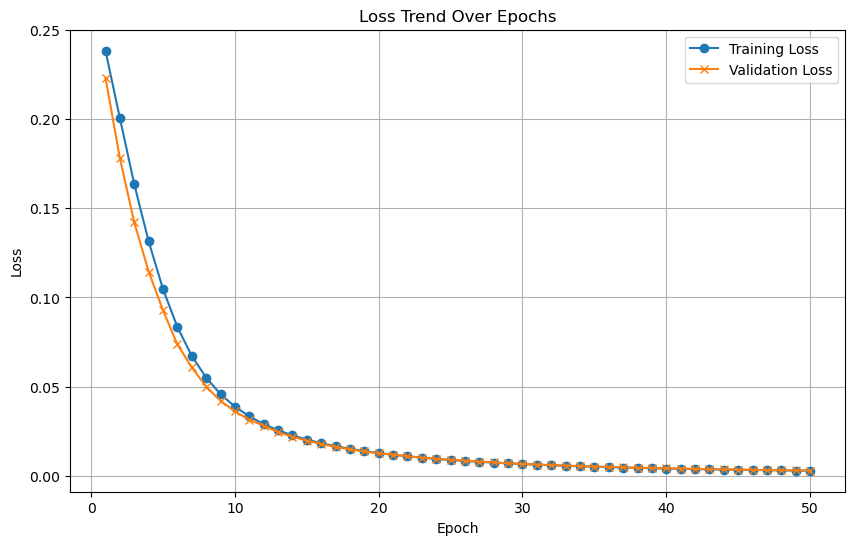

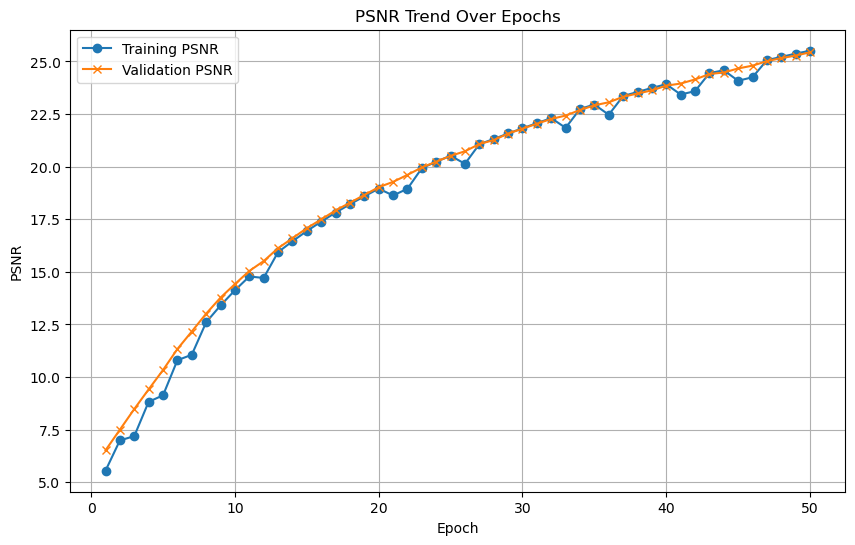

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5863
    Validation Batch [1/1], Loss: 2.5749
Validation Loss: 2.5749, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5749. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5672
    Validation Batch [1/1], Loss: 2.5748
Validation Loss: 2.5748, Validation Accuracy: 7.69%
Validation loss improved from 2.5749 to 2.5748. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5596
    Validation Batch [1/1], Loss: 2.5748
Validation Loss: 2.5748, Validation Accuracy: 7.69%
Validation loss improved from 2.5748 to 2.5748. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5491
    Validation Batch [1/1], Loss: 2.5747
Validation Loss: 2.5747, Validation Accuracy: 7.69%
Validation loss improved from 2.5748 to 2.5747. Saving model...

LOG: Epoch [5/1000] - 

    Validation Batch [1/1], Loss: 2.5735
Validation Loss: 2.5735, Validation Accuracy: 7.69%
Validation loss improved from 2.5736 to 2.5735. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4445
    Validation Batch [1/1], Loss: 2.5734
Validation Loss: 2.5734, Validation Accuracy: 7.69%
Validation loss improved from 2.5735 to 2.5734. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4362
    Validation Batch [1/1], Loss: 2.5733
Validation Loss: 2.5733, Validation Accuracy: 7.69%
Validation loss improved from 2.5734 to 2.5733. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4339
    Validation Batch [1/1], Loss: 2.5732
Validation Loss: 2.5732, Validation Accuracy: 7.69%
Validation loss improved from 2.5733 to 2.5732. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.4252
    Validati

Epoch [50/1000] completed, Average Training Loss: 2.2517
    Validation Batch [1/1], Loss: 2.5833
Validation Loss: 2.5833, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.2528
    Validation Batch [1/1], Loss: 2.5850
Validation Loss: 2.5850, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.2332
    Validation Batch [1/1], Loss: 2.5866
Validation Loss: 2.5866, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.2203
    Validation Batch [1/1], Loss: 2.5880
Validation Loss: 2.5880, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.2281
    Validat

Epoch [80/1000] completed, Average Training Loss: 2.0319
    Validation Batch [1/1], Loss: 2.4235
Validation Loss: 2.4235, Validation Accuracy: 13.85%
Validation loss improved from 2.4396 to 2.4235. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 2.0410
    Validation Batch [1/1], Loss: 2.4063
Validation Loss: 2.4063, Validation Accuracy: 13.85%
Validation loss improved from 2.4235 to 2.4063. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 2.0369
    Validation Batch [1/1], Loss: 2.3893
Validation Loss: 2.3893, Validation Accuracy: 15.38%
Validation loss improved from 2.4063 to 2.3893. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.9991
    Validation Batch [1/1], Loss: 2.3750
Validation Loss: 2.3750, Validation Accuracy: 15.38%
Validation loss improved from 2.3893 to 2.3750. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [8

Epoch [110/1000] completed, Average Training Loss: 1.7870
    Validation Batch [1/1], Loss: 2.0752
Validation Loss: 2.0752, Validation Accuracy: 32.31%
Validation loss improved from 2.0804 to 2.0752. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.8183
    Validation Batch [1/1], Loss: 2.0685
Validation Loss: 2.0685, Validation Accuracy: 32.31%
Validation loss improved from 2.0752 to 2.0685. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.7950
    Validation Batch [1/1], Loss: 2.0617
Validation Loss: 2.0617, Validation Accuracy: 32.31%
Validation loss improved from 2.0685 to 2.0617. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.7623
    Validation Batch [1/1], Loss: 2.0570
Validation Loss: 2.0570, Validation Accuracy: 32.31%
Validation loss improved from 2.0617 to 2.0570. Saving model...

LOG: Epoch [114/1000] - Training


Epoch [140/1000] completed, Average Training Loss: 1.4886
    Validation Batch [1/1], Loss: 1.8801
Validation Loss: 1.8801, Validation Accuracy: 40.00%
Validation loss improved from 1.8918 to 1.8801. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.5363
    Validation Batch [1/1], Loss: 1.8740
Validation Loss: 1.8740, Validation Accuracy: 38.46%
Validation loss improved from 1.8801 to 1.8740. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.5119
    Validation Batch [1/1], Loss: 1.8681
Validation Loss: 1.8681, Validation Accuracy: 40.00%
Validation loss improved from 1.8740 to 1.8681. Saving model...

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.4905
    Validation Batch [1/1], Loss: 1.8657
Validation Loss: 1.8657, Validation Accuracy: 40.00%
Validation loss improved from 1.8681 to 1.8657. Saving model...

LOG: Epoch [144/1000] - Training


Epoch [170/1000] completed, Average Training Loss: 1.2710
    Validation Batch [1/1], Loss: 1.7051
Validation Loss: 1.7051, Validation Accuracy: 49.23%
Validation loss improved from 1.7052 to 1.7051. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.2347
    Validation Batch [1/1], Loss: 1.7093
Validation Loss: 1.7093, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 1.2422
    Validation Batch [1/1], Loss: 1.6997
Validation Loss: 1.6997, Validation Accuracy: 55.38%
Validation loss improved from 1.7051 to 1.6997. Saving model...

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.2263
    Validation Batch [1/1], Loss: 1.6856
Validation Loss: 1.6856, Validation Accuracy: 55.38%
Validation loss improved from 1.6997 to 1.6856. Saving model...

LOG: Epoch [174/1000] - Training
Epoch [174/1000

Epoch [196/1000] completed, Average Training Loss: 0.9827
    Validation Batch [1/1], Loss: 1.5960
Validation Loss: 1.5960, Validation Accuracy: 58.46%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.9658
    Validation Batch [1/1], Loss: 1.5857
Validation Loss: 1.5857, Validation Accuracy: 58.46%
Validation loss improved from 1.5921 to 1.5857. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.9905
    Validation Batch [1/1], Loss: 1.5739
Validation Loss: 1.5739, Validation Accuracy: 61.54%
Validation loss improved from 1.5857 to 1.5739. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.9583
    Validation Batch [1/1], Loss: 1.5713
Validation Loss: 1.5713, Validation Accuracy: 60.00%
Validation loss improved from 1.5739 to 1.5713. Saving model...

LOG: Epoch [200/1000] - Training
Epoch [200/1000

Epoch [227/1000] completed, Average Training Loss: 0.7576
    Validation Batch [1/1], Loss: 1.4933
Validation Loss: 1.4933, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.7294
    Validation Batch [1/1], Loss: 1.5095
Validation Loss: 1.5095, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.7466
    Validation Batch [1/1], Loss: 1.5238
Validation Loss: 1.5238, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.7772
    Validation Batch [1/1], Loss: 1.5073
Validation Loss: 1.5073, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.7159
  

Epoch [253/1000] completed, Average Training Loss: 0.5575
    Validation Batch [1/1], Loss: 1.4034
Validation Loss: 1.4034, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.5488
    Validation Batch [1/1], Loss: 1.3892
Validation Loss: 1.3892, Validation Accuracy: 63.08%
Validation loss improved from 1.4006 to 1.3892. Saving model...

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.5619
    Validation Batch [1/1], Loss: 1.4031
Validation Loss: 1.4031, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.5381
    Validation Batch [1/1], Loss: 1.4109
Validation Loss: 1.4109, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training 

Epoch [283/1000] completed, Average Training Loss: 0.4460
    Validation Batch [1/1], Loss: 1.3516
Validation Loss: 1.3516, Validation Accuracy: 64.62%
Validation loss improved from 1.3549 to 1.3516. Saving model...

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.4072
    Validation Batch [1/1], Loss: 1.3523
Validation Loss: 1.3523, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.4034
    Validation Batch [1/1], Loss: 1.3427
Validation Loss: 1.3427, Validation Accuracy: 66.15%
Validation loss improved from 1.3516 to 1.3427. Saving model...

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.3916
    Validation Batch [1/1], Loss: 1.3389
Validation Loss: 1.3389, Validation Accuracy: 67.69%
Validation loss improved from 1.3427 to 1.3389. Saving model...

LOG: Epoch [287/1000] - Training
Epoch [287/1000

Epoch [313/1000] completed, Average Training Loss: 0.3072
    Validation Batch [1/1], Loss: 1.3519
Validation Loss: 1.3519, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.3353
    Validation Batch [1/1], Loss: 1.3606
Validation Loss: 1.3606, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.3098
    Validation Batch [1/1], Loss: 1.3983
Validation Loss: 1.3983, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.2881
    Validation Batch [1/1], Loss: 1.4420
Validation Loss: 1.4420, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.276

Epoch [341/1000] completed, Average Training Loss: 0.2253
    Validation Batch [1/1], Loss: 1.4079
Validation Loss: 1.4079, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.2467
    Validation Batch [1/1], Loss: 1.4062
Validation Loss: 1.4062, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.2102
    Validation Batch [1/1], Loss: 1.4201
Validation Loss: 1.4201, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.2393
    Validation Batch [1/1], Loss: 1.4215
Validation Loss: 1.4215, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.211

Epoch [372/1000] completed, Average Training Loss: 0.1994
    Validation Batch [1/1], Loss: 1.3995
Validation Loss: 1.3995, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.1724
    Validation Batch [1/1], Loss: 1.4359
Validation Loss: 1.4359, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.1864
    Validation Batch [1/1], Loss: 1.4738
Validation Loss: 1.4738, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.1554
    Validation Batch [1/1], Loss: 1.4765
Validation Loss: 1.4765, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.188

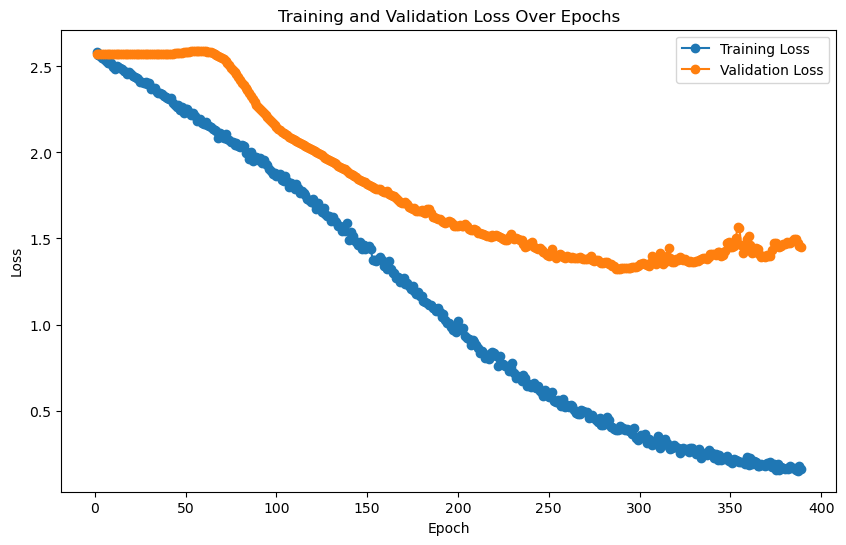

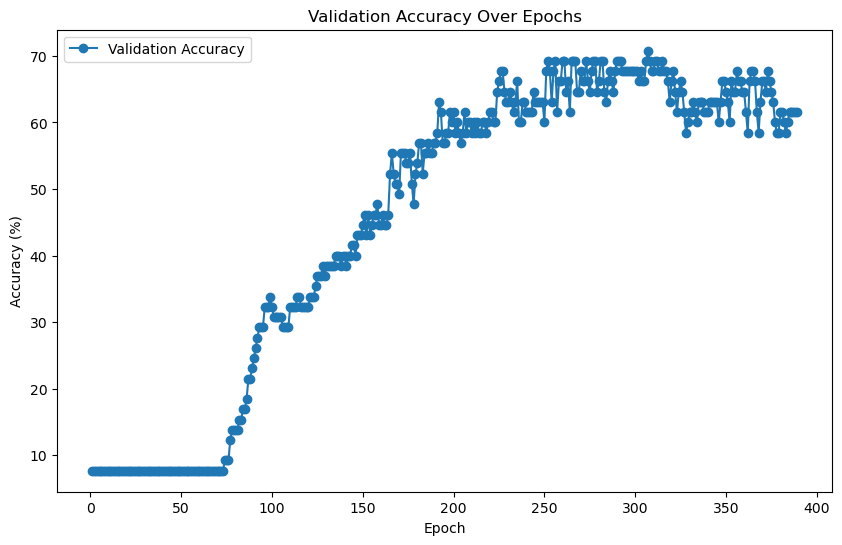


Evaluating on the test set...
    Test Batch [1/20], Loss: 1.4238

Final Test Loss: 1.4598, Test Accuracy: 72.45%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)

LOG: Training features shape: (130, 64), Training labels shape: (130,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (5016, 64), Test labels shape: (5016,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 43.08%

Validation Classification Report:
               precision    recall  f1

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)
Train reps shape: (130, 64)
Train labels shape: (130,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (5016, 64)
Test labels shape: (5016,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6649  |  Val Loss: 2.5871
Validation loss improved from inf to 2.5871.
[Epoch 2/1000] Train Loss: 2.5713  |  Val Loss: 2.5639
Validation loss improved from 2.5871 to 2.5639.
[Epoch 3/1000] Train Loss: 2.5506  |  Val Loss: 2.5566
Validation loss improved from 2.5639 to 2.5566.
[Epoch 4/1000] Train Loss: 2.5396  |  Val Loss: 2.5416
Validation loss improved from 2.5566 to 2.5416.
[Epoch 5/1000] Train Loss: 2.5196  |  Val Loss: 2.5212
Validation loss improved from 2.5416 to 2.5212.
[Epoch 6/1000] Train Loss: 2.5028  |  Val Loss: 2.5156
Validation loss improved from 2.5212 to 2.5156.
[Epoch 7/1000] Train Loss: 2.4976  |  Val Loss: 2.5163
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 8/1000] Train Loss: 2.4959  |  Val Loss: 2.5195
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 9/1000] Train Loss: 2.5011  |  Val Loss: 2.5124
Validation loss improved from 2.5156 to 2.5124.
[Epoch 10/1000] Train Loss: 2.4851  |  Val Loss: 2.4957
Validati

[Epoch 27/1000] Train Loss: 2.4117  |  Val Loss: 2.4579
Validation loss improved from 2.4627 to 2.4579.
[Epoch 28/1000] Train Loss: 2.4088  |  Val Loss: 2.4709
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 29/1000] Train Loss: 2.4205  |  Val Loss: 2.4729
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 30/1000] Train Loss: 2.4174  |  Val Loss: 2.4646
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 31/1000] Train Loss: 2.4090  |  Val Loss: 2.4535
Validation loss improved from 2.4579 to 2.4535.
[Epoch 32/1000] Train Loss: 2.3975  |  Val Loss: 2.4419
Validation loss improved from 2.4535 to 2.4419.
[Epoch 33/1000] Train Loss: 2.3841  |  Val Loss: 2.4301
Validation loss improved from 2.4419 to 2.4301.
[Epoch 34/1000] Train Loss: 2.3764  |  Val Loss: 2.4240
Validation loss improved from 2.4301 to 2.4240.
[Epoch 35/1000] Train Loss: 2.3752  |  Val Loss: 2.4211
Validation loss improved from 2.4240 to 2.4211.
[Epoch 36/1000] Train Loss: 2.3710  |  Val Los

[Epoch 61/1000] Train Loss: 2.3131  |  Val Loss: 2.3872
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 62/1000] Train Loss: 2.3090  |  Val Loss: 2.3892
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 63/1000] Train Loss: 2.3094  |  Val Loss: 2.3810
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 64/1000] Train Loss: 2.2994  |  Val Loss: 2.3713
Validation loss improved from 2.3790 to 2.3713.
[Epoch 65/1000] Train Loss: 2.2889  |  Val Loss: 2.3592
Validation loss improved from 2.3713 to 2.3592.
[Epoch 66/1000] Train Loss: 2.2758  |  Val Loss: 2.3510
Validation loss improved from 2.3592 to 2.3510.
[Epoch 67/1000] Train Loss: 2.2662  |  Val Loss: 2.3494
Validation loss improved from 2.3510 to 2.3494.
[Epoch 68/1000] Train Loss: 2.2655  |  Val Loss: 2.3548
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 2.2730  |  Val Loss: 2.3617
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 70/1000] Train Loss: 2.2753

[Epoch 95/1000] Train Loss: 2.2043  |  Val Loss: 2.3032
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 96/1000] Train Loss: 2.2034  |  Val Loss: 2.2895
Validation loss improved from 2.2928 to 2.2895.
[Epoch 97/1000] Train Loss: 2.1984  |  Val Loss: 2.2895
Validation loss improved from 2.2895 to 2.2895.
[Epoch 98/1000] Train Loss: 2.2019  |  Val Loss: 2.3284
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 99/1000] Train Loss: 2.2453  |  Val Loss: 2.3035
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 100/1000] Train Loss: 2.1978  |  Val Loss: 2.2866
Validation loss improved from 2.2895 to 2.2866.
[Epoch 101/1000] Train Loss: 2.1826  |  Val Loss: 2.3367
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 2.2248  |  Val Loss: 2.3750
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 2.2505  |  Val Loss: 2.3845
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 104/1000] Train L

[Epoch 122/1000] Train Loss: 2.1118  |  Val Loss: 2.2977
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 123/1000] Train Loss: 2.1767  |  Val Loss: 2.3194
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 124/1000] Train Loss: 2.1780  |  Val Loss: 2.2419
Validation loss improved from 2.2429 to 2.2419.
[Epoch 125/1000] Train Loss: 2.1270  |  Val Loss: 2.3174
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 126/1000] Train Loss: 2.1989  |  Val Loss: 2.2733
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 127/1000] Train Loss: 2.1402  |  Val Loss: 2.2054
Validation loss improved from 2.2419 to 2.2054.
[Epoch 128/1000] Train Loss: 2.1007  |  Val Loss: 2.2380
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 129/1000] Train Loss: 2.1436  |  Val Loss: 2.2162
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 130/1000] Train Loss: 2.1012  |  Val Loss: 2.1854
Validation loss improved from 2.2054 to 2.1854.
[Epoch 131/1000] Tr

[Epoch 151/1000] Train Loss: 2.0083  |  Val Loss: 2.1591
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 152/1000] Train Loss: 2.0538  |  Val Loss: 2.1549
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 153/1000] Train Loss: 2.0380  |  Val Loss: 2.1177
Validation loss improved from 2.1292 to 2.1177.
[Epoch 154/1000] Train Loss: 1.9953  |  Val Loss: 2.1263
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 155/1000] Train Loss: 2.0082  |  Val Loss: 2.1786
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 156/1000] Train Loss: 2.0406  |  Val Loss: 2.1239
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 157/1000] Train Loss: 1.9799  |  Val Loss: 2.1368
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 158/1000] Train Loss: 2.0207  |  Val Loss: 2.1870
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 159/1000] Train Loss: 2.0260  |  Val Loss: 2.1394
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 184/1000] Train Loss: 1.8796  |  Val Loss: 2.0455
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 185/1000] Train Loss: 1.8825  |  Val Loss: 2.0577
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 186/1000] Train Loss: 1.8732  |  Val Loss: 2.0576
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 187/1000] Train Loss: 1.8666  |  Val Loss: 2.0614
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 188/1000] Train Loss: 1.8520  |  Val Loss: 2.0782
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 189/1000] Train Loss: 1.8802  |  Val Loss: 2.0982
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 190/1000] Train Loss: 1.8829  |  Val Loss: 2.0535
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 191/1000] Train Loss: 1.8568  |  Val Loss: 2.1541
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 192/1000] Train Loss: 1.9119  |  Val Loss: 2.0531
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 215/1000] Train Loss: 1.8195  |  Val Loss: 2.0081
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 216/1000] Train Loss: 1.8146  |  Val Loss: 2.0071
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 217/1000] Train Loss: 1.8074  |  Val Loss: 1.9768
Validation loss improved from 1.9839 to 1.9768.
[Epoch 218/1000] Train Loss: 1.7850  |  Val Loss: 2.0387
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 219/1000] Train Loss: 1.8582  |  Val Loss: 2.0275
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 220/1000] Train Loss: 1.8493  |  Val Loss: 1.9497
Validation loss improved from 1.9768 to 1.9497.
[Epoch 221/1000] Train Loss: 1.7782  |  Val Loss: 1.9589
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 222/1000] Train Loss: 1.7828  |  Val Loss: 1.9630
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 223/1000] Train Loss: 1.7776  |  Val Loss: 1.9777
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 224/10

[Epoch 245/1000] Train Loss: 1.7759  |  Val Loss: 1.9498
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 246/1000] Train Loss: 1.7553  |  Val Loss: 2.0795
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 247/1000] Train Loss: 1.8992  |  Val Loss: 2.0320
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 248/1000] Train Loss: 1.7915  |  Val Loss: 1.9871
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 249/1000] Train Loss: 1.8306  |  Val Loss: 2.0215
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 250/1000] Train Loss: 1.7712  |  Val Loss: 1.9319
Validation loss improved from 1.9450 to 1.9319.
[Epoch 251/1000] Train Loss: 1.7546  |  Val Loss: 1.9719
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 1.7347  |  Val Loss: 2.0453
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 253/1000] Train Loss: 1.8018  |  Val Loss: 2.0315
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 276/1000] Train Loss: 1.6792  |  Val Loss: 1.9396
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 277/1000] Train Loss: 1.6746  |  Val Loss: 1.9552
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 278/1000] Train Loss: 1.6696  |  Val Loss: 1.9836
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 279/1000] Train Loss: 1.7070  |  Val Loss: 2.0110
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 280/1000] Train Loss: 1.7227  |  Val Loss: 1.9322
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 281/1000] Train Loss: 1.6818  |  Val Loss: 1.9357
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 282/1000] Train Loss: 1.6930  |  Val Loss: 2.0270
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 283/1000] Train Loss: 1.8097  |  Val Loss: 2.0205
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 284/1000] Train Loss: 1.7427  |  Val Loss: 1.9366
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 309/1000] Train Loss: 1.6495  |  Val Loss: 1.9942
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 310/1000] Train Loss: 1.8124  |  Val Loss: 1.9970
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 311/1000] Train Loss: 1.7353  |  Val Loss: 1.8705
Validation loss improved from 1.8801 to 1.8705.
[Epoch 312/1000] Train Loss: 1.6738  |  Val Loss: 2.0260
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 313/1000] Train Loss: 1.8166  |  Val Loss: 2.0051
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 314/1000] Train Loss: 1.7245  |  Val Loss: 1.9906
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 315/1000] Train Loss: 1.7205  |  Val Loss: 2.1659
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 316/1000] Train Loss: 1.8377  |  Val Loss: 1.9993
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 317/1000] Train Loss: 1.6725  |  Val Loss: 1.9585
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 341/1000] Train Loss: 1.6382  |  Val Loss: 1.9028
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 342/1000] Train Loss: 1.6347  |  Val Loss: 1.8896
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 343/1000] Train Loss: 1.6244  |  Val Loss: 1.9913
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 344/1000] Train Loss: 1.6605  |  Val Loss: 1.9541
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 345/1000] Train Loss: 1.6045  |  Val Loss: 2.0050
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 346/1000] Train Loss: 1.6618  |  Val Loss: 1.9844
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 347/1000] Train Loss: 1.6212  |  Val Loss: 1.9509
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 348/1000] Train Loss: 1.6015  |  Val Loss: 1.9766
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 349/1000] Train Loss: 1.7224  |  Val Loss: 2.0162
!! Validation loss did NOT improve !! Patience:

[Epoch 373/1000] Train Loss: 1.6567  |  Val Loss: 1.8640
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 374/1000] Train Loss: 1.5520  |  Val Loss: 1.8423
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 375/1000] Train Loss: 1.5447  |  Val Loss: 1.8440
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 376/1000] Train Loss: 1.5377  |  Val Loss: 1.8609
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 377/1000] Train Loss: 1.5555  |  Val Loss: 1.8911
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 378/1000] Train Loss: 1.5809  |  Val Loss: 1.9112
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 379/1000] Train Loss: 1.5907  |  Val Loss: 1.9419
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 380/1000] Train Loss: 1.5705  |  Val Loss: 1.9412
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 381/1000] Train Loss: 1.5514  |  Val Loss: 1.9162
!! Validation loss did NOT improve !! Patience:

[Epoch 401/1000] Train Loss: 1.5546  |  Val Loss: 1.9537
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 402/1000] Train Loss: 1.5977  |  Val Loss: 1.8932
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 403/1000] Train Loss: 1.5382  |  Val Loss: 1.8576
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 404/1000] Train Loss: 1.5243  |  Val Loss: 1.8333
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 405/1000] Train Loss: 1.5251  |  Val Loss: 1.8398
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 406/1000] Train Loss: 1.5470  |  Val Loss: 1.8311
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 407/1000] Train Loss: 1.5458  |  Val Loss: 1.8796
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 408/1000] Train Loss: 1.5674  |  Val Loss: 1.8435
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 409/1000] Train Loss: 1.5370  |  Val Loss: 1.9034
!! Validation loss did NOT improve !! Patience:

[Epoch 428/1000] Train Loss: 1.5714  |  Val Loss: 2.0469
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 429/1000] Train Loss: 1.6336  |  Val Loss: 1.9015
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 430/1000] Train Loss: 1.5629  |  Val Loss: 1.9634
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 431/1000] Train Loss: 1.5611  |  Val Loss: 1.8541
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 432/1000] Train Loss: 1.5148  |  Val Loss: 1.8474
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 433/1000] Train Loss: 1.4864  |  Val Loss: 1.9125
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 434/1000] Train Loss: 1.5814  |  Val Loss: 1.9036
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 435/1000] Train Loss: 1.5357  |  Val Loss: 1.8347
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 436/1000] Train Loss: 1.5017  |  Val Loss: 1.8779
!! Validation loss did NOT improve !! Patience:

[Epoch 459/1000] Train Loss: 1.5021  |  Val Loss: 1.8626
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 460/1000] Train Loss: 1.5064  |  Val Loss: 1.8503
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 461/1000] Train Loss: 1.4842  |  Val Loss: 1.9309
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 462/1000] Train Loss: 1.5022  |  Val Loss: 1.9611
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 463/1000] Train Loss: 1.4901  |  Val Loss: 2.0198
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 464/1000] Train Loss: 1.5184  |  Val Loss: 2.0519
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 465/1000] Train Loss: 1.5034  |  Val Loss: 2.0347
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 466/1000] Train Loss: 1.5121  |  Val Loss: 1.9298
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 467/1000] Train Loss: 1.4776  |  Val Loss: 1.8667
!! Validation loss did NOT improve !! Patience:

[Epoch 489/1000] Train Loss: 1.7133  |  Val Loss: 1.9306
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 490/1000] Train Loss: 1.4906  |  Val Loss: 1.9383
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 491/1000] Train Loss: 1.5482  |  Val Loss: 2.0204
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 492/1000] Train Loss: 1.5204  |  Val Loss: 2.0103
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 493/1000] Train Loss: 1.6429  |  Val Loss: 2.2668
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 494/1000] Train Loss: 1.8669  |  Val Loss: 1.9447
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 495/1000] Train Loss: 1.5061  |  Val Loss: 1.9425
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 496/1000] Train Loss: 1.5752  |  Val Loss: 1.8875
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 497/1000] Train Loss: 1.4898  |  Val Loss: 1.8358
!! Validation loss did NOT improve !! Patience:

[Epoch 522/1000] Train Loss: 1.4924  |  Val Loss: 2.0313
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 523/1000] Train Loss: 1.7359  |  Val Loss: 2.4158
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 524/1000] Train Loss: 2.0557  |  Val Loss: 2.1947
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 525/1000] Train Loss: 1.7531  |  Val Loss: 1.8763
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 526/1000] Train Loss: 1.5359  |  Val Loss: 2.1540
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 527/1000] Train Loss: 1.6767  |  Val Loss: 1.9176
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 528/1000] Train Loss: 1.4576  |  Val Loss: 1.9428
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 529/1000] Train Loss: 1.5275  |  Val Loss: 1.9413
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 530/1000] Train Loss: 1.5157  |  Val Loss: 1.8484
!! Validation loss did NOT improve !! Patience:

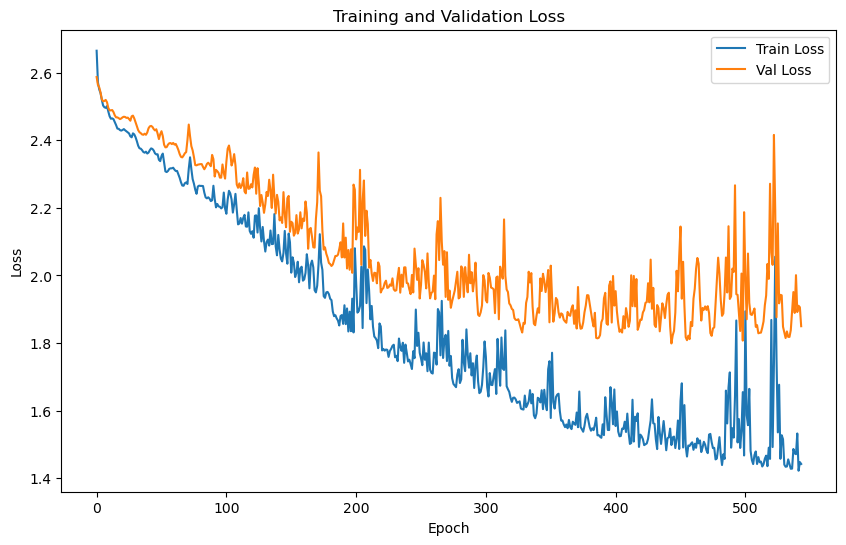

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.9423 | Test Accuracy: 29.51%


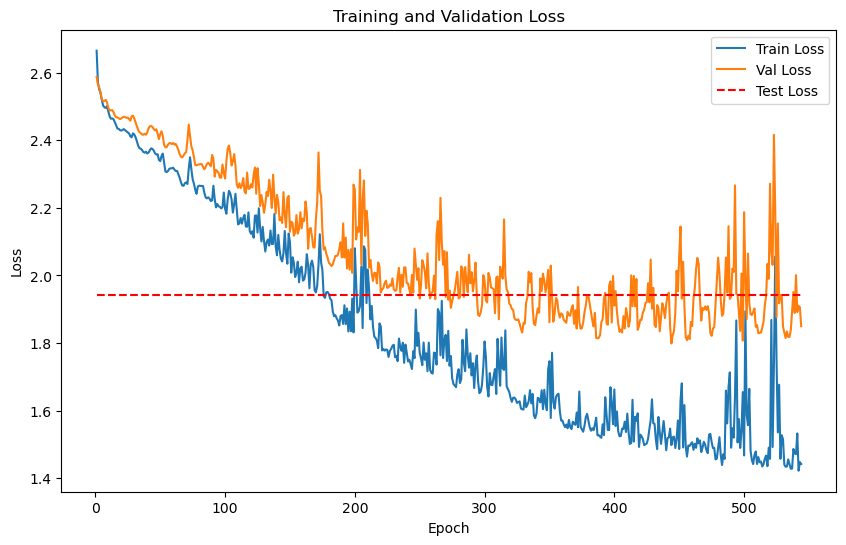

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)


Train embeddings shape: (130, 64), 
Train labels shape: (130,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5016, 64), 
Test labels shape: (5016,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}
Training batch size: 130


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.1268
Epoch [1/2000], Avg Train Loss: 8.1268
Epoch [1/2000], Avg Val Loss: 5.6269
Validation loss improved from inf to 5.6269. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.0827
Epoch [2/2000], Avg Train Loss: 8.0827
Epoch [2/2000], Avg Val Loss: 5.5931
Validation loss improved from 5.6269 to 5.5931. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.0778
Epoch [3/2000], Avg Train Loss: 8.0778
Epoch [3/2000], Avg Val Loss: 5.5598
Validation loss improved from 5.5931 to 5.5598. Saving model...

LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 7.9331
Epoch [4/2000], Avg Train Loss: 7.9331
Epoch [4/2000], Avg Val Loss: 5.5266
Validation loss improved from 5.5598 to 5.5266. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.8498
Epoch [5/2000], Avg Train Loss: 7.8498
Epoch [5/2000], Avg Val Loss: 5.4941
Validation loss improved from 5.5266 to 5.4941. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.7435
Epoch [6/2000], Avg Train Loss: 7.7435
Epoch [6/2000], Avg Val Loss: 5.4619
Validation loss improved from 5.4941 to 5.4619. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.6794
Epoch [7/2000], Avg Train Loss: 7.6794
Epoch [7/2000], Avg Val Loss: 5.4296
Validation loss improved from 5.4619 to 5.4296. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.5951
Epoch [8/2000], Avg Train Loss: 7.5951
Epoch [8/2000], Avg Val Loss: 5.3974
Validation loss improved from 5.4296 to 5.3974. Saving m

    Batch [1/1], Train Loss: 6.7769
Epoch [20/2000], Avg Train Loss: 6.7769
Epoch [20/2000], Avg Val Loss: 5.0290
Validation loss improved from 5.0581 to 5.0290. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.8287
Epoch [21/2000], Avg Train Loss: 6.8287
Epoch [21/2000], Avg Val Loss: 5.0002
Validation loss improved from 5.0290 to 5.0002. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.0067
Epoch [22/2000], Avg Train Loss: 7.0067
Epoch [22/2000], Avg Val Loss: 4.9716
Validation loss improved from 5.0002 to 4.9716. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.0283
Epoch [23/2000], Avg Train Loss: 7.0283
Epoch [23/2000], Avg Val Loss: 4.9434
Validation loss improved from 4.9716 to 4.9434. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.8130
Epoch [24/2000], Avg Train Loss: 6.8130
Epoch [24/2000], Avg Val Loss: 4.9157
Validation loss improved from 4.9434 to 4.

    Batch [1/1], Train Loss: 6.3174
Epoch [30/2000], Avg Train Loss: 6.3174
Epoch [30/2000], Avg Val Loss: 4.7590
Validation loss improved from 4.7844 to 4.7590. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.5218
Epoch [31/2000], Avg Train Loss: 6.5218
Epoch [31/2000], Avg Val Loss: 4.7342
Validation loss improved from 4.7590 to 4.7342. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.5040
Epoch [32/2000], Avg Train Loss: 6.5040
Epoch [32/2000], Avg Val Loss: 4.7096
Validation loss improved from 4.7342 to 4.7096. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.4107
Epoch [33/2000], Avg Train Loss: 6.4107
Epoch [33/2000], Avg Val Loss: 4.6858
Validation loss improved from 4.7096 to 4.6858. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.3521
Epoch [34/2000], Avg Train Loss: 6.3521
Epoch [34/2000], Avg Val Loss: 4.6624
Validation loss improved from 4.6858 to 4.

Epoch [48/2000], Avg Val Loss: 4.3780
Validation loss improved from 4.3956 to 4.3780. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.9920
Epoch [49/2000], Avg Train Loss: 5.9920
Epoch [49/2000], Avg Val Loss: 4.3609
Validation loss improved from 4.3780 to 4.3609. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.7942
Epoch [50/2000], Avg Train Loss: 5.7942
Epoch [50/2000], Avg Val Loss: 4.3442
Validation loss improved from 4.3609 to 4.3442. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.8005
Epoch [51/2000], Avg Train Loss: 5.8005
Epoch [51/2000], Avg Val Loss: 4.3280
Validation loss improved from 4.3442 to 4.3280. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.9034
Epoch [52/2000], Avg Train Loss: 5.9034
Epoch [52/2000], Avg Val Loss: 4.3122
Validation loss improved from 4.3280 to 4.3122. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.5216
Epoch [68/2000], Avg Train Loss: 5.5216
Epoch [68/2000], Avg Val Loss: 4.1075
Validation loss improved from 4.1180 to 4.1075. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.4528
Epoch [69/2000], Avg Train Loss: 5.4528
Epoch [69/2000], Avg Val Loss: 4.0973
Validation loss improved from 4.1075 to 4.0973. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.4686
Epoch [70/2000], Avg Train Loss: 5.4686
Epoch [70/2000], Avg Val Loss: 4.0873
Validation loss improved from 4.0973 to 4.0873. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.4035
Epoch [71/2000], Avg Train Loss: 5.4035
Epoch [71/2000], Avg Val Loss: 4.0776
Validation loss improved from 4.0873 to 4.0776. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.4607
Epoch [72/2000], Avg Train Loss: 5.4607
Epoch [72/2000], Avg Val Loss: 4.0681
Validation loss improved from 4.0776 to 4.

    Batch [1/1], Train Loss: 5.4467
Epoch [77/2000], Avg Train Loss: 5.4467
Epoch [77/2000], Avg Val Loss: 4.0252
Validation loss improved from 4.0333 to 4.0252. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.3067
Epoch [78/2000], Avg Train Loss: 5.3067
Epoch [78/2000], Avg Val Loss: 4.0174
Validation loss improved from 4.0252 to 4.0174. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.2535
Epoch [79/2000], Avg Train Loss: 5.2535
Epoch [79/2000], Avg Val Loss: 4.0098
Validation loss improved from 4.0174 to 4.0098. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 5.2814
Epoch [80/2000], Avg Train Loss: 5.2814
Epoch [80/2000], Avg Val Loss: 4.0024
Validation loss improved from 4.0098 to 4.0024. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.2455
Epoch [81/2000], Avg Train Loss: 5.2455
Epoch [81/2000], Avg Val Loss: 3.9952
Validation loss improved from 4.0024 to 3.

    Batch [1/1], Train Loss: 5.1159
Epoch [92/2000], Avg Train Loss: 5.1159
Epoch [92/2000], Avg Val Loss: 3.9263
Validation loss improved from 3.9319 to 3.9263. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.1707
Epoch [93/2000], Avg Train Loss: 5.1707
Epoch [93/2000], Avg Val Loss: 3.9209
Validation loss improved from 3.9263 to 3.9209. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.0927
Epoch [94/2000], Avg Train Loss: 5.0927
Epoch [94/2000], Avg Val Loss: 3.9156
Validation loss improved from 3.9209 to 3.9156. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.1041
Epoch [95/2000], Avg Train Loss: 5.1041
Epoch [95/2000], Avg Val Loss: 3.9106
Validation loss improved from 3.9156 to 3.9106. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.0968
Epoch [96/2000], Avg Train Loss: 5.0968
Epoch [96/2000], Avg Val Loss: 3.9055
Validation loss improved from 3.9106 to 3.

Epoch [110/2000], Avg Val Loss: 3.8436
Validation loss improved from 3.8475 to 3.8436. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.9817
Epoch [111/2000], Avg Train Loss: 4.9817
Epoch [111/2000], Avg Val Loss: 3.8398
Validation loss improved from 3.8436 to 3.8398. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 5.0056
Epoch [112/2000], Avg Train Loss: 5.0056
Epoch [112/2000], Avg Val Loss: 3.8361
Validation loss improved from 3.8398 to 3.8361. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.9533
Epoch [113/2000], Avg Train Loss: 4.9533
Epoch [113/2000], Avg Val Loss: 3.8324
Validation loss improved from 3.8361 to 3.8324. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.9756
Epoch [114/2000], Avg Train Loss: 4.9756
Epoch [114/2000], Avg Val Loss: 3.8288
Validation loss improved from 3.8324 to 3.8288. Saving model...

LOG: Epoch [115/2000] - Training
    Bat

Epoch [125/2000], Avg Val Loss: 3.7938
Validation loss improved from 3.7966 to 3.7938. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.8533
Epoch [126/2000], Avg Train Loss: 4.8533
Epoch [126/2000], Avg Val Loss: 3.7911
Validation loss improved from 3.7938 to 3.7911. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.8729
Epoch [127/2000], Avg Train Loss: 4.8729
Epoch [127/2000], Avg Val Loss: 3.7884
Validation loss improved from 3.7911 to 3.7884. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.9128
Epoch [128/2000], Avg Train Loss: 4.9128
Epoch [128/2000], Avg Val Loss: 3.7857
Validation loss improved from 3.7884 to 3.7857. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.8720
Epoch [129/2000], Avg Train Loss: 4.8720
Epoch [129/2000], Avg Val Loss: 3.7830
Validation loss improved from 3.7857 to 3.7830. Saving model...

LOG: Epoch [130/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7759
Epoch [142/2000], Avg Train Loss: 4.7759
Epoch [142/2000], Avg Val Loss: 3.7526
Validation loss improved from 3.7548 to 3.7526. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 4.7291
Epoch [143/2000], Avg Train Loss: 4.7291
Epoch [143/2000], Avg Val Loss: 3.7505
Validation loss improved from 3.7526 to 3.7505. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 4.7453
Epoch [144/2000], Avg Train Loss: 4.7453
Epoch [144/2000], Avg Val Loss: 3.7484
Validation loss improved from 3.7505 to 3.7484. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.8326
Epoch [145/2000], Avg Train Loss: 4.8326
Epoch [145/2000], Avg Val Loss: 3.7463
Validation loss improved from 3.7484 to 3.7463. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.7540
Epoch [146/2000], Avg Train Loss: 4.7540
Epoch [146/2000], Avg Val Loss: 3.7443
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7181
Epoch [160/2000], Avg Train Loss: 4.7181
Epoch [160/2000], Avg Val Loss: 3.7199
Validation loss improved from 3.7214 to 3.7199. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.6707
Epoch [161/2000], Avg Train Loss: 4.6707
Epoch [161/2000], Avg Val Loss: 3.7184
Validation loss improved from 3.7199 to 3.7184. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.6994
Epoch [162/2000], Avg Train Loss: 4.6994
Epoch [162/2000], Avg Val Loss: 3.7169
Validation loss improved from 3.7184 to 3.7169. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.7178
Epoch [163/2000], Avg Train Loss: 4.7178
Epoch [163/2000], Avg Val Loss: 3.7155
Validation loss improved from 3.7169 to 3.7155. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 4.6960
Epoch [164/2000], Avg Train Loss: 4.6960
Epoch [164/2000], Avg Val Loss: 3.7140
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6485
Epoch [173/2000], Avg Train Loss: 4.6485
Epoch [173/2000], Avg Val Loss: 3.7022
Validation loss improved from 3.7034 to 3.7022. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.5718
Epoch [174/2000], Avg Train Loss: 4.5718
Epoch [174/2000], Avg Val Loss: 3.7011
Validation loss improved from 3.7022 to 3.7011. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.6565
Epoch [175/2000], Avg Train Loss: 4.6565
Epoch [175/2000], Avg Val Loss: 3.7000
Validation loss improved from 3.7011 to 3.7000. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.6716
Epoch [176/2000], Avg Train Loss: 4.6716
Epoch [176/2000], Avg Val Loss: 3.6989
Validation loss improved from 3.7000 to 3.6989. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.6483
Epoch [177/2000], Avg Train Loss: 4.6483
Epoch [177/2000], Avg Val Loss: 3.6978
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6332
Epoch [189/2000], Avg Train Loss: 4.6332
Epoch [189/2000], Avg Val Loss: 3.6863
Validation loss improved from 3.6871 to 3.6863. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 4.6553
Epoch [190/2000], Avg Train Loss: 4.6553
Epoch [190/2000], Avg Val Loss: 3.6855
Validation loss improved from 3.6863 to 3.6855. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 4.6083
Epoch [191/2000], Avg Train Loss: 4.6083
Epoch [191/2000], Avg Val Loss: 3.6846
Validation loss improved from 3.6855 to 3.6846. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 4.6298
Epoch [192/2000], Avg Train Loss: 4.6298
Epoch [192/2000], Avg Val Loss: 3.6838
Validation loss improved from 3.6846 to 3.6838. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.6295
Epoch [193/2000], Avg Train Loss: 4.6295
Epoch [193/2000], Avg Val Loss: 3.6829
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5985
Epoch [202/2000], Avg Train Loss: 4.5985
Epoch [202/2000], Avg Val Loss: 3.6757
Validation loss improved from 3.6764 to 3.6757. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 4.5756
Epoch [203/2000], Avg Train Loss: 4.5756
Epoch [203/2000], Avg Val Loss: 3.6751
Validation loss improved from 3.6757 to 3.6751. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 4.5573
Epoch [204/2000], Avg Train Loss: 4.5573
Epoch [204/2000], Avg Val Loss: 3.6744
Validation loss improved from 3.6751 to 3.6744. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 4.6102
Epoch [205/2000], Avg Train Loss: 4.6102
Epoch [205/2000], Avg Val Loss: 3.6738
Validation loss improved from 3.6744 to 3.6738. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 4.5599
Epoch [206/2000], Avg Train Loss: 4.5599
Epoch [206/2000], Avg Val Loss: 3.6731
Validation loss improved fro

Epoch [218/2000], Avg Val Loss: 3.6663
Validation loss improved from 3.6668 to 3.6663. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.5574
Epoch [219/2000], Avg Train Loss: 4.5574
Epoch [219/2000], Avg Val Loss: 3.6658
Validation loss improved from 3.6663 to 3.6658. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.5166
Epoch [220/2000], Avg Train Loss: 4.5166
Epoch [220/2000], Avg Val Loss: 3.6653
Validation loss improved from 3.6658 to 3.6653. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.5752
Epoch [221/2000], Avg Train Loss: 4.5752
Epoch [221/2000], Avg Val Loss: 3.6648
Validation loss improved from 3.6653 to 3.6648. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 4.5423
Epoch [222/2000], Avg Train Loss: 4.5423
Epoch [222/2000], Avg Val Loss: 3.6644
Validation loss improved from 3.6648 to 3.6644. Saving model...

LOG: Epoch [223/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5653
Epoch [234/2000], Avg Train Loss: 4.5653
Epoch [234/2000], Avg Val Loss: 3.6581
Validation loss improved from 3.6587 to 3.6581. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 4.5440
Epoch [235/2000], Avg Train Loss: 4.5440
Epoch [235/2000], Avg Val Loss: 3.6576
Validation loss improved from 3.6581 to 3.6576. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 4.5389
Epoch [236/2000], Avg Train Loss: 4.5389
Epoch [236/2000], Avg Val Loss: 3.6571
Validation loss improved from 3.6576 to 3.6571. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.4801
Epoch [237/2000], Avg Train Loss: 4.4801
Epoch [237/2000], Avg Val Loss: 3.6567
Validation loss improved from 3.6571 to 3.6567. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.4737
Epoch [238/2000], Avg Train Loss: 4.4737
Epoch [238/2000], Avg Val Loss: 3.6562
Validation loss improved fro

Epoch [247/2000], Avg Val Loss: 3.6522
Validation loss improved from 3.6526 to 3.6522. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 4.5209
Epoch [248/2000], Avg Train Loss: 4.5209
Epoch [248/2000], Avg Val Loss: 3.6518
Validation loss improved from 3.6522 to 3.6518. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 4.4424
Epoch [249/2000], Avg Train Loss: 4.4424
Epoch [249/2000], Avg Val Loss: 3.6513
Validation loss improved from 3.6518 to 3.6513. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 4.4828
Epoch [250/2000], Avg Train Loss: 4.4828
Epoch [250/2000], Avg Val Loss: 3.6509
Validation loss improved from 3.6513 to 3.6509. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 4.4833
Epoch [251/2000], Avg Train Loss: 4.4833
Epoch [251/2000], Avg Val Loss: 3.6505
Validation loss improved from 3.6509 to 3.6505. Saving model...

LOG: Epoch [252/2000] - Training
    Bat

Epoch [262/2000], Avg Val Loss: 3.6457
Validation loss improved from 3.6461 to 3.6457. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 4.5121
Epoch [263/2000], Avg Train Loss: 4.5121
Epoch [263/2000], Avg Val Loss: 3.6453
Validation loss improved from 3.6457 to 3.6453. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.4828
Epoch [264/2000], Avg Train Loss: 4.4828
Epoch [264/2000], Avg Val Loss: 3.6449
Validation loss improved from 3.6453 to 3.6449. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.4588
Epoch [265/2000], Avg Train Loss: 4.4588
Epoch [265/2000], Avg Val Loss: 3.6445
Validation loss improved from 3.6449 to 3.6445. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.4908
Epoch [266/2000], Avg Train Loss: 4.4908
Epoch [266/2000], Avg Val Loss: 3.6440
Validation loss improved from 3.6445 to 3.6440. Saving model...

LOG: Epoch [267/2000] - Training
    Bat

Epoch [283/2000], Avg Val Loss: 3.6382
Validation loss improved from 3.6385 to 3.6382. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 4.4590
Epoch [284/2000], Avg Train Loss: 4.4590
Epoch [284/2000], Avg Val Loss: 3.6380
Validation loss improved from 3.6382 to 3.6380. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 4.4731
Epoch [285/2000], Avg Train Loss: 4.4731
Epoch [285/2000], Avg Val Loss: 3.6378
Validation loss improved from 3.6380 to 3.6378. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 4.4384
Epoch [286/2000], Avg Train Loss: 4.4384
Epoch [286/2000], Avg Val Loss: 3.6376
Validation loss improved from 3.6378 to 3.6376. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 4.4546
Epoch [287/2000], Avg Train Loss: 4.4546
Epoch [287/2000], Avg Val Loss: 3.6374
Validation loss improved from 3.6376 to 3.6374. Saving model...

LOG: Epoch [288/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4718
Epoch [294/2000], Avg Train Loss: 4.4718
Epoch [294/2000], Avg Val Loss: 3.6360
Validation loss improved from 3.6361 to 3.6360. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 4.4866
Epoch [295/2000], Avg Train Loss: 4.4866
Epoch [295/2000], Avg Val Loss: 3.6358
Validation loss improved from 3.6360 to 3.6358. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 4.4293
Epoch [296/2000], Avg Train Loss: 4.4293
Epoch [296/2000], Avg Val Loss: 3.6356
Validation loss improved from 3.6358 to 3.6356. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 4.4458
Epoch [297/2000], Avg Train Loss: 4.4458
Epoch [297/2000], Avg Val Loss: 3.6355
Validation loss improved from 3.6356 to 3.6355. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 4.4068
Epoch [298/2000], Avg Train Loss: 4.4068
Epoch [298/2000], Avg Val Loss: 3.6354
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4210
Epoch [305/2000], Avg Train Loss: 4.4210
Epoch [305/2000], Avg Val Loss: 3.6348
Validation loss improved from 3.6349 to 3.6348. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 4.4292
Epoch [306/2000], Avg Train Loss: 4.4292
Epoch [306/2000], Avg Val Loss: 3.6347
Validation loss improved from 3.6348 to 3.6347. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.4135
Epoch [307/2000], Avg Train Loss: 4.4135
Epoch [307/2000], Avg Val Loss: 3.6346
Validation loss improved from 3.6347 to 3.6346. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 4.4405
Epoch [308/2000], Avg Train Loss: 4.4405
Epoch [308/2000], Avg Val Loss: 3.6344
Validation loss improved from 3.6346 to 3.6344. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 4.4146
Epoch [309/2000], Avg Train Loss: 4.4146
Epoch [309/2000], Avg Val Loss: 3.6343
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4446
Epoch [326/2000], Avg Train Loss: 4.4446
Epoch [326/2000], Avg Val Loss: 3.6307
Validation loss improved from 3.6309 to 3.6307. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 4.4066
Epoch [327/2000], Avg Train Loss: 4.4066
Epoch [327/2000], Avg Val Loss: 3.6305
Validation loss improved from 3.6307 to 3.6305. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 4.4132
Epoch [328/2000], Avg Train Loss: 4.4132
Epoch [328/2000], Avg Val Loss: 3.6303
Validation loss improved from 3.6305 to 3.6303. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 4.4266
Epoch [329/2000], Avg Train Loss: 4.4266
Epoch [329/2000], Avg Val Loss: 3.6301
Validation loss improved from 3.6303 to 3.6301. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 4.3725
Epoch [330/2000], Avg Train Loss: 4.3725
Epoch [330/2000], Avg Val Loss: 3.6299
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3701
Epoch [337/2000], Avg Train Loss: 4.3701
Epoch [337/2000], Avg Val Loss: 3.6284
Validation loss improved from 3.6287 to 3.6284. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.4465
Epoch [338/2000], Avg Train Loss: 4.4465
Epoch [338/2000], Avg Val Loss: 3.6282
Validation loss improved from 3.6284 to 3.6282. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.3552
Epoch [339/2000], Avg Train Loss: 4.3552
Epoch [339/2000], Avg Val Loss: 3.6279
Validation loss improved from 3.6282 to 3.6279. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 4.4045
Epoch [340/2000], Avg Train Loss: 4.4045
Epoch [340/2000], Avg Val Loss: 3.6277
Validation loss improved from 3.6279 to 3.6277. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 4.3709
Epoch [341/2000], Avg Train Loss: 4.3709
Epoch [341/2000], Avg Val Loss: 3.6274
Validation loss improved fro

Epoch [345/2000], Avg Val Loss: 3.6265
Validation loss improved from 3.6267 to 3.6265. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 4.3615
Epoch [346/2000], Avg Train Loss: 4.3615
Epoch [346/2000], Avg Val Loss: 3.6262
Validation loss improved from 3.6265 to 3.6262. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.3984
Epoch [347/2000], Avg Train Loss: 4.3984
Epoch [347/2000], Avg Val Loss: 3.6260
Validation loss improved from 3.6262 to 3.6260. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.3501
Epoch [348/2000], Avg Train Loss: 4.3501
Epoch [348/2000], Avg Val Loss: 3.6257
Validation loss improved from 3.6260 to 3.6257. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 4.4131
Epoch [349/2000], Avg Train Loss: 4.4131
Epoch [349/2000], Avg Val Loss: 3.6255
Validation loss improved from 3.6257 to 3.6255. Saving model...

LOG: Epoch [350/2000] - Training
    Bat

Epoch [365/2000], Avg Val Loss: 3.6221
Validation loss improved from 3.6224 to 3.6221. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 4.3736
Epoch [366/2000], Avg Train Loss: 4.3736
Epoch [366/2000], Avg Val Loss: 3.6218
Validation loss improved from 3.6221 to 3.6218. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 4.3630
Epoch [367/2000], Avg Train Loss: 4.3630
Epoch [367/2000], Avg Val Loss: 3.6216
Validation loss improved from 3.6218 to 3.6216. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 4.3238
Epoch [368/2000], Avg Train Loss: 4.3238
Epoch [368/2000], Avg Val Loss: 3.6214
Validation loss improved from 3.6216 to 3.6214. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 4.3402
Epoch [369/2000], Avg Train Loss: 4.3402
Epoch [369/2000], Avg Val Loss: 3.6212
Validation loss improved from 3.6214 to 3.6212. Saving model...

LOG: Epoch [370/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3244
Epoch [382/2000], Avg Train Loss: 4.3244
Epoch [382/2000], Avg Val Loss: 3.6191
Validation loss improved from 3.6192 to 3.6191. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 4.3974
Epoch [383/2000], Avg Train Loss: 4.3974
Epoch [383/2000], Avg Val Loss: 3.6189
Validation loss improved from 3.6191 to 3.6189. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 4.3154
Epoch [384/2000], Avg Train Loss: 4.3154
Epoch [384/2000], Avg Val Loss: 3.6188
Validation loss improved from 3.6189 to 3.6188. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.2773
Epoch [385/2000], Avg Train Loss: 4.2773
Epoch [385/2000], Avg Val Loss: 3.6186
Validation loss improved from 3.6188 to 3.6186. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.3869
Epoch [386/2000], Avg Train Loss: 4.3869
Epoch [386/2000], Avg Val Loss: 3.6185
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3623
Epoch [390/2000], Avg Train Loss: 4.3623
Epoch [390/2000], Avg Val Loss: 3.6179
Validation loss improved from 3.6181 to 3.6179. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 4.3142
Epoch [391/2000], Avg Train Loss: 4.3142
Epoch [391/2000], Avg Val Loss: 3.6178
Validation loss improved from 3.6179 to 3.6178. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 4.3250
Epoch [392/2000], Avg Train Loss: 4.3250
Epoch [392/2000], Avg Val Loss: 3.6177
Validation loss improved from 3.6178 to 3.6177. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 4.3385
Epoch [393/2000], Avg Train Loss: 4.3385
Epoch [393/2000], Avg Val Loss: 3.6176
Validation loss improved from 3.6177 to 3.6176. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 4.3525
Epoch [394/2000], Avg Train Loss: 4.3525
Epoch [394/2000], Avg Val Loss: 3.6175
Validation loss improved fro

Epoch [405/2000], Avg Val Loss: 3.6158
Validation loss improved from 3.6160 to 3.6158. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 4.3305
Epoch [406/2000], Avg Train Loss: 4.3305
Epoch [406/2000], Avg Val Loss: 3.6156
Validation loss improved from 3.6158 to 3.6156. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 4.3035
Epoch [407/2000], Avg Train Loss: 4.3035
Epoch [407/2000], Avg Val Loss: 3.6154
Validation loss improved from 3.6156 to 3.6154. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 4.3366
Epoch [408/2000], Avg Train Loss: 4.3366
Epoch [408/2000], Avg Val Loss: 3.6152
Validation loss improved from 3.6154 to 3.6152. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 4.3247
Epoch [409/2000], Avg Train Loss: 4.3247
Epoch [409/2000], Avg Val Loss: 3.6150
Validation loss improved from 3.6152 to 3.6150. Saving model...

LOG: Epoch [410/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2937
Epoch [425/2000], Avg Train Loss: 4.2937
Epoch [425/2000], Avg Val Loss: 3.6140
Validation loss did not improve. Patience: 1/100

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 4.3021
Epoch [426/2000], Avg Train Loss: 4.3021
Epoch [426/2000], Avg Val Loss: 3.6139
Validation loss improved from 3.6139 to 3.6139. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 4.3339
Epoch [427/2000], Avg Train Loss: 4.3339
Epoch [427/2000], Avg Val Loss: 3.6138
Validation loss improved from 3.6139 to 3.6138. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.2887
Epoch [428/2000], Avg Train Loss: 4.2887
Epoch [428/2000], Avg Val Loss: 3.6137
Validation loss improved from 3.6138 to 3.6137. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.2882
Epoch [429/2000], Avg Train Loss: 4.2882
Epoch [429/2000], Avg Val Loss: 3.6136
Validation loss improved from 3.6137 to 3.6

    Batch [1/1], Train Loss: 4.2773
Epoch [432/2000], Avg Train Loss: 4.2773
Epoch [432/2000], Avg Val Loss: 3.6134
Validation loss improved from 3.6135 to 3.6134. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 4.3712
Epoch [433/2000], Avg Train Loss: 4.3712
Epoch [433/2000], Avg Val Loss: 3.6133
Validation loss improved from 3.6134 to 3.6133. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 4.2725
Epoch [434/2000], Avg Train Loss: 4.2725
Epoch [434/2000], Avg Val Loss: 3.6133
Validation loss improved from 3.6133 to 3.6133. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 4.2596
Epoch [435/2000], Avg Train Loss: 4.2596
Epoch [435/2000], Avg Val Loss: 3.6133
Validation loss improved from 3.6133 to 3.6133. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 4.3433
Epoch [436/2000], Avg Train Loss: 4.3433
Epoch [436/2000], Avg Val Loss: 3.6133
Validation loss did not impr

Epoch [446/2000], Avg Val Loss: 3.6128
Validation loss improved from 3.6129 to 3.6128. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 4.3283
Epoch [447/2000], Avg Train Loss: 4.3283
Epoch [447/2000], Avg Val Loss: 3.6127
Validation loss improved from 3.6128 to 3.6127. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 4.3487
Epoch [448/2000], Avg Train Loss: 4.3487
Epoch [448/2000], Avg Val Loss: 3.6126
Validation loss improved from 3.6127 to 3.6126. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 4.2866
Epoch [449/2000], Avg Train Loss: 4.2866
Epoch [449/2000], Avg Val Loss: 3.6125
Validation loss improved from 3.6126 to 3.6125. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 4.2948
Epoch [450/2000], Avg Train Loss: 4.2948
Epoch [450/2000], Avg Val Loss: 3.6125
Validation loss improved from 3.6125 to 3.6125. Saving model...

LOG: Epoch [451/2000] - Training
    Bat

Epoch [465/2000], Avg Val Loss: 3.6121
Validation loss did not improve. Patience: 5/100

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 4.2656
Epoch [466/2000], Avg Train Loss: 4.2656
Epoch [466/2000], Avg Val Loss: 3.6122
Validation loss did not improve. Patience: 6/100

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 4.2608
Epoch [467/2000], Avg Train Loss: 4.2608
Epoch [467/2000], Avg Val Loss: 3.6122
Validation loss did not improve. Patience: 7/100

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 4.2926
Epoch [468/2000], Avg Train Loss: 4.2926
Epoch [468/2000], Avg Val Loss: 3.6123
Validation loss did not improve. Patience: 8/100

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 4.2335
Epoch [469/2000], Avg Train Loss: 4.2335
Epoch [469/2000], Avg Val Loss: 3.6123
Validation loss did not improve. Patience: 9/100

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 4.2775
Epoch [470/2000], Avg Train Loss: 4.2775
Epoch

    Batch [1/1], Train Loss: 4.2555
Epoch [475/2000], Avg Train Loss: 4.2555
Epoch [475/2000], Avg Val Loss: 3.6120
Validation loss did not improve. Patience: 15/100

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 4.2626
Epoch [476/2000], Avg Train Loss: 4.2626
Epoch [476/2000], Avg Val Loss: 3.6119
Validation loss did not improve. Patience: 16/100

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 4.2444
Epoch [477/2000], Avg Train Loss: 4.2444
Epoch [477/2000], Avg Val Loss: 3.6118
Validation loss did not improve. Patience: 17/100

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 4.2364
Epoch [478/2000], Avg Train Loss: 4.2364
Epoch [478/2000], Avg Val Loss: 3.6118
Validation loss improved from 3.6118 to 3.6118. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.2569
Epoch [479/2000], Avg Train Loss: 4.2569
Epoch [479/2000], Avg Val Loss: 3.6117
Validation loss improved from 3.6118 to 3.6117. Saving model...

LOG: 

    Batch [1/1], Train Loss: 4.2400
Epoch [490/2000], Avg Train Loss: 4.2400
Epoch [490/2000], Avg Val Loss: 3.6106
Validation loss improved from 3.6107 to 3.6106. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 4.2221
Epoch [491/2000], Avg Train Loss: 4.2221
Epoch [491/2000], Avg Val Loss: 3.6106
Validation loss improved from 3.6106 to 3.6106. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 4.2799
Epoch [492/2000], Avg Train Loss: 4.2799
Epoch [492/2000], Avg Val Loss: 3.6106
Validation loss improved from 3.6106 to 3.6106. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 4.2579
Epoch [493/2000], Avg Train Loss: 4.2579
Epoch [493/2000], Avg Val Loss: 3.6106
Validation loss improved from 3.6106 to 3.6106. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 4.2322
Epoch [494/2000], Avg Train Loss: 4.2322
Epoch [494/2000], Avg Val Loss: 3.6105
Validation loss improved fro

Epoch [510/2000], Avg Val Loss: 3.6100
Validation loss improved from 3.6101 to 3.6100. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 4.2354
Epoch [511/2000], Avg Train Loss: 4.2354
Epoch [511/2000], Avg Val Loss: 3.6098
Validation loss improved from 3.6100 to 3.6098. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 4.2315
Epoch [512/2000], Avg Train Loss: 4.2315
Epoch [512/2000], Avg Val Loss: 3.6097
Validation loss improved from 3.6098 to 3.6097. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 4.2704
Epoch [513/2000], Avg Train Loss: 4.2704
Epoch [513/2000], Avg Val Loss: 3.6094
Validation loss improved from 3.6097 to 3.6094. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.2559
Epoch [514/2000], Avg Train Loss: 4.2559
Epoch [514/2000], Avg Val Loss: 3.6091
Validation loss improved from 3.6094 to 3.6091. Saving model...

LOG: Epoch [515/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2051
Epoch [521/2000], Avg Train Loss: 4.2051
Epoch [521/2000], Avg Val Loss: 3.6074
Validation loss improved from 3.6076 to 3.6074. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 4.2154
Epoch [522/2000], Avg Train Loss: 4.2154
Epoch [522/2000], Avg Val Loss: 3.6072
Validation loss improved from 3.6074 to 3.6072. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 4.2804
Epoch [523/2000], Avg Train Loss: 4.2804
Epoch [523/2000], Avg Val Loss: 3.6069
Validation loss improved from 3.6072 to 3.6069. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 4.2060
Epoch [524/2000], Avg Train Loss: 4.2060
Epoch [524/2000], Avg Val Loss: 3.6067
Validation loss improved from 3.6069 to 3.6067. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 4.1972
Epoch [525/2000], Avg Train Loss: 4.1972
Epoch [525/2000], Avg Val Loss: 3.6065
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1942
Epoch [534/2000], Avg Train Loss: 4.1942
Epoch [534/2000], Avg Val Loss: 3.6042
Validation loss improved from 3.6045 to 3.6042. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 4.2134
Epoch [535/2000], Avg Train Loss: 4.2134
Epoch [535/2000], Avg Val Loss: 3.6039
Validation loss improved from 3.6042 to 3.6039. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 4.2300
Epoch [536/2000], Avg Train Loss: 4.2300
Epoch [536/2000], Avg Val Loss: 3.6035
Validation loss improved from 3.6039 to 3.6035. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 4.2421
Epoch [537/2000], Avg Train Loss: 4.2421
Epoch [537/2000], Avg Val Loss: 3.6031
Validation loss improved from 3.6035 to 3.6031. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 4.2232
Epoch [538/2000], Avg Train Loss: 4.2232
Epoch [538/2000], Avg Val Loss: 3.6028
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2183
Epoch [551/2000], Avg Train Loss: 4.2183
Epoch [551/2000], Avg Val Loss: 3.6011
Validation loss improved from 3.6013 to 3.6011. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.2570
Epoch [552/2000], Avg Train Loss: 4.2570
Epoch [552/2000], Avg Val Loss: 3.6009
Validation loss improved from 3.6011 to 3.6009. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 4.1645
Epoch [553/2000], Avg Train Loss: 4.1645
Epoch [553/2000], Avg Val Loss: 3.6008
Validation loss improved from 3.6009 to 3.6008. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 4.2546
Epoch [554/2000], Avg Train Loss: 4.2546
Epoch [554/2000], Avg Val Loss: 3.6007
Validation loss improved from 3.6008 to 3.6007. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 4.1982
Epoch [555/2000], Avg Train Loss: 4.1982
Epoch [555/2000], Avg Val Loss: 3.6005
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2235
Epoch [564/2000], Avg Train Loss: 4.2235
Epoch [564/2000], Avg Val Loss: 3.5991
Validation loss improved from 3.5993 to 3.5991. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 4.1949
Epoch [565/2000], Avg Train Loss: 4.1949
Epoch [565/2000], Avg Val Loss: 3.5988
Validation loss improved from 3.5991 to 3.5988. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 4.1849
Epoch [566/2000], Avg Train Loss: 4.1849
Epoch [566/2000], Avg Val Loss: 3.5986
Validation loss improved from 3.5988 to 3.5986. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 4.2191
Epoch [567/2000], Avg Train Loss: 4.2191
Epoch [567/2000], Avg Val Loss: 3.5983
Validation loss improved from 3.5986 to 3.5983. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 4.1586
Epoch [568/2000], Avg Train Loss: 4.1586
Epoch [568/2000], Avg Val Loss: 3.5982
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1728
Epoch [580/2000], Avg Train Loss: 4.1728
Epoch [580/2000], Avg Val Loss: 3.5979
Validation loss did not improve. Patience: 8/100

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 4.1799
Epoch [581/2000], Avg Train Loss: 4.1799
Epoch [581/2000], Avg Val Loss: 3.5978
Validation loss did not improve. Patience: 9/100

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 4.1975
Epoch [582/2000], Avg Train Loss: 4.1975
Epoch [582/2000], Avg Val Loss: 3.5977
Validation loss improved from 3.5977 to 3.5977. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 4.1570
Epoch [583/2000], Avg Train Loss: 4.1570
Epoch [583/2000], Avg Val Loss: 3.5976
Validation loss improved from 3.5977 to 3.5976. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 4.1913
Epoch [584/2000], Avg Train Loss: 4.1913
Epoch [584/2000], Avg Val Loss: 3.5975
Validation loss improved from 3.5976 to 3.5975. Saving mod

Epoch [600/2000], Avg Val Loss: 3.5937
Validation loss improved from 3.5940 to 3.5937. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 4.1905
Epoch [601/2000], Avg Train Loss: 4.1905
Epoch [601/2000], Avg Val Loss: 3.5933
Validation loss improved from 3.5937 to 3.5933. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 4.1768
Epoch [602/2000], Avg Train Loss: 4.1768
Epoch [602/2000], Avg Val Loss: 3.5929
Validation loss improved from 3.5933 to 3.5929. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 4.1677
Epoch [603/2000], Avg Train Loss: 4.1677
Epoch [603/2000], Avg Val Loss: 3.5926
Validation loss improved from 3.5929 to 3.5926. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 4.1348
Epoch [604/2000], Avg Train Loss: 4.1348
Epoch [604/2000], Avg Val Loss: 3.5923
Validation loss improved from 3.5926 to 3.5923. Saving model...

LOG: Epoch [605/2000] - Training
    Bat

Epoch [609/2000], Avg Val Loss: 3.5909
Validation loss improved from 3.5911 to 3.5909. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 4.1596
Epoch [610/2000], Avg Train Loss: 4.1596
Epoch [610/2000], Avg Val Loss: 3.5908
Validation loss improved from 3.5909 to 3.5908. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 4.1763
Epoch [611/2000], Avg Train Loss: 4.1763
Epoch [611/2000], Avg Val Loss: 3.5905
Validation loss improved from 3.5908 to 3.5905. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 4.1606
Epoch [612/2000], Avg Train Loss: 4.1606
Epoch [612/2000], Avg Val Loss: 3.5903
Validation loss improved from 3.5905 to 3.5903. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 4.1816
Epoch [613/2000], Avg Train Loss: 4.1816
Epoch [613/2000], Avg Val Loss: 3.5900
Validation loss improved from 3.5903 to 3.5900. Saving model...

LOG: Epoch [614/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1653
Epoch [625/2000], Avg Train Loss: 4.1653
Epoch [625/2000], Avg Val Loss: 3.5874
Validation loss improved from 3.5876 to 3.5874. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 4.1388
Epoch [626/2000], Avg Train Loss: 4.1388
Epoch [626/2000], Avg Val Loss: 3.5872
Validation loss improved from 3.5874 to 3.5872. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 4.1119
Epoch [627/2000], Avg Train Loss: 4.1119
Epoch [627/2000], Avg Val Loss: 3.5871
Validation loss improved from 3.5872 to 3.5871. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 4.1446
Epoch [628/2000], Avg Train Loss: 4.1446
Epoch [628/2000], Avg Val Loss: 3.5868
Validation loss improved from 3.5871 to 3.5868. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 4.1793
Epoch [629/2000], Avg Train Loss: 4.1793
Epoch [629/2000], Avg Val Loss: 3.5865
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1184
Epoch [641/2000], Avg Train Loss: 4.1184
Epoch [641/2000], Avg Val Loss: 3.5832
Validation loss improved from 3.5835 to 3.5832. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 4.1804
Epoch [642/2000], Avg Train Loss: 4.1804
Epoch [642/2000], Avg Val Loss: 3.5830
Validation loss improved from 3.5832 to 3.5830. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 4.1602
Epoch [643/2000], Avg Train Loss: 4.1602
Epoch [643/2000], Avg Val Loss: 3.5827
Validation loss improved from 3.5830 to 3.5827. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 4.1022
Epoch [644/2000], Avg Train Loss: 4.1022
Epoch [644/2000], Avg Val Loss: 3.5823
Validation loss improved from 3.5827 to 3.5823. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 4.1745
Epoch [645/2000], Avg Train Loss: 4.1745
Epoch [645/2000], Avg Val Loss: 3.5820
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1075
Epoch [654/2000], Avg Train Loss: 4.1075
Epoch [654/2000], Avg Val Loss: 3.5797
Validation loss improved from 3.5798 to 3.5797. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 4.1694
Epoch [655/2000], Avg Train Loss: 4.1694
Epoch [655/2000], Avg Val Loss: 3.5796
Validation loss improved from 3.5797 to 3.5796. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 4.1226
Epoch [656/2000], Avg Train Loss: 4.1226
Epoch [656/2000], Avg Val Loss: 3.5795
Validation loss improved from 3.5796 to 3.5795. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 4.0864
Epoch [657/2000], Avg Train Loss: 4.0864
Epoch [657/2000], Avg Val Loss: 3.5794
Validation loss improved from 3.5795 to 3.5794. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 4.1358
Epoch [658/2000], Avg Train Loss: 4.1358
Epoch [658/2000], Avg Val Loss: 3.5794
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0874
Epoch [675/2000], Avg Train Loss: 4.0874
Epoch [675/2000], Avg Val Loss: 3.5805
Validation loss did not improve. Patience: 17/100

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 4.0994
Epoch [676/2000], Avg Train Loss: 4.0994
Epoch [676/2000], Avg Val Loss: 3.5804
Validation loss did not improve. Patience: 18/100

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 4.0922
Epoch [677/2000], Avg Train Loss: 4.0922
Epoch [677/2000], Avg Val Loss: 3.5802
Validation loss did not improve. Patience: 19/100

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 4.1127
Epoch [678/2000], Avg Train Loss: 4.1127
Epoch [678/2000], Avg Val Loss: 3.5800
Validation loss did not improve. Patience: 20/100

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 4.1032
Epoch [679/2000], Avg Train Loss: 4.1032
Epoch [679/2000], Avg Val Loss: 3.5798
Validation loss did not improve. Patience: 21/100

LOG: Epoch [680/2000] - Training


Epoch [688/2000], Avg Val Loss: 3.5766
Validation loss improved from 3.5771 to 3.5766. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 4.0963
Epoch [689/2000], Avg Train Loss: 4.0963
Epoch [689/2000], Avg Val Loss: 3.5762
Validation loss improved from 3.5766 to 3.5762. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 4.1144
Epoch [690/2000], Avg Train Loss: 4.1144
Epoch [690/2000], Avg Val Loss: 3.5758
Validation loss improved from 3.5762 to 3.5758. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 4.0909
Epoch [691/2000], Avg Train Loss: 4.0909
Epoch [691/2000], Avg Val Loss: 3.5755
Validation loss improved from 3.5758 to 3.5755. Saving model...

LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 4.1435
Epoch [692/2000], Avg Train Loss: 4.1435
Epoch [692/2000], Avg Val Loss: 3.5750
Validation loss improved from 3.5755 to 3.5750. Saving model...

LOG: Epoch [693/2000] - Training
    Bat

Epoch [703/2000], Avg Val Loss: 3.5700
Validation loss improved from 3.5705 to 3.5700. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 4.0408
Epoch [704/2000], Avg Train Loss: 4.0408
Epoch [704/2000], Avg Val Loss: 3.5695
Validation loss improved from 3.5700 to 3.5695. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 4.0768
Epoch [705/2000], Avg Train Loss: 4.0768
Epoch [705/2000], Avg Val Loss: 3.5690
Validation loss improved from 3.5695 to 3.5690. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 4.0875
Epoch [706/2000], Avg Train Loss: 4.0875
Epoch [706/2000], Avg Val Loss: 3.5685
Validation loss improved from 3.5690 to 3.5685. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 4.1201
Epoch [707/2000], Avg Train Loss: 4.1201
Epoch [707/2000], Avg Val Loss: 3.5682
Validation loss improved from 3.5685 to 3.5682. Saving model...

LOG: Epoch [708/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0474
Epoch [724/2000], Avg Train Loss: 4.0474
Epoch [724/2000], Avg Val Loss: 3.5635
Validation loss improved from 3.5639 to 3.5635. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 4.0689
Epoch [725/2000], Avg Train Loss: 4.0689
Epoch [725/2000], Avg Val Loss: 3.5633
Validation loss improved from 3.5635 to 3.5633. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 4.0541
Epoch [726/2000], Avg Train Loss: 4.0541
Epoch [726/2000], Avg Val Loss: 3.5629
Validation loss improved from 3.5633 to 3.5629. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 4.0717
Epoch [727/2000], Avg Train Loss: 4.0717
Epoch [727/2000], Avg Val Loss: 3.5626
Validation loss improved from 3.5629 to 3.5626. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 4.0213
Epoch [728/2000], Avg Train Loss: 4.0213
Epoch [728/2000], Avg Val Loss: 3.5624
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0428
Epoch [737/2000], Avg Train Loss: 4.0428
Epoch [737/2000], Avg Val Loss: 3.5589
Validation loss improved from 3.5594 to 3.5589. Saving model...

LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 4.0104
Epoch [738/2000], Avg Train Loss: 4.0104
Epoch [738/2000], Avg Val Loss: 3.5585
Validation loss improved from 3.5589 to 3.5585. Saving model...

LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 4.0716
Epoch [739/2000], Avg Train Loss: 4.0716
Epoch [739/2000], Avg Val Loss: 3.5580
Validation loss improved from 3.5585 to 3.5580. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 4.0738
Epoch [740/2000], Avg Train Loss: 4.0738
Epoch [740/2000], Avg Val Loss: 3.5577
Validation loss improved from 3.5580 to 3.5577. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 4.0887
Epoch [741/2000], Avg Train Loss: 4.0887
Epoch [741/2000], Avg Val Loss: 3.5572
Validation loss improved fro

Epoch [749/2000], Avg Val Loss: 3.5552
Validation loss improved from 3.5553 to 3.5552. Saving model...

LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 4.0712
Epoch [750/2000], Avg Train Loss: 4.0712
Epoch [750/2000], Avg Val Loss: 3.5550
Validation loss improved from 3.5552 to 3.5550. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 4.0280
Epoch [751/2000], Avg Train Loss: 4.0280
Epoch [751/2000], Avg Val Loss: 3.5548
Validation loss improved from 3.5550 to 3.5548. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 4.0618
Epoch [752/2000], Avg Train Loss: 4.0618
Epoch [752/2000], Avg Val Loss: 3.5545
Validation loss improved from 3.5548 to 3.5545. Saving model...

LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 4.0256
Epoch [753/2000], Avg Train Loss: 4.0256
Epoch [753/2000], Avg Val Loss: 3.5544
Validation loss improved from 3.5545 to 3.5544. Saving model...

LOG: Epoch [754/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0378
Epoch [764/2000], Avg Train Loss: 4.0378
Epoch [764/2000], Avg Val Loss: 3.5532
Validation loss did not improve. Patience: 4/100

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 4.0482
Epoch [765/2000], Avg Train Loss: 4.0482
Epoch [765/2000], Avg Val Loss: 3.5533
Validation loss did not improve. Patience: 5/100

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 4.0374
Epoch [766/2000], Avg Train Loss: 4.0374
Epoch [766/2000], Avg Val Loss: 3.5533
Validation loss did not improve. Patience: 6/100

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 4.0314
Epoch [767/2000], Avg Train Loss: 4.0314
Epoch [767/2000], Avg Val Loss: 3.5531
Validation loss did not improve. Patience: 7/100

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 4.0406
Epoch [768/2000], Avg Train Loss: 4.0406
Epoch [768/2000], Avg Val Loss: 3.5530
Validation loss did not improve. Patience: 8/100

LOG: Epoch [769/2000] - Training
    B

Epoch [775/2000], Avg Val Loss: 3.5528
Validation loss did not improve. Patience: 15/100

LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 4.0200
Epoch [776/2000], Avg Train Loss: 4.0200
Epoch [776/2000], Avg Val Loss: 3.5528
Validation loss improved from 3.5528 to 3.5528. Saving model...

LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 4.0198
Epoch [777/2000], Avg Train Loss: 4.0198
Epoch [777/2000], Avg Val Loss: 3.5527
Validation loss improved from 3.5528 to 3.5527. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 4.0081
Epoch [778/2000], Avg Train Loss: 4.0081
Epoch [778/2000], Avg Val Loss: 3.5525
Validation loss improved from 3.5527 to 3.5525. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 4.0175
Epoch [779/2000], Avg Train Loss: 4.0175
Epoch [779/2000], Avg Val Loss: 3.5522
Validation loss improved from 3.5525 to 3.5522. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.0146
Epoch [791/2000], Avg Train Loss: 4.0146
Epoch [791/2000], Avg Val Loss: 3.5504
Validation loss improved from 3.5505 to 3.5504. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 4.0376
Epoch [792/2000], Avg Train Loss: 4.0376
Epoch [792/2000], Avg Val Loss: 3.5502
Validation loss improved from 3.5504 to 3.5502. Saving model...

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 4.0591
Epoch [793/2000], Avg Train Loss: 4.0591
Epoch [793/2000], Avg Val Loss: 3.5500
Validation loss improved from 3.5502 to 3.5500. Saving model...

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 4.0400
Epoch [794/2000], Avg Train Loss: 4.0400
Epoch [794/2000], Avg Val Loss: 3.5498
Validation loss improved from 3.5500 to 3.5498. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 3.9895
Epoch [795/2000], Avg Train Loss: 3.9895
Epoch [795/2000], Avg Val Loss: 3.5496
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0239
Epoch [808/2000], Avg Train Loss: 4.0239
Epoch [808/2000], Avg Val Loss: 3.5462
Validation loss improved from 3.5462 to 3.5462. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 3.9985
Epoch [809/2000], Avg Train Loss: 3.9985
Epoch [809/2000], Avg Val Loss: 3.5462
Validation loss improved from 3.5462 to 3.5462. Saving model...

LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 3.9932
Epoch [810/2000], Avg Train Loss: 3.9932
Epoch [810/2000], Avg Val Loss: 3.5463
Validation loss did not improve. Patience: 1/100

LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 3.9931
Epoch [811/2000], Avg Train Loss: 3.9931
Epoch [811/2000], Avg Val Loss: 3.5464
Validation loss did not improve. Patience: 2/100

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 3.9820
Epoch [812/2000], Avg Train Loss: 3.9820
Epoch [812/2000], Avg Val Loss: 3.5465
Validation loss did not improve. Patience: 3/100

LOG: Epo

    Batch [1/1], Train Loss: 4.0179
Epoch [822/2000], Avg Train Loss: 4.0179
Epoch [822/2000], Avg Val Loss: 3.5465
Validation loss did not improve. Patience: 13/100

LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 4.0326
Epoch [823/2000], Avg Train Loss: 4.0326
Epoch [823/2000], Avg Val Loss: 3.5460
Validation loss improved from 3.5462 to 3.5460. Saving model...

LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 3.9531
Epoch [824/2000], Avg Train Loss: 3.9531
Epoch [824/2000], Avg Val Loss: 3.5454
Validation loss improved from 3.5460 to 3.5454. Saving model...

LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 4.0224
Epoch [825/2000], Avg Train Loss: 4.0224
Epoch [825/2000], Avg Val Loss: 3.5450
Validation loss improved from 3.5454 to 3.5450. Saving model...

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 3.9753
Epoch [826/2000], Avg Train Loss: 3.9753
Epoch [826/2000], Avg Val Loss: 3.5446
Validation loss improved from 3.5450 to 3.

    Batch [1/1], Train Loss: 3.9776
Epoch [839/2000], Avg Train Loss: 3.9776
Epoch [839/2000], Avg Val Loss: 3.5439
Validation loss did not improve. Patience: 3/100

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 3.9520
Epoch [840/2000], Avg Train Loss: 3.9520
Epoch [840/2000], Avg Val Loss: 3.5439
Validation loss did not improve. Patience: 4/100

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 3.9642
Epoch [841/2000], Avg Train Loss: 3.9642
Epoch [841/2000], Avg Val Loss: 3.5438
Validation loss did not improve. Patience: 5/100

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 3.9520
Epoch [842/2000], Avg Train Loss: 3.9520
Epoch [842/2000], Avg Val Loss: 3.5437
Validation loss improved from 3.5437 to 3.5437. Saving model...

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 3.9949
Epoch [843/2000], Avg Train Loss: 3.9949
Epoch [843/2000], Avg Val Loss: 3.5436
Validation loss improved from 3.5437 to 3.5436. Saving model...

LOG: Epo

    Batch [1/1], Train Loss: 3.9903
Epoch [854/2000], Avg Train Loss: 3.9903
Epoch [854/2000], Avg Val Loss: 3.5434
Validation loss improved from 3.5435 to 3.5434. Saving model...

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 3.9518
Epoch [855/2000], Avg Train Loss: 3.9518
Epoch [855/2000], Avg Val Loss: 3.5434
Validation loss improved from 3.5434 to 3.5434. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 3.9935
Epoch [856/2000], Avg Train Loss: 3.9935
Epoch [856/2000], Avg Val Loss: 3.5431
Validation loss improved from 3.5434 to 3.5431. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 3.9724
Epoch [857/2000], Avg Train Loss: 3.9724
Epoch [857/2000], Avg Val Loss: 3.5427
Validation loss improved from 3.5431 to 3.5427. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 4.0045
Epoch [858/2000], Avg Train Loss: 4.0045
Epoch [858/2000], Avg Val Loss: 3.5425
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9388
Epoch [867/2000], Avg Train Loss: 3.9388
Epoch [867/2000], Avg Val Loss: 3.5441
Validation loss did not improve. Patience: 8/100

LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 3.9877
Epoch [868/2000], Avg Train Loss: 3.9877
Epoch [868/2000], Avg Val Loss: 3.5446
Validation loss did not improve. Patience: 9/100

LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 3.9243
Epoch [869/2000], Avg Train Loss: 3.9243
Epoch [869/2000], Avg Val Loss: 3.5449
Validation loss did not improve. Patience: 10/100

LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 3.9773
Epoch [870/2000], Avg Train Loss: 3.9773
Epoch [870/2000], Avg Val Loss: 3.5453
Validation loss did not improve. Patience: 11/100

LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 3.9884
Epoch [871/2000], Avg Train Loss: 3.9884
Epoch [871/2000], Avg Val Loss: 3.5457
Validation loss did not improve. Patience: 12/100

LOG: Epoch [872/2000] - Training
  

    Batch [1/1], Train Loss: 3.9770
Epoch [884/2000], Avg Train Loss: 3.9770
Epoch [884/2000], Avg Val Loss: 3.5467
Validation loss did not improve. Patience: 25/100

LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 3.9295
Epoch [885/2000], Avg Train Loss: 3.9295
Epoch [885/2000], Avg Val Loss: 3.5466
Validation loss did not improve. Patience: 26/100

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 3.9236
Epoch [886/2000], Avg Train Loss: 3.9236
Epoch [886/2000], Avg Val Loss: 3.5464
Validation loss did not improve. Patience: 27/100

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 3.9419
Epoch [887/2000], Avg Train Loss: 3.9419
Epoch [887/2000], Avg Val Loss: 3.5466
Validation loss did not improve. Patience: 28/100

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 3.9168
Epoch [888/2000], Avg Train Loss: 3.9168
Epoch [888/2000], Avg Val Loss: 3.5466
Validation loss did not improve. Patience: 29/100

LOG: Epoch [889/2000] - Training


Epoch [901/2000], Avg Val Loss: 3.5446
Validation loss did not improve. Patience: 42/100

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 3.9461
Epoch [902/2000], Avg Train Loss: 3.9461
Epoch [902/2000], Avg Val Loss: 3.5444
Validation loss did not improve. Patience: 43/100

LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 3.9335
Epoch [903/2000], Avg Train Loss: 3.9335
Epoch [903/2000], Avg Val Loss: 3.5442
Validation loss did not improve. Patience: 44/100

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 3.9517
Epoch [904/2000], Avg Train Loss: 3.9517
Epoch [904/2000], Avg Val Loss: 3.5440
Validation loss did not improve. Patience: 45/100

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 3.9646
Epoch [905/2000], Avg Train Loss: 3.9646
Epoch [905/2000], Avg Val Loss: 3.5439
Validation loss did not improve. Patience: 46/100

LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 3.9306
Epoch [906/2000], Avg Train Loss: 3.9306


    Batch [1/1], Train Loss: 3.9281
Epoch [918/2000], Avg Train Loss: 3.9281
Epoch [918/2000], Avg Val Loss: 3.5452
Validation loss did not improve. Patience: 59/100

LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 3.9089
Epoch [919/2000], Avg Train Loss: 3.9089
Epoch [919/2000], Avg Val Loss: 3.5459
Validation loss did not improve. Patience: 60/100

LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 3.9450
Epoch [920/2000], Avg Train Loss: 3.9450
Epoch [920/2000], Avg Val Loss: 3.5464
Validation loss did not improve. Patience: 61/100

LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 3.9112
Epoch [921/2000], Avg Train Loss: 3.9112
Epoch [921/2000], Avg Val Loss: 3.5469
Validation loss did not improve. Patience: 62/100

LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 3.9898
Epoch [922/2000], Avg Train Loss: 3.9898
Epoch [922/2000], Avg Val Loss: 3.5475
Validation loss did not improve. Patience: 63/100

LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 3.9226
Epoch [935/2000], Avg Train Loss: 3.9226
Epoch [935/2000], Avg Val Loss: 3.5490
Validation loss did not improve. Patience: 76/100

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 3.9504
Epoch [936/2000], Avg Train Loss: 3.9504
Epoch [936/2000], Avg Val Loss: 3.5487
Validation loss did not improve. Patience: 77/100

LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 3.9441
Epoch [937/2000], Avg Train Loss: 3.9441
Epoch [937/2000], Avg Val Loss: 3.5484
Validation loss did not improve. Patience: 78/100

LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 3.9231
Epoch [938/2000], Avg Train Loss: 3.9231
Epoch [938/2000], Avg Val Loss: 3.5480
Validation loss did not improve. Patience: 79/100

LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 3.9251
Epoch [939/2000], Avg Train Loss: 3.9251
Epoch [939/2000], Avg Val Loss: 3.5475
Validation loss did not improve. Patience: 80/100

LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 3.9256
Epoch [948/2000], Avg Train Loss: 3.9256
Epoch [948/2000], Avg Val Loss: 3.5464
Validation loss did not improve. Patience: 89/100

LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 3.9171
Epoch [949/2000], Avg Train Loss: 3.9171
Epoch [949/2000], Avg Val Loss: 3.5462
Validation loss did not improve. Patience: 90/100

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 3.9286
Epoch [950/2000], Avg Train Loss: 3.9286
Epoch [950/2000], Avg Val Loss: 3.5459
Validation loss did not improve. Patience: 91/100

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 3.8824
Epoch [951/2000], Avg Train Loss: 3.8824
Epoch [951/2000], Avg Val Loss: 3.5456
Validation loss did not improve. Patience: 92/100

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 3.9044
Epoch [952/2000], Avg Train Loss: 3.9044
Epoch [952/2000], Avg Val Loss: 3.5456
Validation loss did not improve. Patience: 93/100

LOG: Epoch [953/2000] - Training


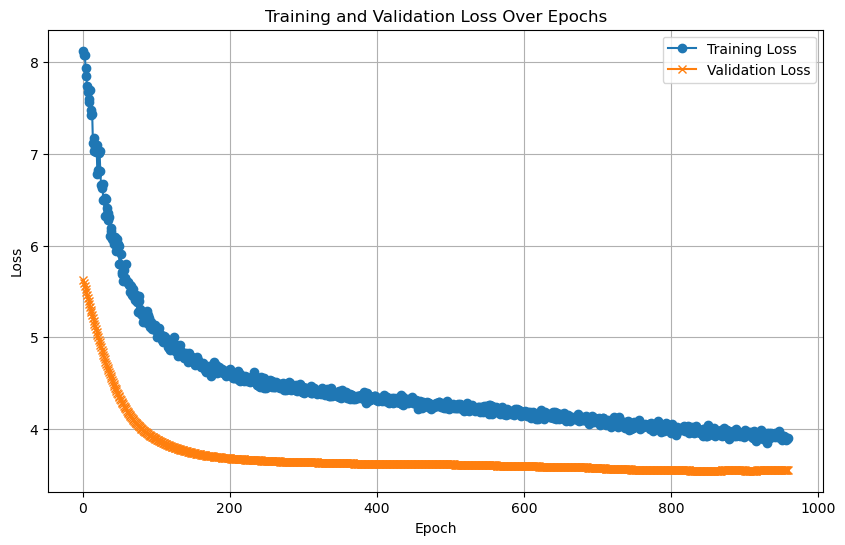

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 4.8894
Test Batch [20/20], Loss: 5.0651

Test Loss: 5.1777


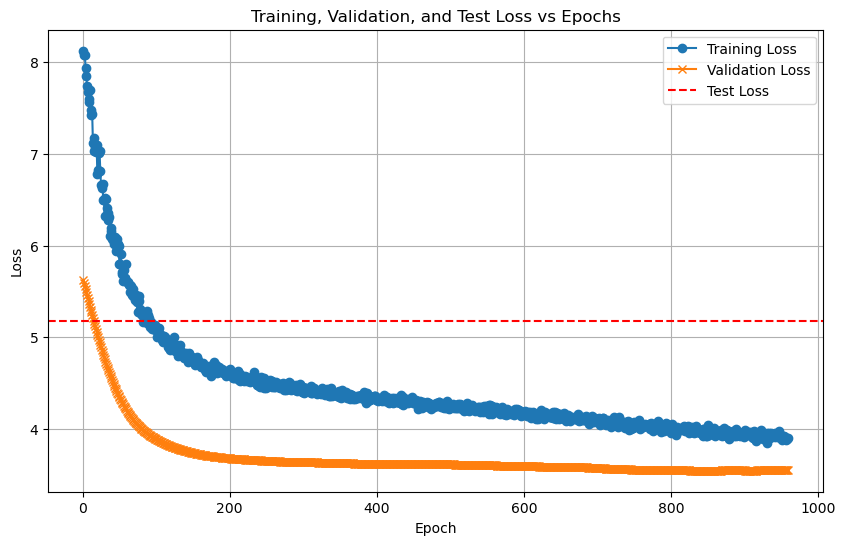

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 38.46%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.50      0.40      0.44         5
           5       0.40      0.40      0.40         5
           6       0.31      0.80      0.44         5
           7       0.17      0.20      0.18         5
           8       0.50      0.80      0.62         5
           9       0.29      0.40      0.33         5
          10       0.83      1.00      0.91         5
          11       0.60      0.60      0.60         5
          12       0.00      0.00      0.00         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6352  |  Val Loss: 2.5986
Validation loss improved from inf to 2.5986.
[Epoch 2/1000] Train Loss: 2.6207  |  Val Loss: 2.5921
Validation loss improved from 2.5986 to 2.5921.
[Epoch 3/1000] Train Loss: 2.6076  |  Val Loss: 2.5861
Validation loss improved from 2.5921 to 2.5861.
[Epoch 4/1000] Train Loss: 2.5972  |  Val Loss: 2.5815
Validation loss improved from 2.5861 to 2.5815.
[Epoch 5/1000] Train Loss: 2.5902  |  Val Loss: 2.5772
Validation loss improved from 2.5815 to 2.5772.
[Epoch 6/1000] Train Loss: 2.5832  |  Val Loss: 2.5735
Validation loss improved from 2.5772 to 2.5735.
[Epoch 7/1000] Train Loss: 2.5766  |  Val Loss: 2.5703
Validation loss improved from 2.5735 to 2.5703.
[Epoch 8/1000] Train Loss: 2.5703  |  Val Loss: 2.5675
Validation loss improved from 2.5703 to 2.5675.
[Epoch 9/1000] Train Loss: 2.5651  |  Val Loss: 2.5649
Validation loss improved from 2.5675 to 2.5649.
[Epoch 10/1000] Train Loss: 2.5602  |  Val Loss: 2.5629
Validation loss impr

[Epoch 17/1000] Train Loss: 2.5329  |  Val Loss: 2.5555
Validation loss improved from 2.5570 to 2.5555.
[Epoch 18/1000] Train Loss: 2.5293  |  Val Loss: 2.5533
Validation loss improved from 2.5555 to 2.5533.
[Epoch 19/1000] Train Loss: 2.5253  |  Val Loss: 2.5514
Validation loss improved from 2.5533 to 2.5514.
[Epoch 20/1000] Train Loss: 2.5226  |  Val Loss: 2.5500
Validation loss improved from 2.5514 to 2.5500.
[Epoch 21/1000] Train Loss: 2.5191  |  Val Loss: 2.5487
Validation loss improved from 2.5500 to 2.5487.
[Epoch 22/1000] Train Loss: 2.5170  |  Val Loss: 2.5475
Validation loss improved from 2.5487 to 2.5475.
[Epoch 23/1000] Train Loss: 2.5147  |  Val Loss: 2.5466
Validation loss improved from 2.5475 to 2.5466.
[Epoch 24/1000] Train Loss: 2.5122  |  Val Loss: 2.5457
Validation loss improved from 2.5466 to 2.5457.


[Epoch 25/1000] Train Loss: 2.5100  |  Val Loss: 2.5448
Validation loss improved from 2.5457 to 2.5448.
[Epoch 26/1000] Train Loss: 2.5081  |  Val Loss: 2.5439
Validation loss improved from 2.5448 to 2.5439.
[Epoch 27/1000] Train Loss: 2.5058  |  Val Loss: 2.5429
Validation loss improved from 2.5439 to 2.5429.
[Epoch 28/1000] Train Loss: 2.5037  |  Val Loss: 2.5418
Validation loss improved from 2.5429 to 2.5418.
[Epoch 29/1000] Train Loss: 2.5016  |  Val Loss: 2.5407
Validation loss improved from 2.5418 to 2.5407.
[Epoch 30/1000] Train Loss: 2.4993  |  Val Loss: 2.5396
Validation loss improved from 2.5407 to 2.5396.
[Epoch 31/1000] Train Loss: 2.4969  |  Val Loss: 2.5385
Validation loss improved from 2.5396 to 2.5385.
[Epoch 32/1000] Train Loss: 2.4943  |  Val Loss: 2.5372
Validation loss improved from 2.5385 to 2.5372.
[Epoch 33/1000] Train Loss: 2.4921  |  Val Loss: 2.5355
Validation loss improved from 2.5372 to 2.5355.
[Epoch 34/1000] Train Loss: 2.4892  |  Val Loss: 2.5335
Validati

[Epoch 47/1000] Train Loss: 2.4671  |  Val Loss: 2.5199
Validation loss improved from 2.5214 to 2.5199.
[Epoch 48/1000] Train Loss: 2.4653  |  Val Loss: 2.5186
Validation loss improved from 2.5199 to 2.5186.
[Epoch 49/1000] Train Loss: 2.4638  |  Val Loss: 2.5174
Validation loss improved from 2.5186 to 2.5174.
[Epoch 50/1000] Train Loss: 2.4621  |  Val Loss: 2.5165
Validation loss improved from 2.5174 to 2.5165.
[Epoch 51/1000] Train Loss: 2.4603  |  Val Loss: 2.5156
Validation loss improved from 2.5165 to 2.5156.
[Epoch 52/1000] Train Loss: 2.4585  |  Val Loss: 2.5148
Validation loss improved from 2.5156 to 2.5148.
[Epoch 53/1000] Train Loss: 2.4566  |  Val Loss: 2.5141
Validation loss improved from 2.5148 to 2.5141.
[Epoch 54/1000] Train Loss: 2.4551  |  Val Loss: 2.5134
Validation loss improved from 2.5141 to 2.5134.


[Epoch 55/1000] Train Loss: 2.4534  |  Val Loss: 2.5124
Validation loss improved from 2.5134 to 2.5124.
[Epoch 56/1000] Train Loss: 2.4521  |  Val Loss: 2.5114
Validation loss improved from 2.5124 to 2.5114.
[Epoch 57/1000] Train Loss: 2.4508  |  Val Loss: 2.5105
Validation loss improved from 2.5114 to 2.5105.
[Epoch 58/1000] Train Loss: 2.4492  |  Val Loss: 2.5095
Validation loss improved from 2.5105 to 2.5095.
[Epoch 59/1000] Train Loss: 2.4477  |  Val Loss: 2.5085
Validation loss improved from 2.5095 to 2.5085.
[Epoch 60/1000] Train Loss: 2.4459  |  Val Loss: 2.5075
Validation loss improved from 2.5085 to 2.5075.
[Epoch 61/1000] Train Loss: 2.4441  |  Val Loss: 2.5063
Validation loss improved from 2.5075 to 2.5063.
[Epoch 62/1000] Train Loss: 2.4422  |  Val Loss: 2.5051
Validation loss improved from 2.5063 to 2.5051.
[Epoch 63/1000] Train Loss: 2.4405  |  Val Loss: 2.5040
Validation loss improved from 2.5051 to 2.5040.
[Epoch 64/1000] Train Loss: 2.4387  |  Val Loss: 2.5028
Validati

[Epoch 78/1000] Train Loss: 2.4122  |  Val Loss: 2.4828
Validation loss improved from 2.4837 to 2.4828.
[Epoch 79/1000] Train Loss: 2.4107  |  Val Loss: 2.4819
Validation loss improved from 2.4828 to 2.4819.
[Epoch 80/1000] Train Loss: 2.4088  |  Val Loss: 2.4807
Validation loss improved from 2.4819 to 2.4807.
[Epoch 81/1000] Train Loss: 2.4073  |  Val Loss: 2.4796
Validation loss improved from 2.4807 to 2.4796.
[Epoch 82/1000] Train Loss: 2.4060  |  Val Loss: 2.4789
Validation loss improved from 2.4796 to 2.4789.
[Epoch 83/1000] Train Loss: 2.4045  |  Val Loss: 2.4782
Validation loss improved from 2.4789 to 2.4782.


[Epoch 84/1000] Train Loss: 2.4029  |  Val Loss: 2.4774
Validation loss improved from 2.4782 to 2.4774.
[Epoch 85/1000] Train Loss: 2.4011  |  Val Loss: 2.4765
Validation loss improved from 2.4774 to 2.4765.
[Epoch 86/1000] Train Loss: 2.3986  |  Val Loss: 2.4755
Validation loss improved from 2.4765 to 2.4755.
[Epoch 87/1000] Train Loss: 2.3967  |  Val Loss: 2.4746
Validation loss improved from 2.4755 to 2.4746.
[Epoch 88/1000] Train Loss: 2.3950  |  Val Loss: 2.4737
Validation loss improved from 2.4746 to 2.4737.
[Epoch 89/1000] Train Loss: 2.3933  |  Val Loss: 2.4727
Validation loss improved from 2.4737 to 2.4727.
[Epoch 90/1000] Train Loss: 2.3915  |  Val Loss: 2.4715
Validation loss improved from 2.4727 to 2.4715.
[Epoch 91/1000] Train Loss: 2.3895  |  Val Loss: 2.4704
Validation loss improved from 2.4715 to 2.4704.
[Epoch 92/1000] Train Loss: 2.3881  |  Val Loss: 2.4693
Validation loss improved from 2.4704 to 2.4693.
[Epoch 93/1000] Train Loss: 2.3865  |  Val Loss: 2.4681
Validati

[Epoch 111/1000] Train Loss: 2.3533  |  Val Loss: 2.4457
Validation loss improved from 2.4473 to 2.4457.
[Epoch 112/1000] Train Loss: 2.3523  |  Val Loss: 2.4448
Validation loss improved from 2.4457 to 2.4448.
[Epoch 113/1000] Train Loss: 2.3515  |  Val Loss: 2.4438
Validation loss improved from 2.4448 to 2.4438.
[Epoch 114/1000] Train Loss: 2.3506  |  Val Loss: 2.4430
Validation loss improved from 2.4438 to 2.4430.
[Epoch 115/1000] Train Loss: 2.3491  |  Val Loss: 2.4420
Validation loss improved from 2.4430 to 2.4420.
[Epoch 116/1000] Train Loss: 2.3474  |  Val Loss: 2.4409
Validation loss improved from 2.4420 to 2.4409.
[Epoch 117/1000] Train Loss: 2.3451  |  Val Loss: 2.4399
Validation loss improved from 2.4409 to 2.4399.
[Epoch 118/1000] Train Loss: 2.3426  |  Val Loss: 2.4390
Validation loss improved from 2.4399 to 2.4390.
[Epoch 119/1000] Train Loss: 2.3396  |  Val Loss: 2.4385
Validation loss improved from 2.4390 to 2.4385.
[Epoch 120/1000] Train Loss: 2.3369  |  Val Loss: 2.438

[Epoch 141/1000] Train Loss: 2.2956  |  Val Loss: 2.4146
Validation loss improved from 2.4154 to 2.4146.
[Epoch 142/1000] Train Loss: 2.2938  |  Val Loss: 2.4138
Validation loss improved from 2.4146 to 2.4138.
[Epoch 143/1000] Train Loss: 2.2921  |  Val Loss: 2.4133
Validation loss improved from 2.4138 to 2.4133.
[Epoch 144/1000] Train Loss: 2.2903  |  Val Loss: 2.4122
Validation loss improved from 2.4133 to 2.4122.
[Epoch 145/1000] Train Loss: 2.2883  |  Val Loss: 2.4106
Validation loss improved from 2.4122 to 2.4106.
[Epoch 146/1000] Train Loss: 2.2865  |  Val Loss: 2.4092
Validation loss improved from 2.4106 to 2.4092.
[Epoch 147/1000] Train Loss: 2.2848  |  Val Loss: 2.4079
Validation loss improved from 2.4092 to 2.4079.
[Epoch 148/1000] Train Loss: 2.2830  |  Val Loss: 2.4070
Validation loss improved from 2.4079 to 2.4070.
[Epoch 149/1000] Train Loss: 2.2806  |  Val Loss: 2.4065
Validation loss improved from 2.4070 to 2.4065.
[Epoch 150/1000] Train Loss: 2.2786  |  Val Loss: 2.405

[Epoch 174/1000] Train Loss: 2.2343  |  Val Loss: 2.3774
Validation loss improved from 2.3783 to 2.3774.
[Epoch 175/1000] Train Loss: 2.2323  |  Val Loss: 2.3771
Validation loss improved from 2.3774 to 2.3771.
[Epoch 176/1000] Train Loss: 2.2298  |  Val Loss: 2.3782
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 177/1000] Train Loss: 2.2288  |  Val Loss: 2.3795
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 178/1000] Train Loss: 2.2280  |  Val Loss: 2.3804
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 179/1000] Train Loss: 2.2270  |  Val Loss: 2.3803
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 180/1000] Train Loss: 2.2259  |  Val Loss: 2.3796
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 181/1000] Train Loss: 2.2244  |  Val Loss: 2.3788
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 182/1000] Train Loss: 2.2224  |  Val Loss: 2.3784
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 183/10

[Epoch 205/1000] Train Loss: 2.1787  |  Val Loss: 2.3540
Validation loss improved from 2.3555 to 2.3540.
[Epoch 206/1000] Train Loss: 2.1765  |  Val Loss: 2.3523
Validation loss improved from 2.3540 to 2.3523.
[Epoch 207/1000] Train Loss: 2.1741  |  Val Loss: 2.3508
Validation loss improved from 2.3523 to 2.3508.
[Epoch 208/1000] Train Loss: 2.1718  |  Val Loss: 2.3492
Validation loss improved from 2.3508 to 2.3492.
[Epoch 209/1000] Train Loss: 2.1695  |  Val Loss: 2.3476
Validation loss improved from 2.3492 to 2.3476.
[Epoch 210/1000] Train Loss: 2.1672  |  Val Loss: 2.3449
Validation loss improved from 2.3476 to 2.3449.
[Epoch 211/1000] Train Loss: 2.1648  |  Val Loss: 2.3412
Validation loss improved from 2.3449 to 2.3412.
[Epoch 212/1000] Train Loss: 2.1628  |  Val Loss: 2.3386
Validation loss improved from 2.3412 to 2.3386.
[Epoch 213/1000] Train Loss: 2.1608  |  Val Loss: 2.3367
Validation loss improved from 2.3386 to 2.3367.
[Epoch 214/1000] Train Loss: 2.1593  |  Val Loss: 2.335

[Epoch 237/1000] Train Loss: 2.1164  |  Val Loss: 2.3227
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 238/1000] Train Loss: 2.1143  |  Val Loss: 2.3228
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 239/1000] Train Loss: 2.1122  |  Val Loss: 2.3232
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 240/1000] Train Loss: 2.1103  |  Val Loss: 2.3250
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 241/1000] Train Loss: 2.1093  |  Val Loss: 2.3271
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 242/1000] Train Loss: 2.1081  |  Val Loss: 2.3271
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 243/1000] Train Loss: 2.1081  |  Val Loss: 2.3258
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 244/1000] Train Loss: 2.1078  |  Val Loss: 2.3246
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 245/1000] Train Loss: 2.1081  |  Val Loss: 2.3233
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 270/1000] Train Loss: 2.0527  |  Val Loss: 2.3008
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 271/1000] Train Loss: 2.0503  |  Val Loss: 2.2994
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 272/1000] Train Loss: 2.0477  |  Val Loss: 2.2981
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 273/1000] Train Loss: 2.0452  |  Val Loss: 2.2972
Validation loss improved from 2.2972 to 2.2972.
[Epoch 274/1000] Train Loss: 2.0432  |  Val Loss: 2.2958
Validation loss improved from 2.2972 to 2.2958.
[Epoch 275/1000] Train Loss: 2.0409  |  Val Loss: 2.2905
Validation loss improved from 2.2958 to 2.2905.
[Epoch 276/1000] Train Loss: 2.0367  |  Val Loss: 2.2815
Validation loss improved from 2.2905 to 2.2815.
[Epoch 277/1000] Train Loss: 2.0360  |  Val Loss: 2.2763
Validation loss improved from 2.2815 to 2.2763.
[Epoch 278/1000] Train Loss: 2.0357  |  Val Loss: 2.2736
Validation loss improved from 2.2763 to 2.2736.
[Epoch 279/1000] Train Loss: 2.035

[Epoch 301/1000] Train Loss: 1.9945  |  Val Loss: 2.2621
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 302/1000] Train Loss: 1.9924  |  Val Loss: 2.2637
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 303/1000] Train Loss: 1.9894  |  Val Loss: 2.2653
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 304/1000] Train Loss: 1.9870  |  Val Loss: 2.2673
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 305/1000] Train Loss: 1.9839  |  Val Loss: 2.2699
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 306/1000] Train Loss: 1.9823  |  Val Loss: 2.2698
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 307/1000] Train Loss: 1.9798  |  Val Loss: 2.2650
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 308/1000] Train Loss: 1.9777  |  Val Loss: 2.2614
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 309/1000] Train Loss: 1.9760  |  Val Loss: 2.2587
Validation loss improved from 2.2595 to 2.2587.
[Epoch

[Epoch 336/1000] Train Loss: 1.9248  |  Val Loss: 2.2464
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 337/1000] Train Loss: 1.9219  |  Val Loss: 2.2543
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 338/1000] Train Loss: 1.9226  |  Val Loss: 2.2602
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 339/1000] Train Loss: 1.9223  |  Val Loss: 2.2628
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 340/1000] Train Loss: 1.9214  |  Val Loss: 2.2640
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 341/1000] Train Loss: 1.9202  |  Val Loss: 2.2648
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 342/1000] Train Loss: 1.9183  |  Val Loss: 2.2637
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 343/1000] Train Loss: 1.9159  |  Val Loss: 2.2597
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 344/1000] Train Loss: 1.9116  |  Val Loss: 2.2529
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 368/1000] Train Loss: 1.8646  |  Val Loss: 2.2321
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 369/1000] Train Loss: 1.8614  |  Val Loss: 2.2242
Validation loss improved from 2.2275 to 2.2242.
[Epoch 370/1000] Train Loss: 1.8584  |  Val Loss: 2.2190
Validation loss improved from 2.2242 to 2.2190.
[Epoch 371/1000] Train Loss: 1.8569  |  Val Loss: 2.2163
Validation loss improved from 2.2190 to 2.2163.
[Epoch 372/1000] Train Loss: 1.8555  |  Val Loss: 2.2152
Validation loss improved from 2.2163 to 2.2152.
[Epoch 373/1000] Train Loss: 1.8543  |  Val Loss: 2.2153
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 374/1000] Train Loss: 1.8529  |  Val Loss: 2.2168
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 375/1000] Train Loss: 1.8509  |  Val Loss: 2.2187
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 376/1000] Train Loss: 1.8489  |  Val Loss: 2.2198
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 377/1000] Train L

[Epoch 399/1000] Train Loss: 1.8059  |  Val Loss: 2.2057
Validation loss improved from 2.2069 to 2.2057.
[Epoch 400/1000] Train Loss: 1.8044  |  Val Loss: 2.2059
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 401/1000] Train Loss: 1.8025  |  Val Loss: 2.2068
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 402/1000] Train Loss: 1.8009  |  Val Loss: 2.2079
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 403/1000] Train Loss: 1.7994  |  Val Loss: 2.2085
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 404/1000] Train Loss: 1.7978  |  Val Loss: 2.2078
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 405/1000] Train Loss: 1.7958  |  Val Loss: 2.2065
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 406/1000] Train Loss: 1.7936  |  Val Loss: 2.2041
Validation loss improved from 2.2057 to 2.2041.
[Epoch 407/1000] Train Loss: 1.7905  |  Val Loss: 2.1998
Validation loss improved from 2.2041 to 2.1998.
[Epoch 408/1000] Tr

[Epoch 428/1000] Train Loss: 1.7508  |  Val Loss: 2.1897
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 429/1000] Train Loss: 1.7493  |  Val Loss: 2.1908
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 430/1000] Train Loss: 1.7478  |  Val Loss: 2.1920
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 431/1000] Train Loss: 1.7465  |  Val Loss: 2.1924
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 432/1000] Train Loss: 1.7455  |  Val Loss: 2.1922
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 433/1000] Train Loss: 1.7443  |  Val Loss: 2.1908
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 434/1000] Train Loss: 1.7425  |  Val Loss: 2.1888
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 435/1000] Train Loss: 1.7407  |  Val Loss: 2.1861
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 436/1000] Train Loss: 1.7387  |  Val Loss: 2.1832
Validation loss improved from 2.1839 to 2.1832.

[Epoch 458/1000] Train Loss: 1.6995  |  Val Loss: 2.1716
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 459/1000] Train Loss: 1.6990  |  Val Loss: 2.1755
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 460/1000] Train Loss: 1.6975  |  Val Loss: 2.1809
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 461/1000] Train Loss: 1.6965  |  Val Loss: 2.1850
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 462/1000] Train Loss: 1.6950  |  Val Loss: 2.1885
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 463/1000] Train Loss: 1.6932  |  Val Loss: 2.1911
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 464/1000] Train Loss: 1.6916  |  Val Loss: 2.1914
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 465/1000] Train Loss: 1.6898  |  Val Loss: 2.1910
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 466/1000] Train Loss: 1.6872  |  Val Loss: 2.1905
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 490/1000] Train Loss: 1.6436  |  Val Loss: 2.1713
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 491/1000] Train Loss: 1.6419  |  Val Loss: 2.1716
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 492/1000] Train Loss: 1.6400  |  Val Loss: 2.1713
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 493/1000] Train Loss: 1.6380  |  Val Loss: 2.1706
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 494/1000] Train Loss: 1.6361  |  Val Loss: 2.1687
Validation loss improved from 2.1700 to 2.1687.
[Epoch 495/1000] Train Loss: 1.6342  |  Val Loss: 2.1661
Validation loss improved from 2.1687 to 2.1661.
[Epoch 496/1000] Train Loss: 1.6323  |  Val Loss: 2.1646
Validation loss improved from 2.1661 to 2.1646.
[Epoch 497/1000] Train Loss: 1.6305  |  Val Loss: 2.1644
Validation loss improved from 2.1646 to 2.1644.
[Epoch 498/1000] Train Loss: 1.6287  |  Val Loss: 2.1647
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 499/1000] Trai

[Epoch 522/1000] Train Loss: 1.5887  |  Val Loss: 2.1765
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 523/1000] Train Loss: 1.5871  |  Val Loss: 2.1780
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 524/1000] Train Loss: 1.5857  |  Val Loss: 2.1760
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 525/1000] Train Loss: 1.5841  |  Val Loss: 2.1739
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 526/1000] Train Loss: 1.5824  |  Val Loss: 2.1729
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 527/1000] Train Loss: 1.5806  |  Val Loss: 2.1728
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 528/1000] Train Loss: 1.5788  |  Val Loss: 2.1714
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 529/1000] Train Loss: 1.5769  |  Val Loss: 2.1705
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 530/1000] Train Loss: 1.5753  |  Val Loss: 2.1695
!! Validation loss did NOT improve !! Patience:

[Epoch 552/1000] Train Loss: 1.5368  |  Val Loss: 2.1787
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 553/1000] Train Loss: 1.5355  |  Val Loss: 2.1775
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 554/1000] Train Loss: 1.5339  |  Val Loss: 2.1758
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 555/1000] Train Loss: 1.5323  |  Val Loss: 2.1748
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 556/1000] Train Loss: 1.5315  |  Val Loss: 2.1740
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 557/1000] Train Loss: 1.5314  |  Val Loss: 2.1748
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 558/1000] Train Loss: 1.5331  |  Val Loss: 2.1772
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 559/1000] Train Loss: 1.5334  |  Val Loss: 2.1749
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 560/1000] Train Loss: 1.5286  |  Val Loss: 2.1660
!! Validation loss did NOT improve !! Patience:

[Epoch 583/1000] Train Loss: 1.4941  |  Val Loss: 2.1954
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 584/1000] Train Loss: 1.4919  |  Val Loss: 2.1916
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 585/1000] Train Loss: 1.4898  |  Val Loss: 2.1867
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 586/1000] Train Loss: 1.4878  |  Val Loss: 2.1802
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 587/1000] Train Loss: 1.4862  |  Val Loss: 2.1737
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 588/1000] Train Loss: 1.4844  |  Val Loss: 2.1713
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 589/1000] Train Loss: 1.4834  |  Val Loss: 2.1712
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 590/1000] Train Loss: 1.4825  |  Val Loss: 2.1712
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 591/1000] Train Loss: 1.4815  |  Val Loss: 2.1700
!! Validation loss did NOT improve !! Patience:

[Epoch 613/1000] Train Loss: 1.4470  |  Val Loss: 2.1572
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 614/1000] Train Loss: 1.4459  |  Val Loss: 2.1518
Validation loss improved from 2.1528 to 2.1518.
[Epoch 615/1000] Train Loss: 1.4438  |  Val Loss: 2.1483
Validation loss improved from 2.1518 to 2.1483.
[Epoch 616/1000] Train Loss: 1.4426  |  Val Loss: 2.1446
Validation loss improved from 2.1483 to 2.1446.
[Epoch 617/1000] Train Loss: 1.4417  |  Val Loss: 2.1415
Validation loss improved from 2.1446 to 2.1415.
[Epoch 618/1000] Train Loss: 1.4404  |  Val Loss: 2.1385
Validation loss improved from 2.1415 to 2.1385.
[Epoch 619/1000] Train Loss: 1.4397  |  Val Loss: 2.1331
Validation loss improved from 2.1385 to 2.1331.
[Epoch 620/1000] Train Loss: 1.4389  |  Val Loss: 2.1304
Validation loss improved from 2.1331 to 2.1304.
[Epoch 621/1000] Train Loss: 1.4375  |  Val Loss: 2.1309
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 622/1000] Train Loss: 1.4354  |  Va

[Epoch 645/1000] Train Loss: 1.4108  |  Val Loss: 2.1549
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 646/1000] Train Loss: 1.4077  |  Val Loss: 2.1533
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 647/1000] Train Loss: 1.4040  |  Val Loss: 2.1528
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 648/1000] Train Loss: 1.4010  |  Val Loss: 2.1536
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 649/1000] Train Loss: 1.3984  |  Val Loss: 2.1542
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 650/1000] Train Loss: 1.3965  |  Val Loss: 2.1536
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 651/1000] Train Loss: 1.3946  |  Val Loss: 2.1522
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 652/1000] Train Loss: 1.3930  |  Val Loss: 2.1502
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 653/1000] Train Loss: 1.3914  |  Val Loss: 2.1504
!! Validation loss did NOT improve !! Patience:

[Epoch 675/1000] Train Loss: 1.3663  |  Val Loss: 2.1715
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 676/1000] Train Loss: 1.3642  |  Val Loss: 2.1714
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 677/1000] Train Loss: 1.3625  |  Val Loss: 2.1732
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 678/1000] Train Loss: 1.3605  |  Val Loss: 2.1764
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 679/1000] Train Loss: 1.3583  |  Val Loss: 2.1768
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 680/1000] Train Loss: 1.3562  |  Val Loss: 2.1760
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 681/1000] Train Loss: 1.3546  |  Val Loss: 2.1747
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 682/1000] Train Loss: 1.3528  |  Val Loss: 2.1721
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 683/1000] Train Loss: 1.3507  |  Val Loss: 2.1688
!! Validation loss did NOT improve !! Patience:

[Epoch 708/1000] Train Loss: 1.3215  |  Val Loss: 2.2246
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 709/1000] Train Loss: 1.3205  |  Val Loss: 2.2343
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 710/1000] Train Loss: 1.3187  |  Val Loss: 2.2377
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 711/1000] Train Loss: 1.3169  |  Val Loss: 2.2369
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 712/1000] Train Loss: 1.3154  |  Val Loss: 2.2332
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 713/1000] Train Loss: 1.3139  |  Val Loss: 2.2320
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 714/1000] Train Loss: 1.3128  |  Val Loss: 2.2335
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 715/1000] Train Loss: 1.3121  |  Val Loss: 2.2353
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 716/1000] Train Loss: 1.3115  |  Val Loss: 2.2325
!! Validation loss did NOT improve !! Patience:

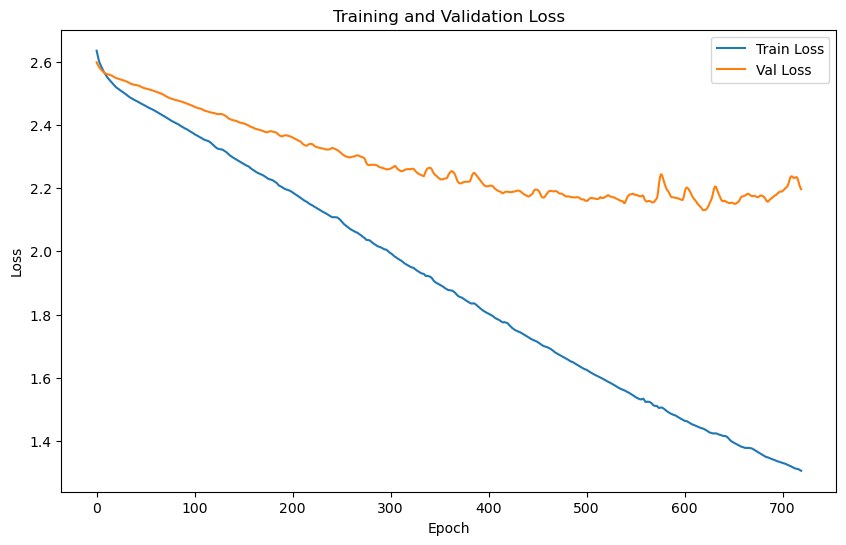

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.1104 | Test Accuracy: 31.26%


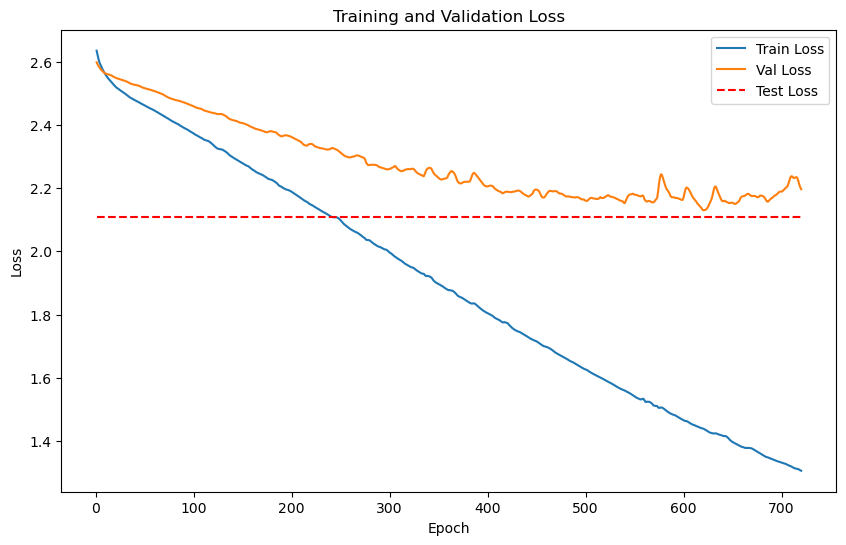

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)


Train embeddings shape: (130, 64), 
Train labels shape: (130,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5016, 64), 
Test labels shape: (5016,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}
Training batch size: 130


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5309
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6202
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5309, Avg Val Loss: 0.5601

Validation loss improved from inf to 0.5601. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.5293
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.6192
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5293, Avg Val Loss: 0.5596

Validation loss improved from 0.5601 to 0.5596. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5284
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.6179
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5284, Avg Val Loss: 0.5590

Validation loss improved from 0.5596 to 0.5590. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5262
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6170
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5262, Avg Val Loss: 0.5585

Validation loss improved from 0.5590 to 0.5585. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.5288
LOG: Epoch [5/2000] - Validation


    Batch [1/2], Val Loss: 0.6163
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5288, Avg Val Loss: 0.5582

Validation loss improved from 0.5585 to 0.5582. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.5300
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.6157
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5300, Avg Val Loss: 0.5578

Validation loss improved from 0.5582 to 0.5578. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.5240
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.6155
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5240, Avg Val Loss: 0.5577

Validation loss improved from 0.5578 to 0.5577. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.5246
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.6152
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5246, Avg Val Loss: 0.5576

Validation loss improved from 0.5577 to 0.5576. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5247
LOG: Epoch [9/2000] - Validation


    Batch [1/2], Val Loss: 0.6143
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5247, Avg Val Loss: 0.5572

Validation loss improved from 0.5576 to 0.5572. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.5215
LOG: Epoch [10/2000] - Validation


    Batch [1/2], Val Loss: 0.6133
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5215, Avg Val Loss: 0.5566

Validation loss improved from 0.5572 to 0.5566. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.5220
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.6118
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5220, Avg Val Loss: 0.5559

Validation loss improved from 0.5566 to 0.5559. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.5232
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.6105
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5232, Avg Val Loss: 0.5553

Validation loss improved from 0.5559 to 0.5553. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.5294
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.6091
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5294, Avg Val Loss: 0.5546

Validation loss improved from 0.5553 to 0.5546. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.5199
LOG: Epoch [14/2000] - Validation


    Batch [1/2], Val Loss: 0.6076
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5199, Avg Val Loss: 0.5538

Validation loss improved from 0.5546 to 0.5538. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5206
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.6060
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5206, Avg Val Loss: 0.5530

Validation loss improved from 0.5538 to 0.5530. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.5181
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.6042
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5181, Avg Val Loss: 0.5521

Validation loss improved from 0.5530 to 0.5521. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.5236
LOG: Epoch [17/2000] - Validation


    Batch [1/2], Val Loss: 0.6030
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5236, Avg Val Loss: 0.5515

Validation loss improved from 0.5521 to 0.5515. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5201
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.6017
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5201, Avg Val Loss: 0.5509

Validation loss improved from 0.5515 to 0.5509. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5173
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.6000
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5173, Avg Val Loss: 0.5500

Validation loss improved from 0.5509 to 0.5500. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.5182
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5979
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5182, Avg Val Loss: 0.5489

Validation loss improved from 0.5500 to 0.5489. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.5162
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5961
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5162, Avg Val Loss: 0.5481

Validation loss improved from 0.5489 to 0.5481. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.5212
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5942
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5212, Avg Val Loss: 0.5471

Validation loss improved from 0.5481 to 0.5471. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.5188
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5920
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5188, Avg Val Loss: 0.5460

Validation loss improved from 0.5471 to 0.5460. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.5151
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.5894
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5151, Avg Val Loss: 0.5447

Validation loss improved from 0.5460 to 0.5447. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.5137
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.5871
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5137, Avg Val Loss: 0.5436

Validation loss improved from 0.5447 to 0.5436. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.5125
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.5859
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5125, Avg Val Loss: 0.5429

Validation loss improved from 0.5436 to 0.5429. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.5201
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5845
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5201, Avg Val Loss: 0.5423

Validation loss improved from 0.5429 to 0.5423. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.5160
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5826
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5160, Avg Val Loss: 0.5413

Validation loss improved from 0.5423 to 0.5413. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5159
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.5810
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5159, Avg Val Loss: 0.5405

Validation loss improved from 0.5413 to 0.5405. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.5170
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.5794
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5170, Avg Val Loss: 0.5397

Validation loss improved from 0.5405 to 0.5397. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.5140
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.5776
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5140, Avg Val Loss: 0.5388

Validation loss improved from 0.5397 to 0.5388. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.5147
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.5759
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5147, Avg Val Loss: 0.5379

Validation loss improved from 0.5388 to 0.5379. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.5161
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5741
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5161, Avg Val Loss: 0.5370

Validation loss improved from 0.5379 to 0.5370. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.5153
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5723
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5153, Avg Val Loss: 0.5362

Validation loss improved from 0.5370 to 0.5362. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.5130
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5707
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5130, Avg Val Loss: 0.5354

Validation loss improved from 0.5362 to 0.5354. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.5148
LOG: Epoch [36/2000] - Validation


    Batch [1/2], Val Loss: 0.5688
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5148, Avg Val Loss: 0.5344

Validation loss improved from 0.5354 to 0.5344. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.5156
LOG: Epoch [37/2000] - Validation


    Batch [1/2], Val Loss: 0.5668
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5156, Avg Val Loss: 0.5334

Validation loss improved from 0.5344 to 0.5334. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.5126
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.5649
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5126, Avg Val Loss: 0.5324

Validation loss improved from 0.5334 to 0.5324. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5161
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5630
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5161, Avg Val Loss: 0.5315

Validation loss improved from 0.5324 to 0.5315. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.5131
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5613
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5131, Avg Val Loss: 0.5307

Validation loss improved from 0.5315 to 0.5307. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.5097
LOG: Epoch [41/2000] - Validation


    Batch [1/2], Val Loss: 0.5597
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5097, Avg Val Loss: 0.5298

Validation loss improved from 0.5307 to 0.5298. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.5122
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5582
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5122, Avg Val Loss: 0.5291

Validation loss improved from 0.5298 to 0.5291. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.5106
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5568
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5106, Avg Val Loss: 0.5284

Validation loss improved from 0.5291 to 0.5284. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.5106
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5555
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5106, Avg Val Loss: 0.5277

Validation loss improved from 0.5284 to 0.5277. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.5128
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5542
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5128, Avg Val Loss: 0.5271

Validation loss improved from 0.5277 to 0.5271. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.5083
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.5530
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5083, Avg Val Loss: 0.5265

Validation loss improved from 0.5271 to 0.5265. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.5077
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.5519
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5077, Avg Val Loss: 0.5259

Validation loss improved from 0.5265 to 0.5259. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.5088
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5509
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5088, Avg Val Loss: 0.5254

Validation loss improved from 0.5259 to 0.5254. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.5093
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5500
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5093, Avg Val Loss: 0.5250

Validation loss improved from 0.5254 to 0.5250. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5098
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.5492
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5098, Avg Val Loss: 0.5246

Validation loss improved from 0.5250 to 0.5246. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.5077
LOG: Epoch [51/2000] - Validation


    Batch [1/2], Val Loss: 0.5484
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5077, Avg Val Loss: 0.5242

Validation loss improved from 0.5246 to 0.5242. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.5084
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5476
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5084, Avg Val Loss: 0.5238

Validation loss improved from 0.5242 to 0.5238. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.5074
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5469
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5074, Avg Val Loss: 0.5234

Validation loss improved from 0.5238 to 0.5234. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.5107
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.5462
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5107, Avg Val Loss: 0.5231

Validation loss improved from 0.5234 to 0.5231. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.5103
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5454
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5103, Avg Val Loss: 0.5227

Validation loss improved from 0.5231 to 0.5227. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.5090
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5447
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5090, Avg Val Loss: 0.5223

Validation loss improved from 0.5227 to 0.5223. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.5090
LOG: Epoch [57/2000] - Validation


    Batch [1/2], Val Loss: 0.5440
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5090, Avg Val Loss: 0.5220

Validation loss improved from 0.5223 to 0.5220. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.5085
LOG: Epoch [58/2000] - Validation


    Batch [1/2], Val Loss: 0.5434
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.5217

Validation loss improved from 0.5220 to 0.5217. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.5085
LOG: Epoch [59/2000] - Validation


    Batch [1/2], Val Loss: 0.5429
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.5214

Validation loss improved from 0.5217 to 0.5214. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.5111
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.5423
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5111, Avg Val Loss: 0.5212

Validation loss improved from 0.5214 to 0.5212. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.5044
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.5418
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5044, Avg Val Loss: 0.5209

Validation loss improved from 0.5212 to 0.5209. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.5060
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5413
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5206

Validation loss improved from 0.5209 to 0.5206. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.5030
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5408
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.5204

Validation loss improved from 0.5206 to 0.5204. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.5058
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.5403
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5058, Avg Val Loss: 0.5202

Validation loss improved from 0.5204 to 0.5202. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.5069
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.5399
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5069, Avg Val Loss: 0.5199

Validation loss improved from 0.5202 to 0.5199. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.5050
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5394
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5197

Validation loss improved from 0.5199 to 0.5197. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.5068
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5390
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5068, Avg Val Loss: 0.5195

Validation loss improved from 0.5197 to 0.5195. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.5068
LOG: Epoch [68/2000] - Validation


    Batch [1/2], Val Loss: 0.5387
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5068, Avg Val Loss: 0.5194

Validation loss improved from 0.5195 to 0.5194. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.5061
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5384


    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.5061, Avg Val Loss: 0.5192

Validation loss improved from 0.5194 to 0.5192. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.5057
LOG: Epoch [70/2000] - Validation


    Batch [1/2], Val Loss: 0.5382
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.5057, Avg Val Loss: 0.5191

Validation loss improved from 0.5192 to 0.5191. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.5018
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5379
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.5018, Avg Val Loss: 0.5189

Validation loss improved from 0.5191 to 0.5189. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.5042
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5376
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.5188

Validation loss improved from 0.5189 to 0.5188. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.5084
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5373
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.5084, Avg Val Loss: 0.5187

Validation loss improved from 0.5188 to 0.5187. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.5032
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5371
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5032, Avg Val Loss: 0.5185

Validation loss improved from 0.5187 to 0.5185. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.5018
LOG: Epoch [75/2000] - Validation


    Batch [1/2], Val Loss: 0.5368
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.5018, Avg Val Loss: 0.5184

Validation loss improved from 0.5185 to 0.5184. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.5366
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5183

Validation loss improved from 0.5184 to 0.5183. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.5029
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.5364
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.5029, Avg Val Loss: 0.5182

Validation loss improved from 0.5183 to 0.5182. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.5050
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.5363
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5181

Validation loss improved from 0.5182 to 0.5181. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [79/2000] - Validation


    Batch [1/2], Val Loss: 0.5361
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.5180

Validation loss improved from 0.5181 to 0.5180. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.5025
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5359
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.5025, Avg Val Loss: 0.5180

Validation loss improved from 0.5180 to 0.5180. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.5053
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5358
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.5053, Avg Val Loss: 0.5179

Validation loss improved from 0.5180 to 0.5179. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.5028
LOG: Epoch [82/2000] - Validation


    Batch [1/2], Val Loss: 0.5357
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.5028, Avg Val Loss: 0.5178

Validation loss improved from 0.5179 to 0.5178. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.5042
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5356


    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.5178

Validation loss improved from 0.5178 to 0.5178. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.5354
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.5177

Validation loss improved from 0.5178 to 0.5177. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.5050
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5353
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5177

Validation loss improved from 0.5177 to 0.5177. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5353
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5176

Validation loss improved from 0.5177 to 0.5176. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4993
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.5352
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4993, Avg Val Loss: 0.5176

Validation loss improved from 0.5176 to 0.5176. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.5017
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5351
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.5017, Avg Val Loss: 0.5175

Validation loss improved from 0.5176 to 0.5175. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5349
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.5175

Validation loss improved from 0.5175 to 0.5175. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.5023
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5348
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.5023, Avg Val Loss: 0.5174

Validation loss improved from 0.5175 to 0.5174. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5346
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5173

Validation loss improved from 0.5174 to 0.5173. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [92/2000] - Validation


    Batch [1/2], Val Loss: 0.5345
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.5172

Validation loss improved from 0.5173 to 0.5172. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5343
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.5171

Validation loss improved from 0.5172 to 0.5171. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.5010
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5341
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.5010, Avg Val Loss: 0.5171

Validation loss improved from 0.5171 to 0.5171. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4982
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5340
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4982, Avg Val Loss: 0.5170

Validation loss improved from 0.5171 to 0.5170. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [96/2000] - Validation


    Batch [1/2], Val Loss: 0.5338
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5169

Validation loss improved from 0.5170 to 0.5169. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.5337
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.5168

Validation loss improved from 0.5169 to 0.5168. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5336
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5168

Validation loss improved from 0.5168 to 0.5168. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4990
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5334
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4990, Avg Val Loss: 0.5167

Validation loss improved from 0.5168 to 0.5167. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.5004
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5333
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.5004, Avg Val Loss: 0.5167

Validation loss improved from 0.5167 to 0.5167. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [101/2000] - Validation


    Batch [1/2], Val Loss: 0.5332
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5166

Validation loss improved from 0.5167 to 0.5166. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.4990
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.5331
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4990, Avg Val Loss: 0.5165

Validation loss improved from 0.5166 to 0.5165. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5329
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.5164

Validation loss improved from 0.5165 to 0.5164. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.5328
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.5164

Validation loss improved from 0.5164 to 0.5164. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5326
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.5163

Validation loss improved from 0.5164 to 0.5163. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.5005
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5325
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.5005, Avg Val Loss: 0.5162

Validation loss improved from 0.5163 to 0.5162. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.5020
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.5323
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.5020, Avg Val Loss: 0.5162

Validation loss improved from 0.5162 to 0.5162. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.5323
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.5161

Validation loss improved from 0.5162 to 0.5161. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.5323
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5161

Validation loss improved from 0.5161 to 0.5161. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5322
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5161

Validation loss improved from 0.5161 to 0.5161. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.4991
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.5322
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4991, Avg Val Loss: 0.5161

Validation loss improved from 0.5161 to 0.5161. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5321
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5161

Validation loss improved from 0.5161 to 0.5161. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4969
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5321
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4969, Avg Val Loss: 0.5160

Validation loss improved from 0.5161 to 0.5160. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [114/2000] - Validation


    Batch [1/2], Val Loss: 0.5320
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5160

Validation loss improved from 0.5160 to 0.5160. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.4968
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.5318
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4968, Avg Val Loss: 0.5159

Validation loss improved from 0.5160 to 0.5159. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.5317
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5158

Validation loss improved from 0.5159 to 0.5158. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.5315
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5158

Validation loss improved from 0.5158 to 0.5158. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.5314
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5157

Validation loss improved from 0.5158 to 0.5157. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.5312
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5156

Validation loss improved from 0.5157 to 0.5156. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5310
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.5155

Validation loss improved from 0.5156 to 0.5155. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.5308
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5154

Validation loss improved from 0.5155 to 0.5154. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.5307
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5153

Validation loss improved from 0.5154 to 0.5153. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5305
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5153

Validation loss improved from 0.5153 to 0.5153. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.5304
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5152

Validation loss improved from 0.5153 to 0.5152. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.5302
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5151

Validation loss improved from 0.5152 to 0.5151. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.5301
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5151

Validation loss improved from 0.5151 to 0.5151. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5300
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.5150

Validation loss improved from 0.5151 to 0.5150. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.5299
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5150

Validation loss improved from 0.5150 to 0.5150. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.5298
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5149

Validation loss improved from 0.5150 to 0.5149. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.5297
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5149

Validation loss improved from 0.5149 to 0.5149. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.5297
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [132/2000] - Validation


    Batch [1/2], Val Loss: 0.5298
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.5298
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.5299
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.5298
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.5298
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.5298
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.5149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.5297
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5148

Validation loss improved from 0.5149 to 0.5148. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.5296
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5148

Validation loss improved from 0.5148 to 0.5148. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [140/2000] - Validation


    Batch [1/2], Val Loss: 0.5296
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5148

Validation loss improved from 0.5148 to 0.5148. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.5295
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5147

Validation loss improved from 0.5148 to 0.5147. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.5294
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5147

Validation loss improved from 0.5147 to 0.5147. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [143/2000] - Validation


    Batch [1/2], Val Loss: 0.5293
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5146

Validation loss improved from 0.5147 to 0.5146. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [144/2000] - Validation


    Batch [1/2], Val Loss: 0.5292
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5146

Validation loss improved from 0.5146 to 0.5146. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.5292
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5146

Validation loss improved from 0.5146 to 0.5146. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5145

Validation loss improved from 0.5146 to 0.5145. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.5290
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.5145

Validation loss improved from 0.5145 to 0.5145. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [148/2000] - Validation


    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.5144

Validation loss improved from 0.5145 to 0.5144. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.5288
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.5144

Validation loss improved from 0.5144 to 0.5144. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5144

Validation loss improved from 0.5144 to 0.5144. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5144

Validation loss improved from 0.5144 to 0.5144. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.5288
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5144

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5144

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.5290
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5145

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.5146

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.5292
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5146

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.5292
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5146

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [158/2000] - Validation


    Batch [1/2], Val Loss: 0.5292
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5146

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [159/2000] - Validation


    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5145

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.5290
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5145

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5145

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.5288


    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5144

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.5143

Validation loss improved from 0.5144 to 0.5143. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.5286
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.5143

Validation loss improved from 0.5143 to 0.5143. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.5143

Validation loss improved from 0.5143 to 0.5143. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5142

Validation loss improved from 0.5143 to 0.5142. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.5142

Validation loss improved from 0.5142 to 0.5142. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5142

Validation loss improved from 0.5142 to 0.5142. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.5142

Validation loss improved from 0.5142 to 0.5142. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.5283
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.5142

Validation loss improved from 0.5142 to 0.5142. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.5282
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.5141

Validation loss improved from 0.5142 to 0.5141. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.5281
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.5141

Validation loss improved from 0.5141 to 0.5141. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.5280
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.5140

Validation loss improved from 0.5141 to 0.5140. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.5279
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.5140

Validation loss improved from 0.5140 to 0.5140. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [175/2000] - Validation


    Batch [1/2], Val Loss: 0.5278
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.5139

Validation loss improved from 0.5140 to 0.5139. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [176/2000] - Validation


    Batch [1/2], Val Loss: 0.5276
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.5138

Validation loss improved from 0.5139 to 0.5138. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.5275
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.5137

Validation loss improved from 0.5138 to 0.5137. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.5274
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.5137

Validation loss improved from 0.5137 to 0.5137. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.5273
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.5136

Validation loss improved from 0.5137 to 0.5136. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [180/2000] - Validation


    Batch [1/2], Val Loss: 0.5272
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.5136

Validation loss improved from 0.5136 to 0.5136. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.5272
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.5136

Validation loss improved from 0.5136 to 0.5136. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.5271
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.5136

Validation loss improved from 0.5136 to 0.5136. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.5270
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.5135

Validation loss improved from 0.5136 to 0.5135. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.5269
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.5134

Validation loss improved from 0.5135 to 0.5134. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [185/2000] - Validation


    Batch [1/2], Val Loss: 0.5268
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.5134

Validation loss improved from 0.5134 to 0.5134. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.5268
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.5134

Validation loss improved from 0.5134 to 0.5134. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.5268
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.5134

Validation loss improved from 0.5134 to 0.5134. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.5268
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5134

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.5268
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.5134

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.5268
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5134

Validation loss improved from 0.5134 to 0.5134. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.5267
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.5134

Validation loss improved from 0.5134 to 0.5134. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [192/2000] - Validation


    Batch [1/2], Val Loss: 0.5266
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.5133

Validation loss improved from 0.5134 to 0.5133. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [193/2000] - Validation


    Batch [1/2], Val Loss: 0.5265
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.5132

Validation loss improved from 0.5133 to 0.5132. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.5263
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.5132

Validation loss improved from 0.5132 to 0.5132. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.5262
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.5131

Validation loss improved from 0.5132 to 0.5131. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.5260
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.5130

Validation loss improved from 0.5131 to 0.5130. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.5259
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.5129

Validation loss improved from 0.5130 to 0.5129. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.5257
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.5129

Validation loss improved from 0.5129 to 0.5129. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.5257
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.5128

Validation loss improved from 0.5129 to 0.5128. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.5256
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.5128

Validation loss improved from 0.5128 to 0.5128. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [201/2000] - Validation


    Batch [1/2], Val Loss: 0.5257
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.5128

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.5129

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.5129

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [204/2000] - Validation


    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5129

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5129

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.5129

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [207/2000] - Validation


    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.5129

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.5129

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.5129

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.5257
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.5129

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.5257
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.5128

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.5255
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.5127

Validation loss improved from 0.5128 to 0.5127. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.5126

Validation loss improved from 0.5127 to 0.5126. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [214/2000] - Validation


    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.5126

Validation loss improved from 0.5126 to 0.5126. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.5250
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5125

Validation loss improved from 0.5126 to 0.5125. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [216/2000] - Validation


    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5124

Validation loss improved from 0.5125 to 0.5124. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.5246
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.5123

Validation loss improved from 0.5124 to 0.5123. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.5245
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5122

Validation loss improved from 0.5123 to 0.5122. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.5243
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.5121

Validation loss improved from 0.5122 to 0.5121. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [220/2000] - Validation


    Batch [1/2], Val Loss: 0.5241
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5121

Validation loss improved from 0.5121 to 0.5121. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.5240
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.5120

Validation loss improved from 0.5121 to 0.5120. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.5240
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5120

Validation loss improved from 0.5120 to 0.5120. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.5239
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5120

Validation loss improved from 0.5120 to 0.5120. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.5238
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5119

Validation loss improved from 0.5120 to 0.5119. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.5118

Validation loss improved from 0.5119 to 0.5118. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.5236
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.5118

Validation loss improved from 0.5118 to 0.5118. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.5235
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5117

Validation loss improved from 0.5118 to 0.5117. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.5233
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.5117

Validation loss improved from 0.5117 to 0.5117. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.5232
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5116

Validation loss improved from 0.5117 to 0.5116. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.5229
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.5115

Validation loss improved from 0.5116 to 0.5115. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.5227
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.5113

Validation loss improved from 0.5115 to 0.5113. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.5224
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.5112

Validation loss improved from 0.5113 to 0.5112. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [233/2000] - Validation


    Batch [1/2], Val Loss: 0.5222
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.5111

Validation loss improved from 0.5112 to 0.5111. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [234/2000] - Validation


    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5109

Validation loss improved from 0.5111 to 0.5109. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [235/2000] - Validation


    Batch [1/2], Val Loss: 0.5217
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5108

Validation loss improved from 0.5109 to 0.5108. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.5214
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5107

Validation loss improved from 0.5108 to 0.5107. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.5211
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.5106

Validation loss improved from 0.5107 to 0.5106. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [238/2000] - Validation


    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.5104

Validation loss improved from 0.5106 to 0.5104. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.5206
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.5103

Validation loss improved from 0.5104 to 0.5103. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5102

Validation loss improved from 0.5103 to 0.5102. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.5202
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5101

Validation loss improved from 0.5102 to 0.5101. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [242/2000] - Validation


    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5100

Validation loss improved from 0.5101 to 0.5100. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.5100

Validation loss improved from 0.5100 to 0.5100. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.5100

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5100

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.5200
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.5100

Validation loss improved from 0.5100 to 0.5100. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.5200
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.5100

Validation loss improved from 0.5100 to 0.5100. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.5199
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.5100

Validation loss improved from 0.5100 to 0.5100. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [249/2000] - Validation


    Batch [1/2], Val Loss: 0.5199
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.5099

Validation loss improved from 0.5100 to 0.5099. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.5099

Validation loss improved from 0.5099 to 0.5099. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.5099

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.5197
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.5099

Validation loss improved from 0.5099 to 0.5099. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [253/2000] - Validation


    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.5098

Validation loss improved from 0.5099 to 0.5098. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.5097

Validation loss improved from 0.5098 to 0.5097. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.5097

Validation loss improved from 0.5097 to 0.5097. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [257/2000] - Validation


    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.5193
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.5096

Validation loss improved from 0.5097 to 0.5096. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.5096

Validation loss improved from 0.5096 to 0.5096. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.5096

Validation loss improved from 0.5096 to 0.5096. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.5095

Validation loss improved from 0.5096 to 0.5095. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.5094

Validation loss improved from 0.5095 to 0.5094. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [264/2000] - Validation


    Batch [1/2], Val Loss: 0.5188
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.5094

Validation loss improved from 0.5094 to 0.5094. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.5187
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.5094

Validation loss improved from 0.5094 to 0.5094. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.5094

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [267/2000] - Validation


    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.5095

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.5099

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [270/2000] - Validation


    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.5100

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [271/2000] - Validation


    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.5101

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5102

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.5205
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.5103

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [274/2000] - Validation


    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.5103

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.5104

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.5104

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.5103

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [278/2000] - Validation


    Batch [1/2], Val Loss: 0.5205
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.5103

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [279/2000] - Validation


    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.5102

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [280/2000] - Validation


    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.5100

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5099

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [287/2000] - Validation


    Batch [1/2], Val Loss: 0.5193
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.5096

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.5095

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.5188
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5094

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.5182
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5091

Validation loss improved from 0.5094 to 0.5091. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [292/2000] - Validation


    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.5088

Validation loss improved from 0.5091 to 0.5088. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [293/2000] - Validation


    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5085

Validation loss improved from 0.5088 to 0.5085. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [294/2000] - Validation


    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.5083

Validation loss improved from 0.5085 to 0.5083. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.5081

Validation loss improved from 0.5083 to 0.5081. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [296/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5079

Validation loss improved from 0.5081 to 0.5079. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.5155
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.5078

Validation loss improved from 0.5079 to 0.5078. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5077

Validation loss improved from 0.5078 to 0.5077. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5076

Validation loss improved from 0.5077 to 0.5076. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5075

Validation loss improved from 0.5076 to 0.5075. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [301/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.5074

Validation loss improved from 0.5075 to 0.5074. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5073

Validation loss improved from 0.5074 to 0.5073. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [305/2000] - Validation


    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5072

Validation loss improved from 0.5073 to 0.5072. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [306/2000] - Validation


    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5072

Validation loss improved from 0.5072 to 0.5072. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [307/2000] - Validation


    Batch [1/2], Val Loss: 0.5143
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.5071

Validation loss improved from 0.5072 to 0.5071. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.5142
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5071

Validation loss improved from 0.5071 to 0.5071. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.5141
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.5071

Validation loss improved from 0.5071 to 0.5071. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.5070

Validation loss improved from 0.5071 to 0.5070. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [311/2000] - Validation


    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.5070

Validation loss improved from 0.5070 to 0.5070. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5069

Validation loss improved from 0.5070 to 0.5069. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [313/2000] - Validation


    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [314/2000] - Validation


    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.5068

Validation loss improved from 0.5069 to 0.5068. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5068

Validation loss improved from 0.5068 to 0.5068. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.5068

Validation loss improved from 0.5068 to 0.5068. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5068

Validation loss improved from 0.5068 to 0.5068. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.5068

Validation loss improved from 0.5068 to 0.5068. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.5068

Validation loss improved from 0.5068 to 0.5068. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.5068

Validation loss improved from 0.5068 to 0.5068. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5067

Validation loss improved from 0.5068 to 0.5067. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [327/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [331/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [332/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [335/2000] - Validation


    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [339/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [342/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [346/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [353/2000] - Validation


    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [356/2000] - Validation


    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [357/2000] - Validation


    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [358/2000] - Validation


    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [362/2000] - Validation


    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [367/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [368/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [369/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [370/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [373/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [374/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [383/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [384/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5067

Validation loss improved from 0.5067 to 0.5067. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [385/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5066

Validation loss improved from 0.5067 to 0.5066. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [388/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [391/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [395/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [400/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [401/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [402/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [405/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [406/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [410/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [411/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [412/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [415/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [416/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [417/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [420/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [421/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [422/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [426/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [427/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [428/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [429/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [432/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [433/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [437/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [440/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [441/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [442/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [443/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [444/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [445/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [445/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [446/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [446/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [447/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [447/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [448/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [448/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [449/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [450/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [451/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [452/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [452/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [453/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [454/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [455/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [455/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [456/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [456/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [457/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [457/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [458/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [458/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [459/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [460/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [461/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [461/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [462/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [463/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [464/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [465/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [465/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [466/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [467/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [468/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [468/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [469/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [470/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [471/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [472/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [473/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [474/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [474/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [475/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [475/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [476/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [477/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [478/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [479/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [480/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [481/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [482/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [482/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [483/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [483/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [484/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [484/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [485/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [486/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [487/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [488/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [488/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [489/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [489/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [490/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [490/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [491/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [492/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [493/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [493/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [494/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [495/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [496/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [497/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [497/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [498/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [499/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [499/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [500/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [501/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [502/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [503/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [503/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [504/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [505/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [505/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [506/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [506/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [507/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [508/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [509/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [509/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [510/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [510/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [511/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [511/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [512/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [513/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [514/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [515/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [515/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [516/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [516/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [517/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [518/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [519/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [520/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [521/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [522/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [523/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [523/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [524/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [525/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [526/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [527/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [527/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [528/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [529/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [530/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [531/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [532/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [532/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [533/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [534/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [535/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [535/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [536/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [536/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [537/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [538/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [539/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [539/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [540/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [540/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [541/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [542/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [543/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [544/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [545/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [546/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [546/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [547/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [548/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [549/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [550/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [551/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [552/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [552/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [553/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [553/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [554/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [555/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [556/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [557/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [558/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [559/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [559/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [560/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [561/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [562/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [562/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [563/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [563/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [564/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [565/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [566/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [566/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [567/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [567/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [568/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [569/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [570/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [571/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [571/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [572/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [573/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [574/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [575/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [575/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [576/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [576/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [577/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [578/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [579/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [579/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [580/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [580/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [581/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [581/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [582/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [583/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [584/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [584/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [585/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [585/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [586/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [586/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [587/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [587/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [588/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [589/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [590/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [591/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [591/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [592/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [593/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [594/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [595/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [595/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [596/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [597/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [598/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [599/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [599/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [600/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [601/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [602/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [603/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [604/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [605/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [605/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [606/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [606/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [607/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [608/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [609/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [610/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [610/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [611/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [612/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [613/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [613/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [614/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [614/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [615/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [615/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [616/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [617/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [618/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [619/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [619/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [620/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [621/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [622/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [623/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [623/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [624/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [624/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [625/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [626/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [627/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [628/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [628/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [629/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [630/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [631/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [631/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [632/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [633/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [634/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [635/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [635/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [636/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [636/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [637/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [638/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [639/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [639/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [640/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [641/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [642/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [643/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [643/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [644/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [644/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [645/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [646/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [647/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [648/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [648/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [649/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [649/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [650/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [650/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [651/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [651/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [652/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [653/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [654/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [655/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [656/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [657/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [657/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [658/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [659/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [660/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [660/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [661/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [661/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [662/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [663/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [664/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [664/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [665/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [665/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [666/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [666/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [667/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [667/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [668/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [669/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [670/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [670/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [671/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [672/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [673/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [673/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [674/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [675/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [676/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [676/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [677/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [677/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [678/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [679/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [680/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [680/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [681/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [682/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [682/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [683/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [684/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [685/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [686/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [686/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [687/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [688/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [689/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [690/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [690/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [691/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [691/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [692/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [692/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [693/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [693/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [694/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [695/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [696/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [697/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [698/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [698/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [699/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [700/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [701/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [701/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [702/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [703/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [704/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [705/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [705/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [706/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [707/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [708/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [709/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [710/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [710/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [711/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [712/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [713/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [713/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [714/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [714/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [715/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [716/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [717/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [718/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [718/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [719/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [720/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [721/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [721/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [722/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [723/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [724/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [724/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [725/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [725/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [726/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [726/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [727/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [727/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [728/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [728/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [729/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [730/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [731/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [732/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [732/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [733/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [734/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [735/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [735/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [736/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [736/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [737/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [737/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [738/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [739/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [740/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [740/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [741/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [741/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [742/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [742/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [743/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [744/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [745/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [746/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [746/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [747/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [747/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [748/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [749/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [750/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [751/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [751/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [752/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [753/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [754/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [755/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [756/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [756/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [757/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [757/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [758/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [758/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [759/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [760/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [761/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [761/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [762/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [762/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [763/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [763/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [764/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [764/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [765/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [765/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [766/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [767/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [768/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [768/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [769/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [770/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [771/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [771/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [772/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [773/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [774/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [775/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [776/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [777/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [778/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [778/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [779/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [779/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [780/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [780/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [781/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [782/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [783/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [783/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [784/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [785/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [786/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [786/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [787/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [787/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [788/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [788/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [789/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [789/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [790/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [790/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [791/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [792/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [793/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [794/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [795/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [795/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [796/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [797/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [798/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [799/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [800/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [800/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [801/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [802/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [803/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [803/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [804/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [804/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [805/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [805/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [806/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [807/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [808/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [808/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [809/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [810/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [811/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [812/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [813/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [813/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [814/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [814/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [815/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [816/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [817/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [817/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [818/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [818/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [819/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [819/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [820/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [821/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [822/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [822/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [823/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [824/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [824/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [825/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [825/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [826/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [827/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [828/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [829/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [830/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [830/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [831/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [832/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [833/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [833/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [834/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [835/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [836/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [836/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [837/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [837/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [838/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [839/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [840/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [841/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [841/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [842/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [842/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [843/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [844/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [845/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [846/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [847/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [848/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [848/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [849/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [849/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [850/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [851/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [852/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [852/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [853/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [853/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [854/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [855/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [856/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [856/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [857/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [858/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [859/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [860/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [861/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [861/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [862/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [863/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [864/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [864/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [865/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [866/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [867/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [867/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [868/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [869/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [870/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [871/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [871/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [872/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [873/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [874/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [874/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [875/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [875/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [876/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [876/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [877/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [878/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [879/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [880/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [880/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [881/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [881/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [882/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [883/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [884/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [884/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [885/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [885/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [886/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [887/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [888/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [889/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [889/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [890/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [890/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [891/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [891/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [892/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [893/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [894/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [894/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [895/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [895/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [896/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [897/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [898/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [898/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [899/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [900/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [901/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [901/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [902/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [902/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [903/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [903/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [904/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [904/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [905/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [906/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [907/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [907/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [908/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [908/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [909/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [909/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [910/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [910/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [911/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [912/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [913/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [914/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [915/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [916/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [916/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [917/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [918/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [919/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [920/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [920/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [921/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [922/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [923/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [923/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [924/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [924/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [925/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [926/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [927/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [928/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [929/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [930/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [930/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [931/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [931/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [932/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [932/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [933/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [933/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [934/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [935/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [936/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [936/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [937/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [938/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [939/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [940/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [941/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [941/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [942/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [943/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [944/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [945/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [945/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [946/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [947/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [948/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [949/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [949/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [950/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [950/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [951/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [952/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [953/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [953/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [954/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [955/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [956/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [956/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 0.4540
LOG: Epoch [957/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [957/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [958/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [958/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [959/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [959/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [960/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [960/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [961/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [962/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [963/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [963/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [964/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [964/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [965/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [966/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [967/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [968/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [968/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [969/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [970/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [971/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [972/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [973/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [974/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [974/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [975/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [975/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [976/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [977/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [977/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [978/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [979/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [980/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [981/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [981/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [982/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [982/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [983/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [983/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [984/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [984/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [985/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [985/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [986/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [987/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [987/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [988/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [989/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [990/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [991/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [992/2000] - Training
    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [992/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [992/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [993/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [993/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [994/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [995/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [996/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [997/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [997/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [998/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [998/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [999/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [999/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1000/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [1000/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1000/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [1001/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1001/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1002/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1003/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1004/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [1005/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1005/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [1006/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1006/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1007/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1008/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [1009/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1009/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1010/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1011/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [1012/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1012/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [1013/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1013/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [1014/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1014/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1015/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1016/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [1017/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1017/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [1018/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1018/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1019/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1020/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1021/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [1022/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1022/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [1023/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1023/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [1024/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1024/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [1025/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1025/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [1026/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1026/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1027/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1028/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1029/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1030/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [1031/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1031/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1032/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1033/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1034/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1035/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1036/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [1037/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1037/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1038/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1039/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1040/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1041/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1042/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [1043/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1043/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [1044/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1044/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1045/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1046/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [1047/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1047/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1048/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1049/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1050/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1051/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [1052/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1052/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [1053/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1053/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1054/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1055/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [1056/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1056/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [1057/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1057/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1058/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1059/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [1060/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1060/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [1061/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1061/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1062/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1063/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [1064/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1064/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1065/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1066/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [1067/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1067/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1068/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1069/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [1070/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1070/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1071/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1071/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1072/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1073/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [1074/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1074/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [1075/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1075/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [1076/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1076/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1077/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1078/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [1079/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1079/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [1080/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1080/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [1081/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1081/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1082/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1082/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1083/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [1084/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1084/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1085/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1086/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [1087/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1087/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1088/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1089/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [1090/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1090/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1091/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1092/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1093/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [1094/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1094/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [1095/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1095/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1096/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1097/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1097/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [1098/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1098/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1099/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [1099/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1099/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1100/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1101/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [1102/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1102/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [1103/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1103/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1104/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1105/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1106/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [1106/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1106/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1107/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [1108/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1108/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [1109/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1109/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [1110/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1110/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [1111/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1111/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [1112/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1112/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1113/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1114/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1114/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [1115/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1115/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [1116/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1116/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1117/2000] - Training
    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [1117/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1117/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1118/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [1118/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1118/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1119/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1120/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [1121/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1121/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1122/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1123/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1123/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [1124/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1124/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1125/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1126/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1127/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [1128/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1128/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [1129/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1129/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [1130/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1130/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1131/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1132/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [1133/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1133/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1134/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1135/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1136/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1137/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [1138/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1138/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [1139/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1139/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1140/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [1140/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1140/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [1141/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1141/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [1142/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1142/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1143/2000] - Training
    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1143/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1144/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [1145/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1145/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1146/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1147/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1148/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1149/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1150/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [1151/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1151/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [1152/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1152/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [1153/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1153/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [1154/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1154/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1155/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1156/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [1157/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1157/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1158/2000] - Training
    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [1158/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1158/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [1159/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1159/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1160/2000] - Training
    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1160/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1161/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1162/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1163/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1163/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1164/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [1165/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1165/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [1166/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1166/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1167/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [1167/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1167/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1168/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1169/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1170/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [1171/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1171/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [1172/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1173/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1174/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1175/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1175/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [1176/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1176/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [1177/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1177/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1178/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [1178/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1178/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [1179/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1179/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1180/2000] - Training
    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1180/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1181/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [1182/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1182/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1183/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [1183/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1183/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1184/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.4540
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1185/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1186/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [1186/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1186/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [1187/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1187/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1188/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [1188/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1188/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1189/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1190/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [1190/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1190/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1191/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1191/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [1192/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1192/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1193/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [1193/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1193/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [1194/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1194/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1195/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1196/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [1197/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1197/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [1198/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1198/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1199/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1199/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [1200/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1200/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1201/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1201/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1202/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1203/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [1203/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1203/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1204/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [1204/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1204/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [1205/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1205/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1206/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1207/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1208/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1209/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [1209/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1209/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1210/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1210/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1211/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1212/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1213/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [1214/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1214/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1215/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1216/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1217/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [1218/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1218/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1219/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1220/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1221/2000] - Training
    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [1221/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1221/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1222/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1223/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [1224/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1224/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [1225/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1225/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1226/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [1227/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [1227/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1227/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [1228/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [1228/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1228/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [1229/2000] - Training
    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [1229/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1229/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [1230/2000] - Training
    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [1230/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1230/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [1231/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1231/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [1232/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1232/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [1233/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1233/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [1234/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1234/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1235/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1236/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [1237/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1237/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1238/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [1239/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [1239/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1239/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [1240/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1240/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [1241/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1241/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [1242/2000] - Training
    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [1242/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1242/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [1243/2000] - Training
    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.5132


    Batch [2/2], Val Loss: 0.5000
Epoch [1243/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [1244/2000] - Training
    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1244/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.4540
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1245/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1246/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [1247/2000] - Training
    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [1247/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1247/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [1248/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [1248/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1248/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [1249/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [1249/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1249/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [1250/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [1250/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 1250!!
No improvement for 100 epochs


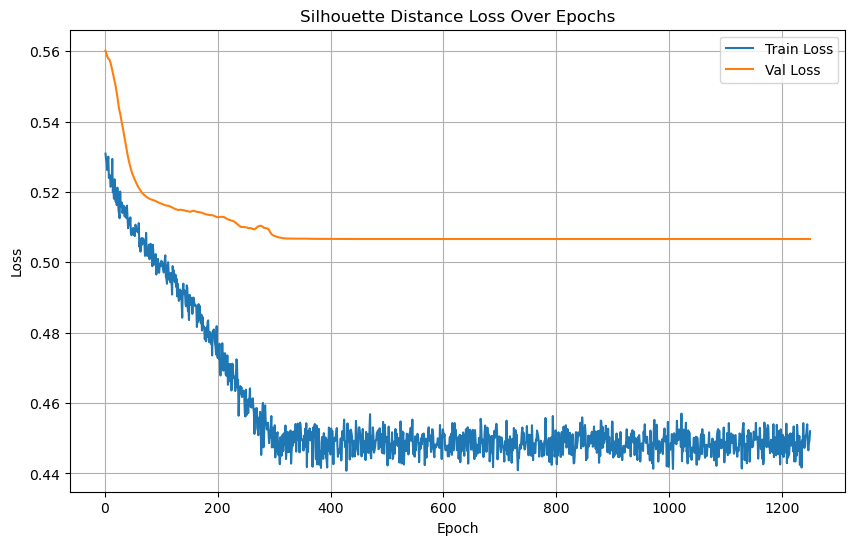

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/79], Loss: 0.3495
Test Batch [20/79], Loss: 0.0889
Test Batch [30/79], Loss: 0.4319


Test Batch [40/79], Loss: 0.2490
Test Batch [50/79], Loss: 0.2417
Test Batch [60/79], Loss: 0.4176


Test Batch [70/79], Loss: 0.2787

Test Loss: 0.3231


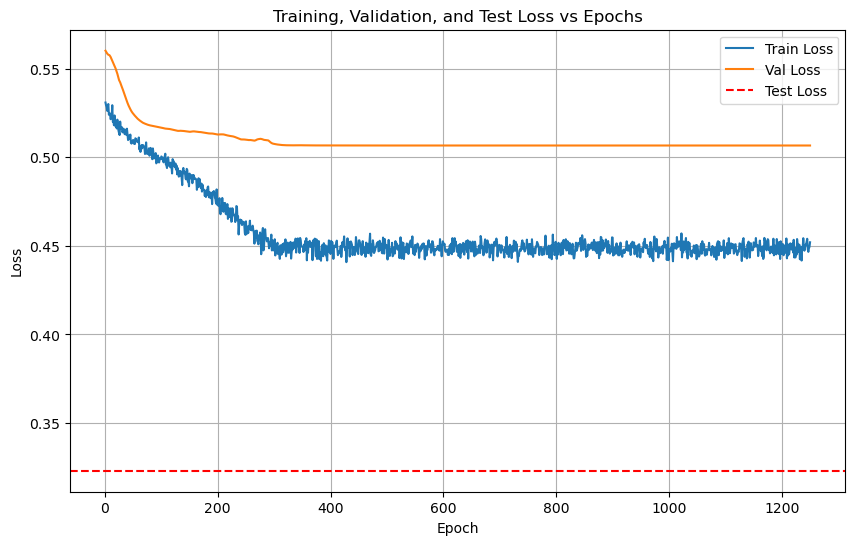

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/79 for test dataset.


  Processed batch 20/79 for test dataset.
  Processed batch 30/79 for test dataset.


  Processed batch 40/79 for test dataset.


  Processed batch 50/79 for test dataset.
  Processed batch 60/79 for test dataset.
  Processed batch 70/79 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 44.62%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.29      0.40      0.33         5
           5       0.33      0.20      0.25         5
           6       0.36      1.00      0.53         5
           7       0.25      0.40      0.31         5
           8       0.43      0.60      0.50         5
           9       0.40      0.40      0.40         5
          10       1.00      1.00      1.00         5
          11       0.75      0.60      0.67         5
          12       0.60      0.60      0.60         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6831  |  Val Loss: 2.6204
Validation loss improved from inf to 2.6204.
[Epoch 2/1000] Train Loss: 2.6700  |  Val Loss: 2.6151
Validation loss improved from 2.6204 to 2.6151.
[Epoch 3/1000] Train Loss: 2.6588  |  Val Loss: 2.6107
Validation loss improved from 2.6151 to 2.6107.
[Epoch 4/1000] Train Loss: 2.6496  |  Val Loss: 2.6066
Validation loss improved from 2.6107 to 2.6066.
[Epoch 5/1000] Train Loss: 2.6414  |  Val Loss: 2.6028
Validation loss improved from 2.6066 to 2.6028.
[Epoch 6/1000] Train Loss: 2.6328  |  Val Loss: 2.5993
Validation loss improved from 2.6028 to 2.5993.
[Epoch 7/1000] Train Loss: 2.6261  |  Val Loss: 2.5960
Validation loss improved from 2.5993 to 2.5960.
[Epoch 8/1000] Train Loss: 2.6188  |  Val Loss: 2.5931
Validation loss improved from 2.5960 to 2.5931.
[Epoch 9/1000] Train Loss: 2.6119  |  Val Loss: 2.5904
Validation loss improved from 2.5931 to 2.5904.
[Epoch 10/1000] Train Loss: 2.6063  |  Val Loss: 2.5878
Validation loss impr

[Epoch 19/1000] Train Loss: 2.5564  |  Val Loss: 2.5674
Validation loss improved from 2.5694 to 2.5674.
[Epoch 20/1000] Train Loss: 2.5516  |  Val Loss: 2.5654
Validation loss improved from 2.5674 to 2.5654.
[Epoch 21/1000] Train Loss: 2.5467  |  Val Loss: 2.5634
Validation loss improved from 2.5654 to 2.5634.
[Epoch 22/1000] Train Loss: 2.5420  |  Val Loss: 2.5616
Validation loss improved from 2.5634 to 2.5616.
[Epoch 23/1000] Train Loss: 2.5377  |  Val Loss: 2.5598
Validation loss improved from 2.5616 to 2.5598.
[Epoch 24/1000] Train Loss: 2.5330  |  Val Loss: 2.5579
Validation loss improved from 2.5598 to 2.5579.
[Epoch 25/1000] Train Loss: 2.5289  |  Val Loss: 2.5560
Validation loss improved from 2.5579 to 2.5560.
[Epoch 26/1000] Train Loss: 2.5249  |  Val Loss: 2.5541
Validation loss improved from 2.5560 to 2.5541.


[Epoch 27/1000] Train Loss: 2.5209  |  Val Loss: 2.5521
Validation loss improved from 2.5541 to 2.5521.
[Epoch 28/1000] Train Loss: 2.5165  |  Val Loss: 2.5503
Validation loss improved from 2.5521 to 2.5503.
[Epoch 29/1000] Train Loss: 2.5128  |  Val Loss: 2.5486
Validation loss improved from 2.5503 to 2.5486.
[Epoch 30/1000] Train Loss: 2.5087  |  Val Loss: 2.5469
Validation loss improved from 2.5486 to 2.5469.
[Epoch 31/1000] Train Loss: 2.5045  |  Val Loss: 2.5452
Validation loss improved from 2.5469 to 2.5452.
[Epoch 32/1000] Train Loss: 2.5004  |  Val Loss: 2.5436
Validation loss improved from 2.5452 to 2.5436.
[Epoch 33/1000] Train Loss: 2.4966  |  Val Loss: 2.5418
Validation loss improved from 2.5436 to 2.5418.
[Epoch 34/1000] Train Loss: 2.4920  |  Val Loss: 2.5399
Validation loss improved from 2.5418 to 2.5399.
[Epoch 35/1000] Train Loss: 2.4877  |  Val Loss: 2.5381
Validation loss improved from 2.5399 to 2.5381.
[Epoch 36/1000] Train Loss: 2.4839  |  Val Loss: 2.5364
Validati

[Epoch 50/1000] Train Loss: 2.4407  |  Val Loss: 2.5168
Validation loss improved from 2.5182 to 2.5168.
[Epoch 51/1000] Train Loss: 2.4379  |  Val Loss: 2.5155
Validation loss improved from 2.5168 to 2.5155.
[Epoch 52/1000] Train Loss: 2.4353  |  Val Loss: 2.5142
Validation loss improved from 2.5155 to 2.5142.
[Epoch 53/1000] Train Loss: 2.4327  |  Val Loss: 2.5129
Validation loss improved from 2.5142 to 2.5129.
[Epoch 54/1000] Train Loss: 2.4302  |  Val Loss: 2.5115
Validation loss improved from 2.5129 to 2.5115.
[Epoch 55/1000] Train Loss: 2.4278  |  Val Loss: 2.5102
Validation loss improved from 2.5115 to 2.5102.
[Epoch 56/1000] Train Loss: 2.4253  |  Val Loss: 2.5089
Validation loss improved from 2.5102 to 2.5089.


[Epoch 57/1000] Train Loss: 2.4226  |  Val Loss: 2.5076
Validation loss improved from 2.5089 to 2.5076.
[Epoch 58/1000] Train Loss: 2.4200  |  Val Loss: 2.5065
Validation loss improved from 2.5076 to 2.5065.
[Epoch 59/1000] Train Loss: 2.4173  |  Val Loss: 2.5053
Validation loss improved from 2.5065 to 2.5053.
[Epoch 60/1000] Train Loss: 2.4148  |  Val Loss: 2.5040
Validation loss improved from 2.5053 to 2.5040.
[Epoch 61/1000] Train Loss: 2.4120  |  Val Loss: 2.5027
Validation loss improved from 2.5040 to 2.5027.
[Epoch 62/1000] Train Loss: 2.4095  |  Val Loss: 2.5014
Validation loss improved from 2.5027 to 2.5014.
[Epoch 63/1000] Train Loss: 2.4072  |  Val Loss: 2.5001
Validation loss improved from 2.5014 to 2.5001.
[Epoch 64/1000] Train Loss: 2.4046  |  Val Loss: 2.4988
Validation loss improved from 2.5001 to 2.4988.
[Epoch 65/1000] Train Loss: 2.4022  |  Val Loss: 2.4974
Validation loss improved from 2.4988 to 2.4974.
[Epoch 66/1000] Train Loss: 2.3998  |  Val Loss: 2.4961
Validati

[Epoch 80/1000] Train Loss: 2.3618  |  Val Loss: 2.4764
Validation loss improved from 2.4779 to 2.4764.
[Epoch 81/1000] Train Loss: 2.3584  |  Val Loss: 2.4748
Validation loss improved from 2.4764 to 2.4748.
[Epoch 82/1000] Train Loss: 2.3554  |  Val Loss: 2.4731
Validation loss improved from 2.4748 to 2.4731.
[Epoch 83/1000] Train Loss: 2.3524  |  Val Loss: 2.4714
Validation loss improved from 2.4731 to 2.4714.
[Epoch 84/1000] Train Loss: 2.3496  |  Val Loss: 2.4698
Validation loss improved from 2.4714 to 2.4698.
[Epoch 85/1000] Train Loss: 2.3467  |  Val Loss: 2.4681
Validation loss improved from 2.4698 to 2.4681.
[Epoch 86/1000] Train Loss: 2.3437  |  Val Loss: 2.4666
Validation loss improved from 2.4681 to 2.4666.
[Epoch 87/1000] Train Loss: 2.3406  |  Val Loss: 2.4652
Validation loss improved from 2.4666 to 2.4652.
[Epoch 88/1000] Train Loss: 2.3375  |  Val Loss: 2.4638
Validation loss improved from 2.4652 to 2.4638.


[Epoch 89/1000] Train Loss: 2.3344  |  Val Loss: 2.4621
Validation loss improved from 2.4638 to 2.4621.
[Epoch 90/1000] Train Loss: 2.3308  |  Val Loss: 2.4605
Validation loss improved from 2.4621 to 2.4605.
[Epoch 91/1000] Train Loss: 2.3274  |  Val Loss: 2.4588
Validation loss improved from 2.4605 to 2.4588.
[Epoch 92/1000] Train Loss: 2.3242  |  Val Loss: 2.4572
Validation loss improved from 2.4588 to 2.4572.
[Epoch 93/1000] Train Loss: 2.3214  |  Val Loss: 2.4557
Validation loss improved from 2.4572 to 2.4557.
[Epoch 94/1000] Train Loss: 2.3184  |  Val Loss: 2.4542
Validation loss improved from 2.4557 to 2.4542.
[Epoch 95/1000] Train Loss: 2.3155  |  Val Loss: 2.4528
Validation loss improved from 2.4542 to 2.4528.
[Epoch 96/1000] Train Loss: 2.3129  |  Val Loss: 2.4513
Validation loss improved from 2.4528 to 2.4513.
[Epoch 97/1000] Train Loss: 2.3102  |  Val Loss: 2.4498
Validation loss improved from 2.4513 to 2.4498.
[Epoch 98/1000] Train Loss: 2.3072  |  Val Loss: 2.4480
Validati

[Epoch 111/1000] Train Loss: 2.2616  |  Val Loss: 2.4238
Validation loss improved from 2.4256 to 2.4238.
[Epoch 112/1000] Train Loss: 2.2581  |  Val Loss: 2.4221
Validation loss improved from 2.4238 to 2.4221.
[Epoch 113/1000] Train Loss: 2.2549  |  Val Loss: 2.4203
Validation loss improved from 2.4221 to 2.4203.
[Epoch 114/1000] Train Loss: 2.2518  |  Val Loss: 2.4185
Validation loss improved from 2.4203 to 2.4185.
[Epoch 115/1000] Train Loss: 2.2485  |  Val Loss: 2.4162
Validation loss improved from 2.4185 to 2.4162.
[Epoch 116/1000] Train Loss: 2.2456  |  Val Loss: 2.4135
Validation loss improved from 2.4162 to 2.4135.
[Epoch 117/1000] Train Loss: 2.2425  |  Val Loss: 2.4110
Validation loss improved from 2.4135 to 2.4110.
[Epoch 118/1000] Train Loss: 2.2392  |  Val Loss: 2.4087
Validation loss improved from 2.4110 to 2.4087.
[Epoch 119/1000] Train Loss: 2.2355  |  Val Loss: 2.4067
Validation loss improved from 2.4087 to 2.4067.
[Epoch 120/1000] Train Loss: 2.2319  |  Val Loss: 2.404

[Epoch 122/1000] Train Loss: 2.2253  |  Val Loss: 2.4013
Validation loss improved from 2.4031 to 2.4013.
[Epoch 123/1000] Train Loss: 2.2221  |  Val Loss: 2.3994
Validation loss improved from 2.4013 to 2.3994.
[Epoch 124/1000] Train Loss: 2.2188  |  Val Loss: 2.3976
Validation loss improved from 2.3994 to 2.3976.
[Epoch 125/1000] Train Loss: 2.2155  |  Val Loss: 2.3959
Validation loss improved from 2.3976 to 2.3959.
[Epoch 126/1000] Train Loss: 2.2125  |  Val Loss: 2.3940
Validation loss improved from 2.3959 to 2.3940.
[Epoch 127/1000] Train Loss: 2.2094  |  Val Loss: 2.3921
Validation loss improved from 2.3940 to 2.3921.
[Epoch 128/1000] Train Loss: 2.2063  |  Val Loss: 2.3902
Validation loss improved from 2.3921 to 2.3902.
[Epoch 129/1000] Train Loss: 2.2032  |  Val Loss: 2.3885
Validation loss improved from 2.3902 to 2.3885.
[Epoch 130/1000] Train Loss: 2.2001  |  Val Loss: 2.3865
Validation loss improved from 2.3885 to 2.3865.
[Epoch 131/1000] Train Loss: 2.1965  |  Val Loss: 2.384

[Epoch 139/1000] Train Loss: 2.1709  |  Val Loss: 2.3697
Validation loss improved from 2.3714 to 2.3697.
[Epoch 140/1000] Train Loss: 2.1680  |  Val Loss: 2.3679
Validation loss improved from 2.3697 to 2.3679.
[Epoch 141/1000] Train Loss: 2.1648  |  Val Loss: 2.3660
Validation loss improved from 2.3679 to 2.3660.
[Epoch 142/1000] Train Loss: 2.1618  |  Val Loss: 2.3642
Validation loss improved from 2.3660 to 2.3642.
[Epoch 143/1000] Train Loss: 2.1585  |  Val Loss: 2.3625
Validation loss improved from 2.3642 to 2.3625.
[Epoch 144/1000] Train Loss: 2.1555  |  Val Loss: 2.3607
Validation loss improved from 2.3625 to 2.3607.
[Epoch 145/1000] Train Loss: 2.1524  |  Val Loss: 2.3589
Validation loss improved from 2.3607 to 2.3589.
[Epoch 146/1000] Train Loss: 2.1494  |  Val Loss: 2.3569
Validation loss improved from 2.3589 to 2.3569.
[Epoch 147/1000] Train Loss: 2.1463  |  Val Loss: 2.3548
Validation loss improved from 2.3569 to 2.3548.
[Epoch 148/1000] Train Loss: 2.1432  |  Val Loss: 2.352

[Epoch 150/1000] Train Loss: 2.1371  |  Val Loss: 2.3484
Validation loss improved from 2.3504 to 2.3484.
[Epoch 151/1000] Train Loss: 2.1341  |  Val Loss: 2.3466
Validation loss improved from 2.3484 to 2.3466.
[Epoch 152/1000] Train Loss: 2.1311  |  Val Loss: 2.3448
Validation loss improved from 2.3466 to 2.3448.
[Epoch 153/1000] Train Loss: 2.1283  |  Val Loss: 2.3431
Validation loss improved from 2.3448 to 2.3431.
[Epoch 154/1000] Train Loss: 2.1253  |  Val Loss: 2.3411
Validation loss improved from 2.3431 to 2.3411.
[Epoch 155/1000] Train Loss: 2.1221  |  Val Loss: 2.3390
Validation loss improved from 2.3411 to 2.3390.
[Epoch 156/1000] Train Loss: 2.1189  |  Val Loss: 2.3370
Validation loss improved from 2.3390 to 2.3370.
[Epoch 157/1000] Train Loss: 2.1157  |  Val Loss: 2.3351
Validation loss improved from 2.3370 to 2.3351.
[Epoch 158/1000] Train Loss: 2.1126  |  Val Loss: 2.3331
Validation loss improved from 2.3351 to 2.3331.
[Epoch 159/1000] Train Loss: 2.1094  |  Val Loss: 2.331

[Epoch 170/1000] Train Loss: 2.0729  |  Val Loss: 2.3086
Validation loss improved from 2.3106 to 2.3086.
[Epoch 171/1000] Train Loss: 2.0695  |  Val Loss: 2.3065
Validation loss improved from 2.3086 to 2.3065.
[Epoch 172/1000] Train Loss: 2.0664  |  Val Loss: 2.3045
Validation loss improved from 2.3065 to 2.3045.
[Epoch 173/1000] Train Loss: 2.0632  |  Val Loss: 2.3027
Validation loss improved from 2.3045 to 2.3027.
[Epoch 174/1000] Train Loss: 2.0600  |  Val Loss: 2.3011
Validation loss improved from 2.3027 to 2.3011.
[Epoch 175/1000] Train Loss: 2.0565  |  Val Loss: 2.2991
Validation loss improved from 2.3011 to 2.2991.
[Epoch 176/1000] Train Loss: 2.0529  |  Val Loss: 2.2970
Validation loss improved from 2.2991 to 2.2970.
[Epoch 177/1000] Train Loss: 2.0490  |  Val Loss: 2.2948
Validation loss improved from 2.2970 to 2.2948.
[Epoch 178/1000] Train Loss: 2.0452  |  Val Loss: 2.2926
Validation loss improved from 2.2948 to 2.2926.
[Epoch 179/1000] Train Loss: 2.0415  |  Val Loss: 2.290

[Epoch 182/1000] Train Loss: 2.0301  |  Val Loss: 2.2831
Validation loss improved from 2.2854 to 2.2831.
[Epoch 183/1000] Train Loss: 2.0265  |  Val Loss: 2.2808
Validation loss improved from 2.2831 to 2.2808.
[Epoch 184/1000] Train Loss: 2.0227  |  Val Loss: 2.2786
Validation loss improved from 2.2808 to 2.2786.
[Epoch 185/1000] Train Loss: 2.0193  |  Val Loss: 2.2765
Validation loss improved from 2.2786 to 2.2765.
[Epoch 186/1000] Train Loss: 2.0159  |  Val Loss: 2.2743
Validation loss improved from 2.2765 to 2.2743.
[Epoch 187/1000] Train Loss: 2.0126  |  Val Loss: 2.2718
Validation loss improved from 2.2743 to 2.2718.
[Epoch 188/1000] Train Loss: 2.0089  |  Val Loss: 2.2691
Validation loss improved from 2.2718 to 2.2691.
[Epoch 189/1000] Train Loss: 2.0051  |  Val Loss: 2.2666
Validation loss improved from 2.2691 to 2.2666.
[Epoch 190/1000] Train Loss: 2.0014  |  Val Loss: 2.2641
Validation loss improved from 2.2666 to 2.2641.
[Epoch 191/1000] Train Loss: 1.9980  |  Val Loss: 2.261

[Epoch 202/1000] Train Loss: 1.9584  |  Val Loss: 2.2348
Validation loss improved from 2.2373 to 2.2348.
[Epoch 203/1000] Train Loss: 1.9544  |  Val Loss: 2.2327
Validation loss improved from 2.2348 to 2.2327.
[Epoch 204/1000] Train Loss: 1.9506  |  Val Loss: 2.2305
Validation loss improved from 2.2327 to 2.2305.
[Epoch 205/1000] Train Loss: 1.9467  |  Val Loss: 2.2282
Validation loss improved from 2.2305 to 2.2282.
[Epoch 206/1000] Train Loss: 1.9429  |  Val Loss: 2.2259
Validation loss improved from 2.2282 to 2.2259.
[Epoch 207/1000] Train Loss: 1.9393  |  Val Loss: 2.2235
Validation loss improved from 2.2259 to 2.2235.
[Epoch 208/1000] Train Loss: 1.9355  |  Val Loss: 2.2212
Validation loss improved from 2.2235 to 2.2212.
[Epoch 209/1000] Train Loss: 1.9318  |  Val Loss: 2.2189
Validation loss improved from 2.2212 to 2.2189.
[Epoch 210/1000] Train Loss: 1.9280  |  Val Loss: 2.2166
Validation loss improved from 2.2189 to 2.2166.


[Epoch 211/1000] Train Loss: 1.9243  |  Val Loss: 2.2142
Validation loss improved from 2.2166 to 2.2142.
[Epoch 212/1000] Train Loss: 1.9206  |  Val Loss: 2.2117
Validation loss improved from 2.2142 to 2.2117.
[Epoch 213/1000] Train Loss: 1.9168  |  Val Loss: 2.2098
Validation loss improved from 2.2117 to 2.2098.
[Epoch 214/1000] Train Loss: 1.9130  |  Val Loss: 2.2080
Validation loss improved from 2.2098 to 2.2080.
[Epoch 215/1000] Train Loss: 1.9092  |  Val Loss: 2.2063
Validation loss improved from 2.2080 to 2.2063.
[Epoch 216/1000] Train Loss: 1.9052  |  Val Loss: 2.2041
Validation loss improved from 2.2063 to 2.2041.
[Epoch 217/1000] Train Loss: 1.9014  |  Val Loss: 2.2016
Validation loss improved from 2.2041 to 2.2016.
[Epoch 218/1000] Train Loss: 1.8974  |  Val Loss: 2.1992
Validation loss improved from 2.2016 to 2.1992.
[Epoch 219/1000] Train Loss: 1.8934  |  Val Loss: 2.1972
Validation loss improved from 2.1992 to 2.1972.
[Epoch 220/1000] Train Loss: 1.8896  |  Val Loss: 2.195

[Epoch 234/1000] Train Loss: 1.8355  |  Val Loss: 2.1623
Validation loss improved from 2.1653 to 2.1623.
[Epoch 235/1000] Train Loss: 1.8311  |  Val Loss: 2.1599
Validation loss improved from 2.1623 to 2.1599.
[Epoch 236/1000] Train Loss: 1.8271  |  Val Loss: 2.1582
Validation loss improved from 2.1599 to 2.1582.
[Epoch 237/1000] Train Loss: 1.8230  |  Val Loss: 2.1563
Validation loss improved from 2.1582 to 2.1563.
[Epoch 238/1000] Train Loss: 1.8192  |  Val Loss: 2.1544
Validation loss improved from 2.1563 to 2.1544.
[Epoch 239/1000] Train Loss: 1.8155  |  Val Loss: 2.1523
Validation loss improved from 2.1544 to 2.1523.
[Epoch 240/1000] Train Loss: 1.8119  |  Val Loss: 2.1503
Validation loss improved from 2.1523 to 2.1503.
[Epoch 241/1000] Train Loss: 1.8084  |  Val Loss: 2.1483
Validation loss improved from 2.1503 to 2.1483.
[Epoch 242/1000] Train Loss: 1.8049  |  Val Loss: 2.1464
Validation loss improved from 2.1483 to 2.1464.
[Epoch 243/1000] Train Loss: 1.8014  |  Val Loss: 2.144

[Epoch 244/1000] Train Loss: 1.7979  |  Val Loss: 2.1428
Validation loss improved from 2.1444 to 2.1428.
[Epoch 245/1000] Train Loss: 1.7941  |  Val Loss: 2.1414
Validation loss improved from 2.1428 to 2.1414.
[Epoch 246/1000] Train Loss: 1.7902  |  Val Loss: 2.1401
Validation loss improved from 2.1414 to 2.1401.
[Epoch 247/1000] Train Loss: 1.7865  |  Val Loss: 2.1390
Validation loss improved from 2.1401 to 2.1390.
[Epoch 248/1000] Train Loss: 1.7824  |  Val Loss: 2.1374
Validation loss improved from 2.1390 to 2.1374.
[Epoch 249/1000] Train Loss: 1.7784  |  Val Loss: 2.1356
Validation loss improved from 2.1374 to 2.1356.
[Epoch 250/1000] Train Loss: 1.7740  |  Val Loss: 2.1340
Validation loss improved from 2.1356 to 2.1340.
[Epoch 251/1000] Train Loss: 1.7697  |  Val Loss: 2.1320
Validation loss improved from 2.1340 to 2.1320.
[Epoch 252/1000] Train Loss: 1.7655  |  Val Loss: 2.1295
Validation loss improved from 2.1320 to 2.1295.
[Epoch 253/1000] Train Loss: 1.7611  |  Val Loss: 2.126

[Epoch 262/1000] Train Loss: 1.7257  |  Val Loss: 2.1023
Validation loss improved from 2.1047 to 2.1023.
[Epoch 263/1000] Train Loss: 1.7217  |  Val Loss: 2.0999
Validation loss improved from 2.1023 to 2.0999.
[Epoch 264/1000] Train Loss: 1.7180  |  Val Loss: 2.0975
Validation loss improved from 2.0999 to 2.0975.
[Epoch 265/1000] Train Loss: 1.7140  |  Val Loss: 2.0950
Validation loss improved from 2.0975 to 2.0950.
[Epoch 266/1000] Train Loss: 1.7101  |  Val Loss: 2.0922
Validation loss improved from 2.0950 to 2.0922.
[Epoch 267/1000] Train Loss: 1.7060  |  Val Loss: 2.0891
Validation loss improved from 2.0922 to 2.0891.
[Epoch 268/1000] Train Loss: 1.7018  |  Val Loss: 2.0859
Validation loss improved from 2.0891 to 2.0859.
[Epoch 269/1000] Train Loss: 1.6974  |  Val Loss: 2.0830
Validation loss improved from 2.0859 to 2.0830.
[Epoch 270/1000] Train Loss: 1.6933  |  Val Loss: 2.0805
Validation loss improved from 2.0830 to 2.0805.
[Epoch 271/1000] Train Loss: 1.6889  |  Val Loss: 2.078

[Epoch 273/1000] Train Loss: 1.6811  |  Val Loss: 2.0743
Validation loss improved from 2.0763 to 2.0743.
[Epoch 274/1000] Train Loss: 1.6771  |  Val Loss: 2.0720
Validation loss improved from 2.0743 to 2.0720.
[Epoch 275/1000] Train Loss: 1.6732  |  Val Loss: 2.0701
Validation loss improved from 2.0720 to 2.0701.
[Epoch 276/1000] Train Loss: 1.6693  |  Val Loss: 2.0686
Validation loss improved from 2.0701 to 2.0686.
[Epoch 277/1000] Train Loss: 1.6654  |  Val Loss: 2.0671
Validation loss improved from 2.0686 to 2.0671.
[Epoch 278/1000] Train Loss: 1.6615  |  Val Loss: 2.0660
Validation loss improved from 2.0671 to 2.0660.
[Epoch 279/1000] Train Loss: 1.6578  |  Val Loss: 2.0642
Validation loss improved from 2.0660 to 2.0642.
[Epoch 280/1000] Train Loss: 1.6543  |  Val Loss: 2.0618
Validation loss improved from 2.0642 to 2.0618.
[Epoch 281/1000] Train Loss: 1.6503  |  Val Loss: 2.0593
Validation loss improved from 2.0618 to 2.0593.
[Epoch 282/1000] Train Loss: 1.6465  |  Val Loss: 2.056

[Epoch 291/1000] Train Loss: 1.6124  |  Val Loss: 2.0349
Validation loss improved from 2.0366 to 2.0349.
[Epoch 292/1000] Train Loss: 1.6084  |  Val Loss: 2.0331
Validation loss improved from 2.0349 to 2.0331.
[Epoch 293/1000] Train Loss: 1.6045  |  Val Loss: 2.0312
Validation loss improved from 2.0331 to 2.0312.
[Epoch 294/1000] Train Loss: 1.6006  |  Val Loss: 2.0292
Validation loss improved from 2.0312 to 2.0292.
[Epoch 295/1000] Train Loss: 1.5968  |  Val Loss: 2.0274
Validation loss improved from 2.0292 to 2.0274.
[Epoch 296/1000] Train Loss: 1.5931  |  Val Loss: 2.0255
Validation loss improved from 2.0274 to 2.0255.
[Epoch 297/1000] Train Loss: 1.5897  |  Val Loss: 2.0232
Validation loss improved from 2.0255 to 2.0232.
[Epoch 298/1000] Train Loss: 1.5862  |  Val Loss: 2.0213
Validation loss improved from 2.0232 to 2.0213.
[Epoch 299/1000] Train Loss: 1.5826  |  Val Loss: 2.0198
Validation loss improved from 2.0213 to 2.0198.
[Epoch 300/1000] Train Loss: 1.5790  |  Val Loss: 2.018

[Epoch 302/1000] Train Loss: 1.5716  |  Val Loss: 2.0155
Validation loss improved from 2.0170 to 2.0155.
[Epoch 303/1000] Train Loss: 1.5679  |  Val Loss: 2.0144
Validation loss improved from 2.0155 to 2.0144.
[Epoch 304/1000] Train Loss: 1.5645  |  Val Loss: 2.0139
Validation loss improved from 2.0144 to 2.0139.
[Epoch 305/1000] Train Loss: 1.5611  |  Val Loss: 2.0139
Validation loss improved from 2.0139 to 2.0139.
[Epoch 306/1000] Train Loss: 1.5578  |  Val Loss: 2.0137
Validation loss improved from 2.0139 to 2.0137.
[Epoch 307/1000] Train Loss: 1.5543  |  Val Loss: 2.0134
Validation loss improved from 2.0137 to 2.0134.
[Epoch 308/1000] Train Loss: 1.5510  |  Val Loss: 2.0133
Validation loss improved from 2.0134 to 2.0133.
[Epoch 309/1000] Train Loss: 1.5474  |  Val Loss: 2.0125
Validation loss improved from 2.0133 to 2.0125.
[Epoch 310/1000] Train Loss: 1.5438  |  Val Loss: 2.0113
Validation loss improved from 2.0125 to 2.0113.
[Epoch 311/1000] Train Loss: 1.5403  |  Val Loss: 2.009

[Epoch 320/1000] Train Loss: 1.5088  |  Val Loss: 1.9893
Validation loss improved from 1.9919 to 1.9893.
[Epoch 321/1000] Train Loss: 1.5051  |  Val Loss: 1.9872
Validation loss improved from 1.9893 to 1.9872.
[Epoch 322/1000] Train Loss: 1.5015  |  Val Loss: 1.9865
Validation loss improved from 1.9872 to 1.9865.
[Epoch 323/1000] Train Loss: 1.4975  |  Val Loss: 1.9858
Validation loss improved from 1.9865 to 1.9858.
[Epoch 324/1000] Train Loss: 1.4937  |  Val Loss: 1.9855
Validation loss improved from 1.9858 to 1.9855.
[Epoch 325/1000] Train Loss: 1.4901  |  Val Loss: 1.9845
Validation loss improved from 1.9855 to 1.9845.
[Epoch 326/1000] Train Loss: 1.4863  |  Val Loss: 1.9836
Validation loss improved from 1.9845 to 1.9836.
[Epoch 327/1000] Train Loss: 1.4823  |  Val Loss: 1.9828
Validation loss improved from 1.9836 to 1.9828.
[Epoch 328/1000] Train Loss: 1.4785  |  Val Loss: 1.9815
Validation loss improved from 1.9828 to 1.9815.
[Epoch 329/1000] Train Loss: 1.4748  |  Val Loss: 1.980

[Epoch 332/1000] Train Loss: 1.4648  |  Val Loss: 1.9803
Validation loss improved from 1.9806 to 1.9803.
[Epoch 333/1000] Train Loss: 1.4618  |  Val Loss: 1.9787
Validation loss improved from 1.9803 to 1.9787.
[Epoch 334/1000] Train Loss: 1.4587  |  Val Loss: 1.9760
Validation loss improved from 1.9787 to 1.9760.
[Epoch 335/1000] Train Loss: 1.4557  |  Val Loss: 1.9736
Validation loss improved from 1.9760 to 1.9736.
[Epoch 336/1000] Train Loss: 1.4525  |  Val Loss: 1.9711
Validation loss improved from 1.9736 to 1.9711.
[Epoch 337/1000] Train Loss: 1.4493  |  Val Loss: 1.9692
Validation loss improved from 1.9711 to 1.9692.
[Epoch 338/1000] Train Loss: 1.4461  |  Val Loss: 1.9680
Validation loss improved from 1.9692 to 1.9680.
[Epoch 339/1000] Train Loss: 1.4429  |  Val Loss: 1.9663
Validation loss improved from 1.9680 to 1.9663.
[Epoch 340/1000] Train Loss: 1.4397  |  Val Loss: 1.9640
Validation loss improved from 1.9663 to 1.9640.
[Epoch 341/1000] Train Loss: 1.4362  |  Val Loss: 1.961

[Epoch 351/1000] Train Loss: 1.4043  |  Val Loss: 1.9604
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 352/1000] Train Loss: 1.4011  |  Val Loss: 1.9594
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 353/1000] Train Loss: 1.3982  |  Val Loss: 1.9585
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 354/1000] Train Loss: 1.3953  |  Val Loss: 1.9580
Validation loss improved from 1.9580 to 1.9580.
[Epoch 355/1000] Train Loss: 1.3923  |  Val Loss: 1.9568
Validation loss improved from 1.9580 to 1.9568.
[Epoch 356/1000] Train Loss: 1.3892  |  Val Loss: 1.9557
Validation loss improved from 1.9568 to 1.9557.
[Epoch 357/1000] Train Loss: 1.3864  |  Val Loss: 1.9540
Validation loss improved from 1.9557 to 1.9540.
[Epoch 358/1000] Train Loss: 1.3832  |  Val Loss: 1.9520
Validation loss improved from 1.9540 to 1.9520.
[Epoch 359/1000] Train Loss: 1.3802  |  Val Loss: 1.9498
Validation loss improved from 1.9520 to 1.9498.
[Epoch 360/1000] Train Loss: 1.3770  

[Epoch 365/1000] Train Loss: 1.3628  |  Val Loss: 1.9383
Validation loss improved from 1.9395 to 1.9383.
[Epoch 366/1000] Train Loss: 1.3600  |  Val Loss: 1.9362
Validation loss improved from 1.9383 to 1.9362.
[Epoch 367/1000] Train Loss: 1.3571  |  Val Loss: 1.9346
Validation loss improved from 1.9362 to 1.9346.
[Epoch 368/1000] Train Loss: 1.3542  |  Val Loss: 1.9338
Validation loss improved from 1.9346 to 1.9338.
[Epoch 369/1000] Train Loss: 1.3512  |  Val Loss: 1.9325
Validation loss improved from 1.9338 to 1.9325.
[Epoch 370/1000] Train Loss: 1.3483  |  Val Loss: 1.9308
Validation loss improved from 1.9325 to 1.9308.
[Epoch 371/1000] Train Loss: 1.3451  |  Val Loss: 1.9292
Validation loss improved from 1.9308 to 1.9292.
[Epoch 372/1000] Train Loss: 1.3420  |  Val Loss: 1.9274
Validation loss improved from 1.9292 to 1.9274.
[Epoch 373/1000] Train Loss: 1.3390  |  Val Loss: 1.9259
Validation loss improved from 1.9274 to 1.9259.
[Epoch 374/1000] Train Loss: 1.3362  |  Val Loss: 1.924

[Epoch 382/1000] Train Loss: 1.3135  |  Val Loss: 1.9274
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 383/1000] Train Loss: 1.3109  |  Val Loss: 1.9269
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 384/1000] Train Loss: 1.3083  |  Val Loss: 1.9266
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 385/1000] Train Loss: 1.3056  |  Val Loss: 1.9268
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 386/1000] Train Loss: 1.3033  |  Val Loss: 1.9263
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 387/1000] Train Loss: 1.3007  |  Val Loss: 1.9253
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 388/1000] Train Loss: 1.2982  |  Val Loss: 1.9237
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 389/1000] Train Loss: 1.2956  |  Val Loss: 1.9218
Validation loss improved from 1.9220 to 1.9218.
[Epoch 390/1000] Train Loss: 1.2931  |  Val Loss: 1.9203
Validation loss improved from 1.9218 to 1.9203.
[Epoch 391

[Epoch 398/1000] Train Loss: 1.2732  |  Val Loss: 1.9126
Validation loss improved from 1.9141 to 1.9126.
[Epoch 399/1000] Train Loss: 1.2707  |  Val Loss: 1.9110
Validation loss improved from 1.9126 to 1.9110.
[Epoch 400/1000] Train Loss: 1.2681  |  Val Loss: 1.9092
Validation loss improved from 1.9110 to 1.9092.
[Epoch 401/1000] Train Loss: 1.2654  |  Val Loss: 1.9075
Validation loss improved from 1.9092 to 1.9075.
[Epoch 402/1000] Train Loss: 1.2629  |  Val Loss: 1.9063
Validation loss improved from 1.9075 to 1.9063.
[Epoch 403/1000] Train Loss: 1.2601  |  Val Loss: 1.9064
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 404/1000] Train Loss: 1.2573  |  Val Loss: 1.9067
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 405/1000] Train Loss: 1.2551  |  Val Loss: 1.9077
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 406/1000] Train Loss: 1.2529  |  Val Loss: 1.9090
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 407/1000] Train Loss: 1.

[Epoch 409/1000] Train Loss: 1.2465  |  Val Loss: 1.9088
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 410/1000] Train Loss: 1.2443  |  Val Loss: 1.9073
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 411/1000] Train Loss: 1.2419  |  Val Loss: 1.9050
Validation loss improved from 1.9063 to 1.9050.
[Epoch 412/1000] Train Loss: 1.2398  |  Val Loss: 1.9034
Validation loss improved from 1.9050 to 1.9034.
[Epoch 413/1000] Train Loss: 1.2375  |  Val Loss: 1.9030
Validation loss improved from 1.9034 to 1.9030.
[Epoch 414/1000] Train Loss: 1.2354  |  Val Loss: 1.9025
Validation loss improved from 1.9030 to 1.9025.
[Epoch 415/1000] Train Loss: 1.2333  |  Val Loss: 1.9019
Validation loss improved from 1.9025 to 1.9019.
[Epoch 416/1000] Train Loss: 1.2312  |  Val Loss: 1.9006
Validation loss improved from 1.9019 to 1.9006.
[Epoch 417/1000] Train Loss: 1.2291  |  Val Loss: 1.8986
Validation loss improved from 1.9006 to 1.8986.
[Epoch 418/1000] Train Loss: 1.2267  |  Val

[Epoch 424/1000] Train Loss: 1.2118  |  Val Loss: 1.8885
Validation loss improved from 1.8893 to 1.8885.
[Epoch 425/1000] Train Loss: 1.2092  |  Val Loss: 1.8879
Validation loss improved from 1.8885 to 1.8879.
[Epoch 426/1000] Train Loss: 1.2066  |  Val Loss: 1.8871
Validation loss improved from 1.8879 to 1.8871.
[Epoch 427/1000] Train Loss: 1.2041  |  Val Loss: 1.8865
Validation loss improved from 1.8871 to 1.8865.
[Epoch 428/1000] Train Loss: 1.2017  |  Val Loss: 1.8860
Validation loss improved from 1.8865 to 1.8860.
[Epoch 429/1000] Train Loss: 1.1994  |  Val Loss: 1.8853
Validation loss improved from 1.8860 to 1.8853.
[Epoch 430/1000] Train Loss: 1.1971  |  Val Loss: 1.8844
Validation loss improved from 1.8853 to 1.8844.
[Epoch 431/1000] Train Loss: 1.1950  |  Val Loss: 1.8833
Validation loss improved from 1.8844 to 1.8833.
[Epoch 432/1000] Train Loss: 1.1929  |  Val Loss: 1.8821
Validation loss improved from 1.8833 to 1.8821.
[Epoch 433/1000] Train Loss: 1.1908  |  Val Loss: 1.881

[Epoch 438/1000] Train Loss: 1.1795  |  Val Loss: 1.8857
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 439/1000] Train Loss: 1.1774  |  Val Loss: 1.8860
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 440/1000] Train Loss: 1.1752  |  Val Loss: 1.8858
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 441/1000] Train Loss: 1.1730  |  Val Loss: 1.8850
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 442/1000] Train Loss: 1.1710  |  Val Loss: 1.8840
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 443/1000] Train Loss: 1.1690  |  Val Loss: 1.8833
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 444/1000] Train Loss: 1.1672  |  Val Loss: 1.8826
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 445/1000] Train Loss: 1.1654  |  Val Loss: 1.8819
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 446/1000] Train Loss: 1.1638  |  Val Loss: 1.8815
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 453/1000] Train Loss: 1.1506  |  Val Loss: 1.8974
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 454/1000] Train Loss: 1.1489  |  Val Loss: 1.8990
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 455/1000] Train Loss: 1.1471  |  Val Loss: 1.8997
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 456/1000] Train Loss: 1.1454  |  Val Loss: 1.9001
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 457/1000] Train Loss: 1.1437  |  Val Loss: 1.9001
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 458/1000] Train Loss: 1.1420  |  Val Loss: 1.9004
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 459/1000] Train Loss: 1.1404  |  Val Loss: 1.9017
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 460/1000] Train Loss: 1.1384  |  Val Loss: 1.9021
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 461/1000] Train Loss: 1.1365  |  Val Loss: 1.9011
!! Validation loss did NOT improve !! Patience:

[Epoch 469/1000] Train Loss: 1.1215  |  Val Loss: 1.8942
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 470/1000] Train Loss: 1.1197  |  Val Loss: 1.8930
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 471/1000] Train Loss: 1.1179  |  Val Loss: 1.8918
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 472/1000] Train Loss: 1.1160  |  Val Loss: 1.8907
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 473/1000] Train Loss: 1.1143  |  Val Loss: 1.8898
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 474/1000] Train Loss: 1.1125  |  Val Loss: 1.8880
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 475/1000] Train Loss: 1.1107  |  Val Loss: 1.8852
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 476/1000] Train Loss: 1.1087  |  Val Loss: 1.8837
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 477/1000] Train Loss: 1.1068  |  Val Loss: 1.8825
!! Validation loss did NOT improve !! Patience:

[Epoch 483/1000] Train Loss: 1.0956  |  Val Loss: 1.8787
Validation loss improved from 1.8790 to 1.8787.
[Epoch 484/1000] Train Loss: 1.0937  |  Val Loss: 1.8783
Validation loss improved from 1.8787 to 1.8783.
[Epoch 485/1000] Train Loss: 1.0921  |  Val Loss: 1.8780
Validation loss improved from 1.8783 to 1.8780.
[Epoch 486/1000] Train Loss: 1.0907  |  Val Loss: 1.8770
Validation loss improved from 1.8780 to 1.8770.
[Epoch 487/1000] Train Loss: 1.0886  |  Val Loss: 1.8756
Validation loss improved from 1.8770 to 1.8756.
[Epoch 488/1000] Train Loss: 1.0869  |  Val Loss: 1.8743
Validation loss improved from 1.8756 to 1.8743.
[Epoch 489/1000] Train Loss: 1.0854  |  Val Loss: 1.8733
Validation loss improved from 1.8743 to 1.8733.
[Epoch 490/1000] Train Loss: 1.0836  |  Val Loss: 1.8729
Validation loss improved from 1.8733 to 1.8729.
[Epoch 491/1000] Train Loss: 1.0817  |  Val Loss: 1.8734
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 492/1000] Train Loss: 1.0798  |  Val Loss:

[Epoch 497/1000] Train Loss: 1.0726  |  Val Loss: 1.8796
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 498/1000] Train Loss: 1.0713  |  Val Loss: 1.8809
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 499/1000] Train Loss: 1.0698  |  Val Loss: 1.8833
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 500/1000] Train Loss: 1.0682  |  Val Loss: 1.8850
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 501/1000] Train Loss: 1.0667  |  Val Loss: 1.8867
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 502/1000] Train Loss: 1.0652  |  Val Loss: 1.8879
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 503/1000] Train Loss: 1.0639  |  Val Loss: 1.8883
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 504/1000] Train Loss: 1.0625  |  Val Loss: 1.8886
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 505/1000] Train Loss: 1.0611  |  Val Loss: 1.8896
!! Validation loss did NOT improve !! Patience: 15

[Epoch 513/1000] Train Loss: 1.0485  |  Val Loss: 1.8956
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 514/1000] Train Loss: 1.0468  |  Val Loss: 1.8954
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 515/1000] Train Loss: 1.0454  |  Val Loss: 1.8953
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 516/1000] Train Loss: 1.0441  |  Val Loss: 1.8955
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 517/1000] Train Loss: 1.0426  |  Val Loss: 1.8958
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 518/1000] Train Loss: 1.0411  |  Val Loss: 1.8958
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 519/1000] Train Loss: 1.0399  |  Val Loss: 1.8961
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 520/1000] Train Loss: 1.0382  |  Val Loss: 1.8966
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 521/1000] Train Loss: 1.0367  |  Val Loss: 1.8964
!! Validation loss did NOT improve !! Patience:

[Epoch 524/1000] Train Loss: 1.0311  |  Val Loss: 1.8982
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 525/1000] Train Loss: 1.0294  |  Val Loss: 1.8994
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 526/1000] Train Loss: 1.0276  |  Val Loss: 1.9007
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 527/1000] Train Loss: 1.0258  |  Val Loss: 1.9027
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 528/1000] Train Loss: 1.0239  |  Val Loss: 1.9048
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 529/1000] Train Loss: 1.0222  |  Val Loss: 1.9066
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 530/1000] Train Loss: 1.0205  |  Val Loss: 1.9070
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 531/1000] Train Loss: 1.0187  |  Val Loss: 1.9059
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 532/1000] Train Loss: 1.0170  |  Val Loss: 1.9052
!! Validation loss did NOT improve !! Patience:

[Epoch 541/1000] Train Loss: 1.0035  |  Val Loss: 1.9023
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 542/1000] Train Loss: 1.0025  |  Val Loss: 1.9019
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 543/1000] Train Loss: 1.0008  |  Val Loss: 1.9015
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 544/1000] Train Loss: 0.9991  |  Val Loss: 1.9007
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 545/1000] Train Loss: 0.9976  |  Val Loss: 1.8992
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 546/1000] Train Loss: 0.9964  |  Val Loss: 1.8980
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 547/1000] Train Loss: 0.9949  |  Val Loss: 1.8969
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 548/1000] Train Loss: 0.9937  |  Val Loss: 1.8966
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 549/1000] Train Loss: 0.9924  |  Val Loss: 1.8964
!! Validation loss did NOT improve !! Patience:

[Epoch 558/1000] Train Loss: 0.9786  |  Val Loss: 1.8981
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 559/1000] Train Loss: 0.9772  |  Val Loss: 1.8985
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 560/1000] Train Loss: 0.9758  |  Val Loss: 1.8994
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 561/1000] Train Loss: 0.9746  |  Val Loss: 1.9011
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 562/1000] Train Loss: 0.9734  |  Val Loss: 1.9026
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 563/1000] Train Loss: 0.9719  |  Val Loss: 1.9043
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 564/1000] Train Loss: 0.9707  |  Val Loss: 1.9061
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 565/1000] Train Loss: 0.9694  |  Val Loss: 1.9078
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 566/1000] Train Loss: 0.9682  |  Val Loss: 1.9093
!! Validation loss did NOT improve !! Patience:

[Epoch 574/1000] Train Loss: 0.9586  |  Val Loss: 1.9159
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 575/1000] Train Loss: 0.9574  |  Val Loss: 1.9162
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 576/1000] Train Loss: 0.9560  |  Val Loss: 1.9166
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 577/1000] Train Loss: 0.9546  |  Val Loss: 1.9165
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 578/1000] Train Loss: 0.9527  |  Val Loss: 1.9155
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 579/1000] Train Loss: 0.9511  |  Val Loss: 1.9149
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 580/1000] Train Loss: 0.9499  |  Val Loss: 1.9149
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 581/1000] Train Loss: 0.9488  |  Val Loss: 1.9160
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 582/1000] Train Loss: 0.9475  |  Val Loss: 1.9175
!! Validation loss did NOT improve !! Patience:

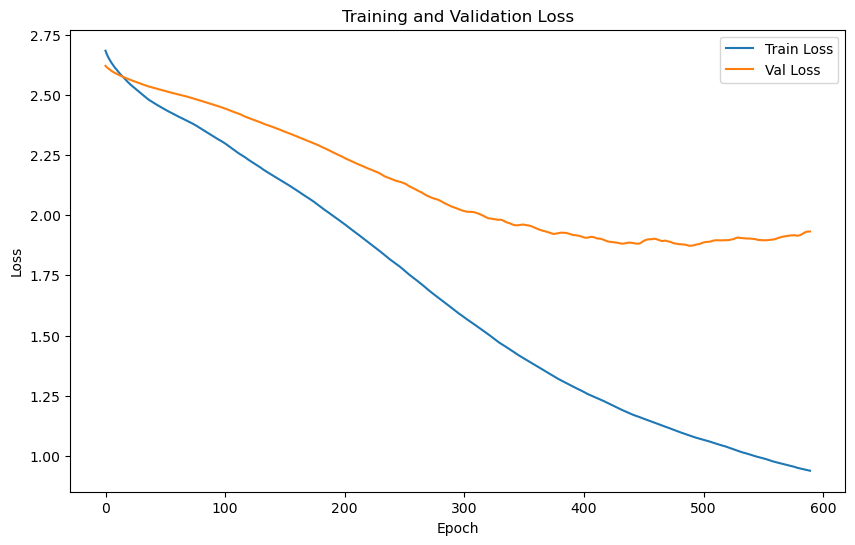

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.2038 | Test Accuracy: 56.60%


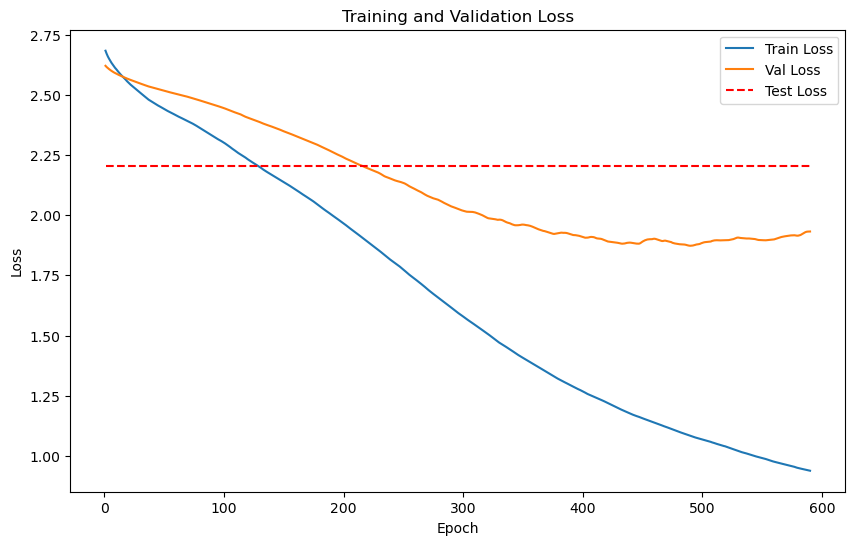

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


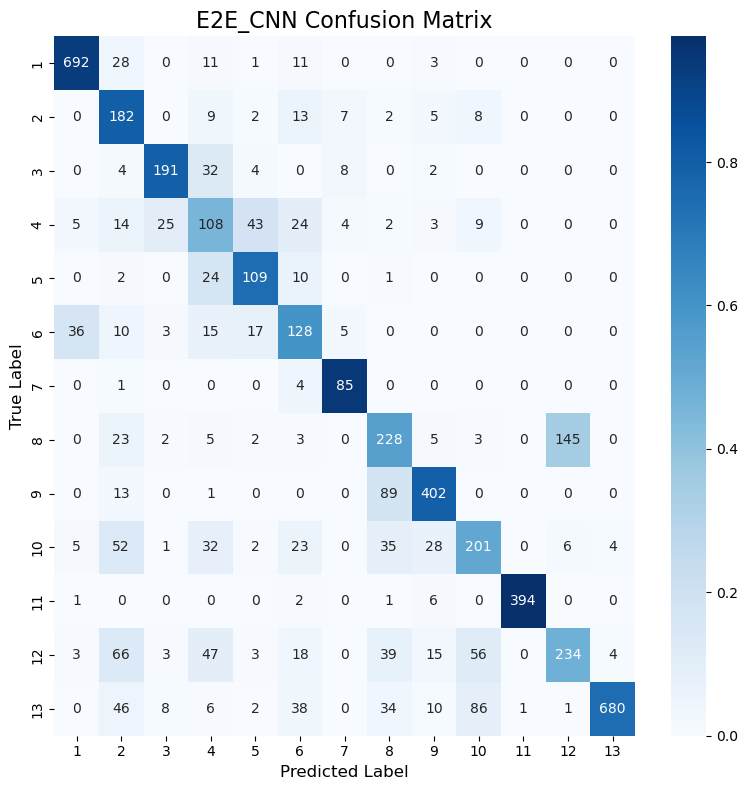

Classification Accuracy: 72.45%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


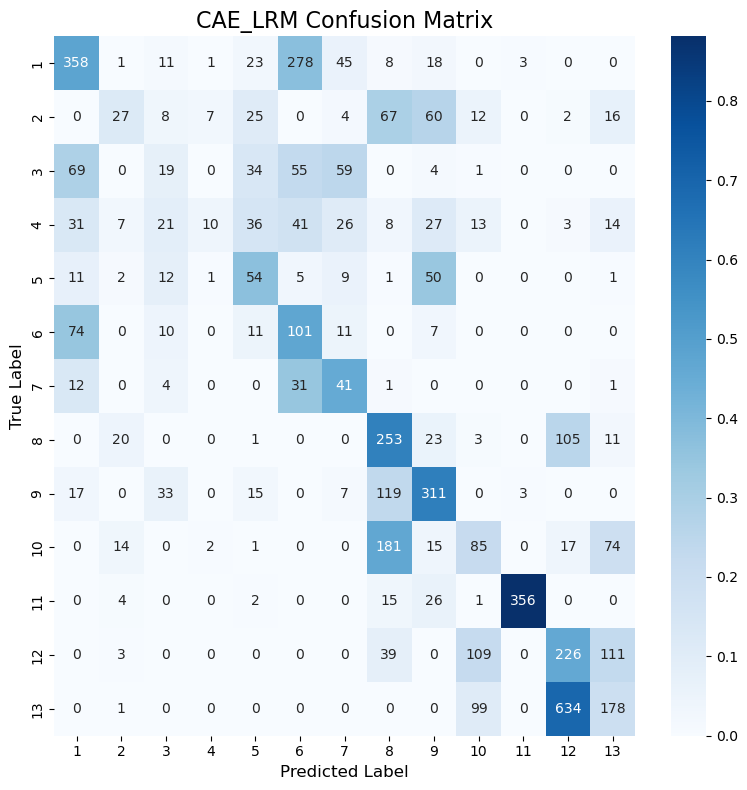

Classification Accuracy: 40.25%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


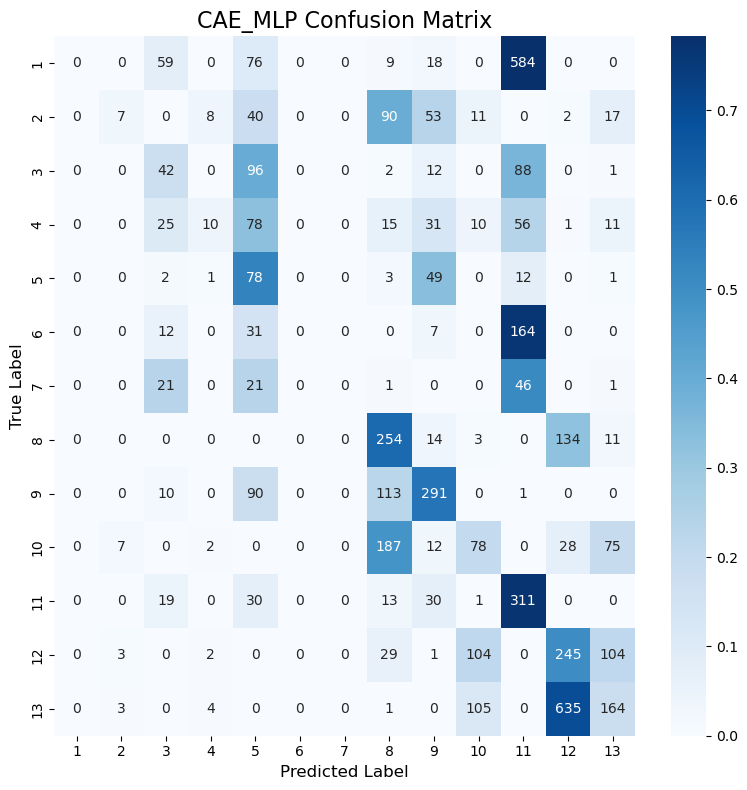

Classification Accuracy: 29.51%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


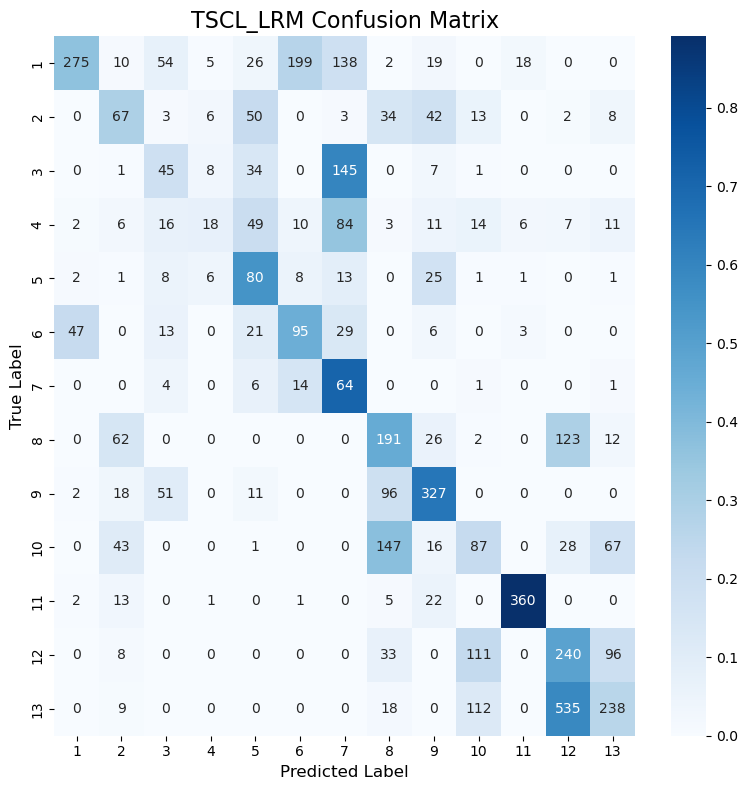

Classification Accuracy: 41.61%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


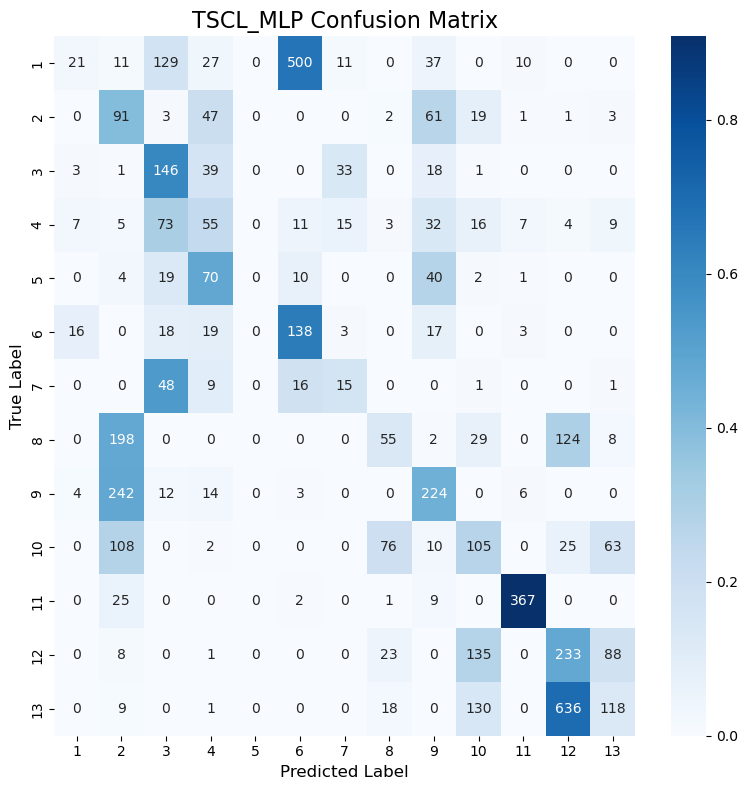

Classification Accuracy: 31.26%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


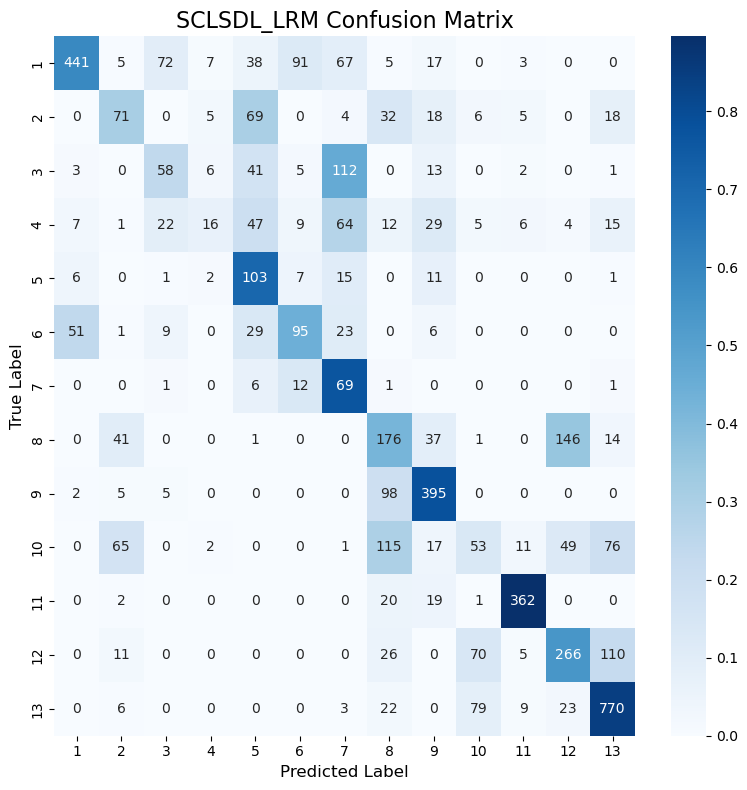

Classification Accuracy: 57.32%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


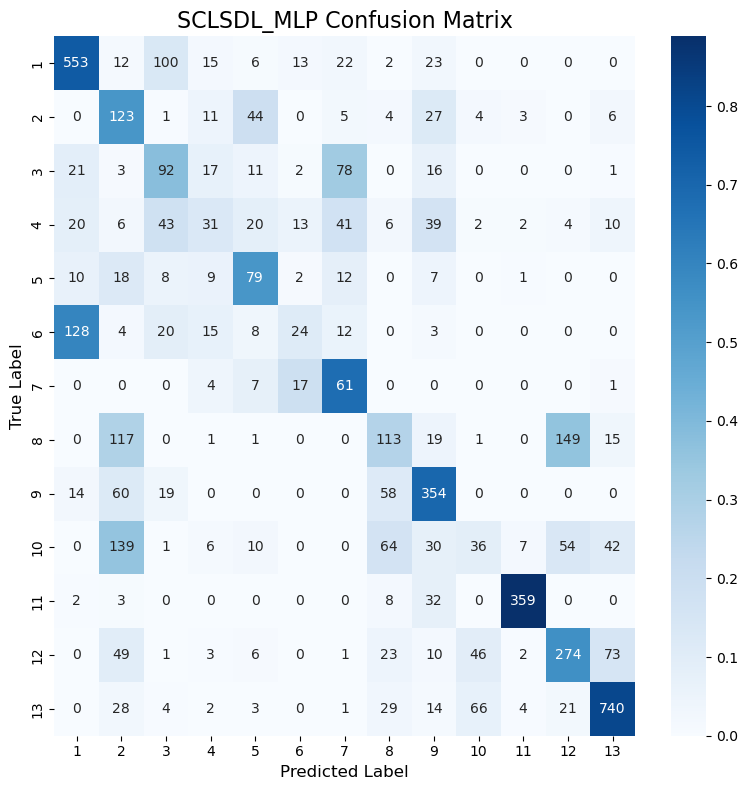

Classification Accuracy: 56.60%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          72.45
1    LRM (CAE)          40.25
2    MLP (CAE)          29.51
3     TSCL LRM          41.61
4     TSCL MLP          31.26
5  SCL_SDL LRM          57.32
6  SCL_SDL MLP          56.60

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          72.45
5  SCL_SDL LRM          57.32
6  SCL_SDL MLP          56.60
3     TSCL LRM          41.61
1    LRM (CAE)          40.25
4     TSCL MLP          31.26
2    MLP (CAE)          29.51
